In [1]:
import sys
import os
import yaml
import tensorflow as tf
import pandas as pd
import numpy as np
import netCDF4 as nc
from os.path import exists, join
from goes16ci.data import load_data_serial
from goes16ci.models import train_conv_net_cpu, train_conv_net_gpu, MinMaxScaler2D, StandardScaler2D, seed_everything
from goes16ci.monitor import Monitor, start_timing, end_timing, get_gpu_names, get_gpu_topo, get_cuda_version, get_cudnn_version, get_nccl_version
import argparse
import logging
from datetime import datetime
import platform
from multiprocessing import Pipe, Process
import traceback
import pickle
from sklearn.utils import class_weight
from os import listdir
from os.path import isfile, join
import time
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from time import perf_counter
import matplotlib.pyplot as plt
from keras import backend as K
import scipy.io as scio
from scipy import stats
from echo.src.base_objective import BaseObjective
from echo.src.pruners import KerasPruningCallback
sys.path.append('/glade/work/fanda/optimization/echo_opt')
sys.path.append('/glade/work/fanda/util/goes16ci/goes16ci')
#from models_test import train_conv_net_cpu, train_conv_net_gpu, MinMaxScaler2D
import optuna
gpus = tf.config.get_visible_devices("GPU")
for device in gpus:
    print(device)
    tf.config.experimental.set_memory_growth(device, True)

2023-05-22 23:13:00.793744: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


Using TensorFlow backend.
2023-05-22 23:13:10.637703: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-05-22 23:13:10.638972: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-05-22 23:13:10.650936: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:61:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-05-22 23:13:10.650965: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2023-05-22 23:13:10.670203: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2023-05-22 23:13:10.670307: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic l

In [2]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
tf.compat.v1.experimental.output_all_intermediates(True)

In [3]:
#def main():
seed_everything(4835)
My_dir = '/glade/scratch/fanda/files/GOESR_HRRR_PC'#GOESR_HRRR_PC/'
train_dir = My_dir+'/train_20/' 
test_dir = My_dir+'/test_21/'
onlyfiles = [f for f in listdir(train_dir) if isfile(join(train_dir, f))]
testfiles = [f for f in listdir(test_dir) if isfile(join(test_dir, f))]

config_file = open('/glade/work/fanda/optimization/benchmark_config_default_echo_best_resnet.yml',"r")
config = yaml.load(config_file, Loader=yaml.Loader)
print(config["dtype"])
# load data serial
logging.info("Split training and validation data")
train = []
label = []
test = []
test_label = []
lat_1 = []
lon_1 = []
date_1 = []
Type_1 = []
lat_train = []
lon_train = []
Type_train = []
benchmark_data = dict()
# load data serial
benchmark_data["config"] = config
for file in onlyfiles:
    processed_file = nc.Dataset(os.path.join(train_dir,file))
    #if np.sum(np.isnan(processed_file.variables['predictor']))==0:
    train.append(processed_file.variables['predictor'])
    label.append(processed_file.variables['label'])
    lat_1.append(processed_file.variables['lat_0'])
    lon_1.append(processed_file.variables['lon_0'])
    Type_1.append(processed_file.variables['Type'])
all_images = np.concatenate(train).astype(config["dtype"])
all_labels = np.concatenate(label).astype(config["dtype"])
lat_train = np.concatenate(lat_1).astype(config["dtype"])
lon_train = np.concatenate(lon_1).astype(config["dtype"])
Type_train = np.concatenate(Type_1).astype(config["dtype"])
all_images = np.moveaxis(all_images,1,-1)
delete_row =[]
for i in range(len(all_labels)):
    if np.sum(np.isnan(all_images[i,:,:,:]))>0 or np.max(all_images[i,:,:,:])>60000:
        delete_row.append(i)
    elif Type_train[i] > 1:
        if lon_train[i] > -91-0.5 or lon_train[i] < -104+0.5 \
        or lat_train[i] > 48-0.5 or lat_train[i] <34+0.5:
            delete_row.append(i)
lat_1 = []
lon_1 = []
Type_1 = []
all_images = np.delete(all_images, delete_row, 0)
all_labels = np.delete(all_labels, delete_row, 0)
delete_row =[]
for file in testfiles:
    processed_file = nc.Dataset(os.path.join(test_dir,file))
    #if np.sum(np.isnan(processed_file.variables['predictor']))==0:
    if file.endswith("RM.nc"):
        half_size=int(np.shape(processed_file.variables['label'])[0]/2)
        test.append(processed_file.variables['predictor'][:half_size,:,:,:])
        test_label.append(processed_file.variables['label'][:half_size])
        lat_1.append(processed_file.variables['lat_0'][:half_size])
        lon_1.append(processed_file.variables['lon_0'][:half_size])
        date_1.append(processed_file.variables['date'][:half_size])
        Type_1.append(processed_file.variables['Type'][:half_size])
    else:
        test.append(processed_file.variables['predictor'])
        test_label.append(processed_file.variables['label'])
        lat_1.append(processed_file.variables['lat_0'])
        lon_1.append(processed_file.variables['lon_0'])
        date_1.append(processed_file.variables['date'])
        Type_1.append(processed_file.variables['Type'])
test_images = np.concatenate(test).astype(config["dtype"])
test_labels = np.concatenate(test_label).astype(config["dtype"])
lat_0 = np.concatenate(lat_1).astype(config["dtype"])
lon_0 = np.concatenate(lon_1).astype(config["dtype"])
date_0 = np.concatenate(date_1).astype(config["dtype"])
Type_0 = np.concatenate(Type_1).astype(config["dtype"])
test_images = np.moveaxis(test_images,1,-1)
for i in range(len(test_labels)):
    if np.sum(np.isnan(test_images[i,:,:,:]))>0 or np.max(test_images[i,:,:,:])>60000:
        delete_row.append(i)
    elif Type_0[i] > 1:
        if lon_0[i] > -91-0.5 or lon_0[i] < -104+0.5 \
        or lat_0[i] > 48-0.5 or lat_0[i] <34+0.5:
            delete_row.append(i)
test_images = np.delete(test_images, delete_row, 0)
test_labels = np.delete(test_labels, delete_row, 0)
lat_0= np.delete(lat_0, delete_row, 0)
lon_0= np.delete(lon_0, delete_row, 0)
date_0= np.delete(date_0, delete_row, 0)
Type_0= np.delete(Type_0, delete_row, 0)
#print(np.shape(all_images))
#print(np.shape(test_images))
num = np.shape(all_images)[0]
shuffler = np.random.permutation(len(all_images))
images_shuffled = all_images[shuffler]
labels_shuffled = all_labels[shuffler]
shuffler2 = np.random.permutation(len(test_images))
test_images_shuffled = test_images[shuffler2]
test_labels_shuffled = test_labels[shuffler2]
lat_0 = lat_0[shuffler2]
lon_0 = lon_0[shuffler2]
date_0 = date_0[shuffler2]
Type_0 = Type_0[shuffler2]

train_val_split = int(num*0.7)#25000
num_ch = np.arange(7,14)#np.arange(7,14)#28,35)
train_data = images_shuffled[:train_val_split,:,:,num_ch].astype(config["dtype"])
train_label = labels_shuffled[:train_val_split].astype(config["dtype"])
val_data = images_shuffled[train_val_split:,:,:,num_ch].astype(config["dtype"])
val_label = labels_shuffled[train_val_split:].astype(config["dtype"])
test_data = test_images_shuffled[:,:,:,num_ch].astype(config["dtype"])
test_label = test_labels_shuffled[:].astype(config["dtype"])
#print("ALL DATA=", all_data)

#rotate 90/180/270/360 degree
'''
for i in range(len(train_data)):
    train_data[i,:,:,:]=tf.image.rot90(train_data[i,:,:,:], k=np.random.randint(0,4))
for i in range(len(test_data)):
    test_data[i,:,:,:]=tf.image.rot90(test_data[i,:,:,:], k=np.random.randint(0,4))
'''
#scaler = MinMaxScaler2D()
#train_data_scaled = 1.0 - scaler.fit_transform(train_data) #1.0 - train_data#1.0 - scaler.fit_transform(train_data)
#val_data_scaled = 1.0 - scaler.transform(val_data) #1.0 -val_data#1.0 - scaler.transform(val_data)
#test_data_scaled = 1.0 - scaler.transform(test_data)
scaler = StandardScaler2D()
train_data_scaled = scaler.fit_transform(train_data) #1.0 - train_data#1.0 - scaler.fit_transform(train_data)
val_data_scaled = scaler.transform(val_data) #1.0 -val_data#1.0 - scaler.transform(val_data)
test_data_scaled = scaler.transform(test_data)
print(np.shape(train_data))
print(np.shape(val_data))
print(np.shape(test_data))
#for i in range(num_ch):
#    for j in range(num):
#        all_images[j,:,:,i] = (all_images[j,:,:,i] - np.min(np.squeeze(all_images[j,:,:,i])))\
#        /(np.max(np.squeeze(all_images[j,:,:,i]))-np.min(np.squeeze(all_images[j,:,:,i])))
#train_val_split = 28000 #1300 #14000

float32
(45077, 32, 32, 7)
(19320, 32, 32, 7)
(30221, 32, 32, 7)


In [116]:
int(num*0.7)

45077

In [5]:
import scipy.io as scio
test_lead10_all_indices = scio.loadmat("test_lead10_all_indices.mat")
print(test_lead10_all_indices["best_hit_indices"])

[[ 8409 12452 12988 15449 29203 11162   976   852  1282  4654  5047 13765
  14748 12089 12295 11805 18642 28946 25990 24704 12014 23555 14814 25339
  12871 19747 17627 21956  4162 29219 28419 28947 21824 11393 24925 26478
  19604 26111 20303 16546  7943 11357 27362  5878  3168 25136 18874 10083
   5335  8423 13616  2672 28190 29997  1218  3202 25118 22388 12119   653
  29132 16829 12269 19852 21051 22019 16426  6441 29650  1940 25797 23567
  11261 14914 24556  8033  6300  5576 18516 15350 29176 23198 29480 11795
   9276  3042 29736 12646 10210 23195 24128 22011 21480 16947 22676  5416
  15432  4332 10287  2004]]


In [3]:
print(np.sum(train_label)/np.shape(train_label))
print(np.sum(val_label)/np.shape(val_label))
print(np.sum(test_label)/np.shape(test_label))

[0.57801096]
[0.58178054]
[0.57817412]


In [74]:
(50000, 32, 32, 7)
(20350, 32, 32, 7)
(33389, 32, 32, 7)

0.0

In [24]:
train_val_split = 50000#25000
num_ch = np.arange(42,49)#np.arange(7,14)#28,35)
train_data = images_shuffled[:train_val_split,:,:,num_ch].astype(config["dtype"])
train_label = labels_shuffled[:train_val_split].astype(config["dtype"])
val_data = images_shuffled[train_val_split:,:,:,num_ch].astype(config["dtype"])
val_label = labels_shuffled[train_val_split:].astype(config["dtype"])
test_data = test_images_shuffled[:,:,:,num_ch].astype(config["dtype"])
test_label = test_labels_shuffled[:].astype(config["dtype"])
#print("ALL DATA=", all_data)

#rotate 90/180/270/360 degree
'''
for i in range(len(train_data)):
    train_data[i,:,:,:]=tf.image.rot90(train_data[i,:,:,:], k=np.random.randint(0,4))
for i in range(len(test_data)):
    test_data[i,:,:,:]=tf.image.rot90(test_data[i,:,:,:], k=np.random.randint(0,4))
'''
#scaler = MinMaxScaler2D()
#train_data_scaled = 1.0 - scaler.fit_transform(train_data) #1.0 - train_data#1.0 - scaler.fit_transform(train_data)
#val_data_scaled = 1.0 - scaler.transform(val_data) #1.0 -val_data#1.0 - scaler.transform(val_data)
#test_data_scaled = 1.0 - scaler.transform(test_data)
scaler = StandardScaler2D()
train_data_scaled = scaler.fit_transform(train_data) #1.0 - train_data#1.0 - scaler.fit_transform(train_data)
val_data_scaled = scaler.transform(val_data) #1.0 -val_data#1.0 - scaler.transform(val_data)
test_data_scaled = scaler.transform(test_data)

In [25]:
import pickle

# save
with open('scaler_lead_time/60min/std_scaler.bin','wb') as f:
    pickle.dump(scaler, f)

In [26]:
# load
with open('scaler_lead_time/60min/std_scaler.bin', 'rb') as f:
    test_scaler = pickle.load(f)

In [27]:
test = test_scaler.reverse_transform(test_data_scaled)
print(np.sum(test-test_data))

0.0


In [31]:
test_scaler.scale_values

mean        std
0  226.663742  11.264339
1  231.215759  14.898145
2  235.343414  17.941559
3  247.326019  29.155720
4  239.835144  14.594514
5  248.783859  30.219706
6  247.645218  30.149313

In [43]:
Res_target_preds = np.zeros(6)
Log_target_preds = np.zeros(6)
#T = [0.49,0.46,0.41,0.40,0.40,0.31]
for i in range(6):
    my_model = tf.keras.models.load_model("/glade/work/fanda/echo_resnet_lead_time/"+str(10*(i+1))+"min/goes16_resnet_gpus_01.h5",compile=False)
    load_data = scio.loadmat('test_data/test_lead'+str(10*(i+1))+'.mat')
    #binary_threshold = T[i]
    preds = my_model.predict(load_data["test_data_scaled"]).reshape(load_data["test_label"].shape)
    Res_target_preds[i] = preds[0][index[10]]
    
    with open('echo_log_lead_time/'+str(10*(i+1))+'min/Logistic_regression_optimal.pkl', 'rb') as f:
        log = pickle.load(f)
    test_data_scaled_flatten = load_data["test_data_scaled"].reshape((-1,7168))
    log_preds = log.predict_proba(test_data_scaled_flatten)[:,1]
    Log_target_preds[i] = log_preds[index[10]]
    
    

2023-04-02 09:38:21.751551: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 09:38:21.762258: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-04-02 09:38:21.780687: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:8a:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-04-02 09:38:21.780728: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2023-04-02 09:38:21.780796: I tensorflow/stream_executor/platform/default/dso_loader.cc:49]

In [44]:
print(Res_target_preds)
print(Log_target_preds)

[0.06278803 0.06527014 0.28620672 0.57339555 0.47960457 0.59573352]
[0.64812392 0.71325076 0.58769876 0.610165   0.56246191 0.46953222]


In [70]:
print(date_0[index[10]])

1623008300.0


In [11]:
# Flattened test data for logistic model
test_data_scaled_flatten = test_data_scaled.reshape((-1,7168))
# Generate model prediction
resnet_preds = resnet.predict(test_data_scaled)[:,0]
log_preds = log.predict_proba(test_data_scaled_flatten)[:,1]

2023-03-24 09:36:39.149052: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-03-24 09:36:39.149595: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2600000000 Hz
2023-03-24 09:36:39.358032: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2023-03-24 09:36:39.664550: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2023-03-24 09:36:39.666200: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


In [18]:
print("ResNet:{}".format(resnet_preds[index[99]]))
print("Logistic:{}".format(log_preds[index[99]]))

ResNet:0.9999722242355347
Logistic:0.8390135765075684


In [87]:
# Print out the mean and std
for i in range(6):
    with open('scaler_lead_time/'+str(i+1)+'0min/std_scaler.bin', 'rb') as f:
        test_scaler = pickle.load(f)
    print("Lead time: {} min".format(str((i+1)*10)))
    print(test_scaler.scale_values)

Lead time: 10 min
         mean        std
0  226.497177  11.340858
1  230.985031  14.988479
2  235.045105  18.021124
3  246.751831  29.108398
4  239.543427  14.536984
5  248.179855  30.151775
6  247.049606  30.082361
Lead time: 20 min
         mean        std
0  226.619583  11.348116
1  231.170731  15.003773
2  235.313248  18.055155
3  247.366196  29.287394
4  239.868073  14.645139
5  248.822617  30.353361
6  247.666245  30.282324
Lead time: 30 min
         mean        std
0  226.753815  11.338789
1  231.373917  14.997787
2  235.603592  18.067741
3  248.066574  29.479973
4  240.236954  14.766439
5  249.554565  30.571186
6  248.369019  30.613003
Lead time: 40 min
         mean        std
0  226.906097  11.320254
1  231.597549  14.977429
2  235.915726  18.062040
3  248.819183  29.666382
4  240.632599  14.889928
5  250.340729  30.784285
6  249.124695  30.705263
Lead time: 50 min
         mean        std
0  227.072144  11.294873
1  231.838989  14.946280
2  236.248840  18.039612
3  249.592

In [4]:
# set the probability threshold for binary classification; predict on validation; add binary preds
#import keras
#my_model = keras.models.load_model("goes16ci_model_cpu_lead10_allIR.h5")#models/goes16ci_model_cpu2022-06-06 15:28:51.532054.h5")#"goes16ci_model_cpu_lead0_allIR.h5")
#my_model = tf.saved_model.load("/storage/home/dxf424/work/scrip/goes16ci_model_cpu_lead10_allIR.h5")
T = [0.54, 0.48]#[0.49,0.46,0.41,0.40,0.40,0.31]
i = 0
my_model = tf.keras.models.load_model("/glade/work/fanda/echo_resnet_lead_time/"+str(10*(i+1))+"min/goes16_resnet_gpus_01.h5",compile=False)
load_data = scio.loadmat('test_data/test_lead'+str(10*(i+1))+'.mat')
binary_threshold = T[i]
preds = my_model.predict(load_data["test_data_scaled"]).reshape(load_data["test_label"].shape)
binary_preds = np.where(preds >= binary_threshold, 1, 0)

2023-03-29 08:55:25.544576: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-29 08:55:25.545163: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-03-29 08:55:25.554413: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:8a:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-03-29 08:55:25.744605: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2023-03-29 08:55:26.987970: I tensorflow/stream_executor/platform/default/dso_loader.cc:49]

In [28]:
best_hit_indices

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [39]:
indices

array([    0,     1,     3, ..., 33383, 33386, 33388])

In [5]:
#print(preds[test_label==1])
#np.where((dists >= r) & (dists <= r + dr))
ind=[]
indices = (np.where((load_data["test_label"][0,:]==1) & (binary_preds[0,:]==1)))[0]
ind = np.argsort(preds[0,indices])[-100:]
best_hit_indices = indices[ind]

indices = (np.where((load_data["test_label"][0,:]==0) & (binary_preds[0,:]==1)))[0]
ind = np.argsort(preds[0,indices])[-100:]
worst_false_alarm_indices = indices[ind]

indices = (np.where((load_data["test_label"][0,:]==1) & (binary_preds[0,:]==0)))[0]
ind = np.argsort(-preds[0,indices])[-100:]
worst_miss_indices = indices[ind]

indices = (np.where((load_data["test_label"][0,:]==0) & (binary_preds[0,:]==0)))[0]
ind = np.argsort(-preds[0,indices])[-100:]
best_correct_null_indices = indices[ind]

print(indices.shape)
print(indices[ind])
print(preds[0,best_hit_indices])
print(preds[0,worst_false_alarm_indices])
print(preds[0,worst_miss_indices])
print(preds[0,best_correct_null_indices])

(7703,)
[ 2728 25550 11060 19347 30001 24400 21080 18134 22302 23794 26583  4537
 10317  9142  4158 13011  1681 25735 27432 11964  4683 11968 21169  7474
 16306 29458 23933  4294 23806  9269  9660 28010 16937  7940  9606 24612
 19474  9237  7720  3281 23336 13166 28904 28635 14840  6036 25248  2702
 16951 18733 24662 19479 15281   422 21421 29914   103 17035  6238 13022
  3179  8530 28997 10760   377 11242 22538 14756 16097   614 21099  8688
 18292 17579  1866  8484  3437  5518  1487 22253  5245 10047 14593 22694
  1621  4694 11177 29461 15156 24523 29884 14012 19849 11993 11781  4994
 22264  7682  8563 25426]
[0.999579   0.99958295 0.9995851  0.99958676 0.9995994  0.9996007
 0.99961025 0.9996214  0.9996228  0.9996239  0.9996257  0.9996263
 0.9996283  0.9996371  0.9996371  0.99963784 0.999642   0.9996426
 0.9996513  0.99965286 0.9996562  0.9996655  0.9996661  0.99967
 0.9996728  0.99967587 0.99968076 0.99968326 0.99968445 0.999686
 0.9996896  0.9996929  0.9997002  0.9997048  0.9997217 

In [6]:
import scipy.io as scio
scio.savemat('test_lead10_all_indices.mat',{'best_hit_indices':best_hit_indices, 
                                            'worst_false_alarm_indices':worst_false_alarm_indices, 
                                            'worst_miss_indices':worst_miss_indices,
                                            'best_correct_null_indices':best_correct_null_indices})

In [2]:
import scipy.io as scio
test_lead10_all_indices = scio.loadmat("test_lead10_all_indices.mat")
print(test_lead10_all_indices["best_hit_indices"])

[[ 8409 12452 12988 15449 29203 11162   976   852  1282  4654  5047 13765
  14748 12089 12295 11805 18642 28946 25990 24704 12014 23555 14814 25339
  12871 19747 17627 21956  4162 29219 28419 28947 21824 11393 24925 26478
  19604 26111 20303 16546  7943 11357 27362  5878  3168 25136 18874 10083
   5335  8423 13616  2672 28190 29997  1218  3202 25118 22388 12119   653
  29132 16829 12269 19852 21051 22019 16426  6441 29650  1940 25797 23567
  11261 14914 24556  8033  6300  5576 18516 15350 29176 23198 29480 11795
   9276  3042 29736 12646 10210 23195 24128 22011 21480 16947 22676  5416
  15432  4332 10287  2004]]


In [8]:
preds[0,test_lead10_all_indices["best_hit_indices"]]

array([[0.999579  , 0.99958295, 0.9995851 , 0.99958676, 0.9995994 ,
        0.9996007 , 0.99961025, 0.9996214 , 0.9996228 , 0.9996239 ,
        0.9996257 , 0.9996263 , 0.9996283 , 0.9996371 , 0.9996371 ,
        0.99963784, 0.999642  , 0.9996426 , 0.9996513 , 0.99965286,
        0.9996562 , 0.9996655 , 0.9996661 , 0.99967   , 0.9996728 ,
        0.99967587, 0.99968076, 0.99968326, 0.99968445, 0.999686  ,
        0.9996896 , 0.9996929 , 0.9997002 , 0.9997048 , 0.9997217 ,
        0.9997222 , 0.9997317 , 0.99973375, 0.9997415 , 0.9997545 ,
        0.99975675, 0.99976057, 0.9997621 , 0.9997625 , 0.99976486,
        0.99977285, 0.99977916, 0.99977916, 0.99978215, 0.99979573,
        0.99979836, 0.9997987 , 0.99980456, 0.99981016, 0.9998167 ,
        0.9998173 , 0.99981993, 0.9998234 , 0.99982363, 0.99982905,
        0.9998313 , 0.99983335, 0.9998398 , 0.99984753, 0.9998518 ,
        0.99985504, 0.9998573 , 0.99985754, 0.999858  , 0.99985933,
        0.99986374, 0.9998666 , 0.99987245, 0.99

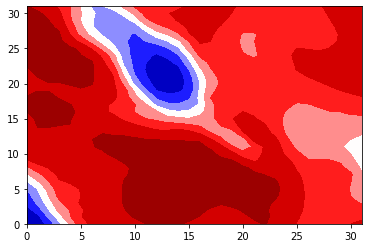

In [51]:
plt.contourf(np.squeeze(test_images_shuffled[index[2+80],:,:,j]), cmap='seismic', shading="flat", edgecolors='None', N=45)

In [ ]:
#matplotlib.rcParams.update({'font.size': 24})
index=test_lead10_all_indices["worst_miss_indices"][0]
vmin = 220#test_images_shuffled[index[0:10],:,:,7:14].min() # set min/max plotting range  
vmax = 290#test_images_shuffled[index[0:10],:,:,7:14].max()

row = 10
column = 7
#fig, ax = plt.subplots(3, 7, figsize=(42, 18))
fig, ax = plt.subplots(row,column, figsize=(6*column,6*row))
for i in range(row):
    for j in range(column):
        #all_images[index,:,:,i].plot(ax=ax.ravel()[i], vmin=vmin, vmax=vmax)
        a = ax[i][j].contourf(np.squeeze(test_images_shuffled[index[i+10],:,:,j+7]), cmap='seismic', shading="flat", edgecolors='None', N=45, vmin=vmin, vmax=vmax)
        ax[i][j].axis('off')
        if i == 0:
            ax[i][j].set_title('ch'+str(j+8),fontsize=36)
plt.tight_layout()

In [75]:
vmin = test_images_shuffled[index[0:10],:,:,7:14].min() # set min/max plotting range  
vmax = test_images_shuffled[index[0:10],:,:,7:14].max()
print(vmin)
print(vmax)

216.26143
305.3171


In [27]:
from cpt_convert import loadCPT # Import the CPT convert function
from matplotlib.colors import LinearSegmentedColormap # Linear interpolation for color maps
# Converts the CPT file to be used in Python
cpt = loadCPT('IR4AVHRR6.cpt')
# Makes a linear interpolation with the CPT file
cpt_convert = LinearSegmentedColormap('cpt', cpt)

In [ ]:
print(cpt)

In [106]:
print(cpt_convert)

In [100]:
for j in range(7):
    print(np.min(test_images_shuffled[index[2],:,:,j]))
    print(np.max(test_images_shuffled[index[2],:,:,j]))

230.73215
237.12398
236.87971
247.04462
239.61436
255.60466
245.99171
283.80576
237.34657
256.40448
249.35901
286.40097
248.80475
286.40292


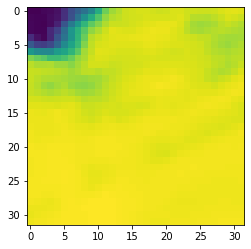

In [56]:
plt.imshow(np.squeeze(test_images_shuffled[index[99],:,:,j+i*7]))

In [23]:
index=test_lead10_all_indices["worst_miss_indices"][0]
for i in range(81, 84):
    lon_center = lon_0[index[i]]
    lat_center = lat_0[index[i]]
    print(time_plus_2h(str(datetime.datetime.fromtimestamp(date_0[index[i]]))))
    print(lon_0[index[i]])
    print(lat_0[index[i]])

2021-06-03 12:08:32
-101.36
34.11
2021-06-11 14:42:08
-99.54
36.3
2021-06-08 10:34:40
-102.67
37.69


In [4]:
# For false alarm:
import datetime
def time_plus_2h(initial_date):
    return str(datetime.datetime.strptime(initial_date,'%Y-%m-%d %H:%M:%S')+datetime.timedelta(hours=2))
i=10
index=test_lead10_all_indices["worst_miss_indices"][0]
lon_center = lon_0[index[i]]
lat_center = lat_0[index[i]]
print(time_plus_2h(str(datetime.datetime.fromtimestamp(date_0[index[i]]))))
print(lon_0[index[i]])
print(lat_0[index[i]])
My_dir = '/glade/scratch/fanda/files/MergedReflectivityQCComposite/28/MergedReflectivityQCComposite/00.50'
testfiles = [f for f in listdir(My_dir) if isfile(join(My_dir, f))]
#testfiles.sort
files = []
for i in testfiles:
    if i[9:15]>'012700' and i[9:15]<'022900':
    #if i[9:15]>'101620' and i[9:15]<'111820':
    #if i[9:15]>'184600' and i[9:15]<'194800':
    #if i[9:15]>'143520' and i[9:15]<'153720':
    #if i[9:15]>'065340' and i[9:15]<'075540':
        files.append(i)
files=sorted(files)
print(len(files))
processed_file=nc.Dataset(os.path.join(My_dir,files[0]))
dbz = processed_file.variables['MergedReflectivityQCComposite'][:]
interval = processed_file.LatGridSpacing
lon_grid, lat_grid = np.meshgrid(np.arange(processed_file.Longitude,processed_file.Longitude+interval*np.shape(dbz)[1],interval),
                                 np.arange(processed_file.Latitude,processed_file.Latitude-interval*np.shape(dbz)[0],-interval))
lat_target_0 = lat_center-0.24#42.75-0.1#34.93#39#34.93 43.23 -98.14 42.75 -97.66
lat_target_1 = lat_center+0.24 #43.23+0.1#35.41#42#35.41+0.01
lon_target_0 = lon_center-0.24#-98.14-0.1#-98.79#-99#-98.79
lon_target_1 = lon_center+0.24#-97.66+0.1#-98.31#-96#-98.31-0.01
lon_1d = np.arange(processed_file.Longitude,processed_file.Longitude+interval*np.shape(dbz)[1],interval)
lat_1d = np.arange(processed_file.Latitude,processed_file.Latitude-interval*np.shape(dbz)[1],-interval)
lat_index_0 = np.where(np.abs(lat_1d-lat_target_0)<0.001)
lat_index_1 = np.where(np.abs(lat_1d-lat_target_1)<0.001)
lon_index_0 = np.where(np.abs(lon_1d-lon_target_0)<0.001)
lon_index_1 = np.where(np.abs(lon_1d-lon_target_1)<0.001)

2021-06-28 02:28:16
-101.52
47.22
31


In [ ]:
[0.06278803 0.06527014 0.28620672 0.57339555 0.47960457 0.59573352]
[0.64812392 0.71325076 0.58769876 0.610165   0.56246191 0.46953222]

247.73308
248.21875
247.91023
246.34996
245.65971
246.45679
247.85356


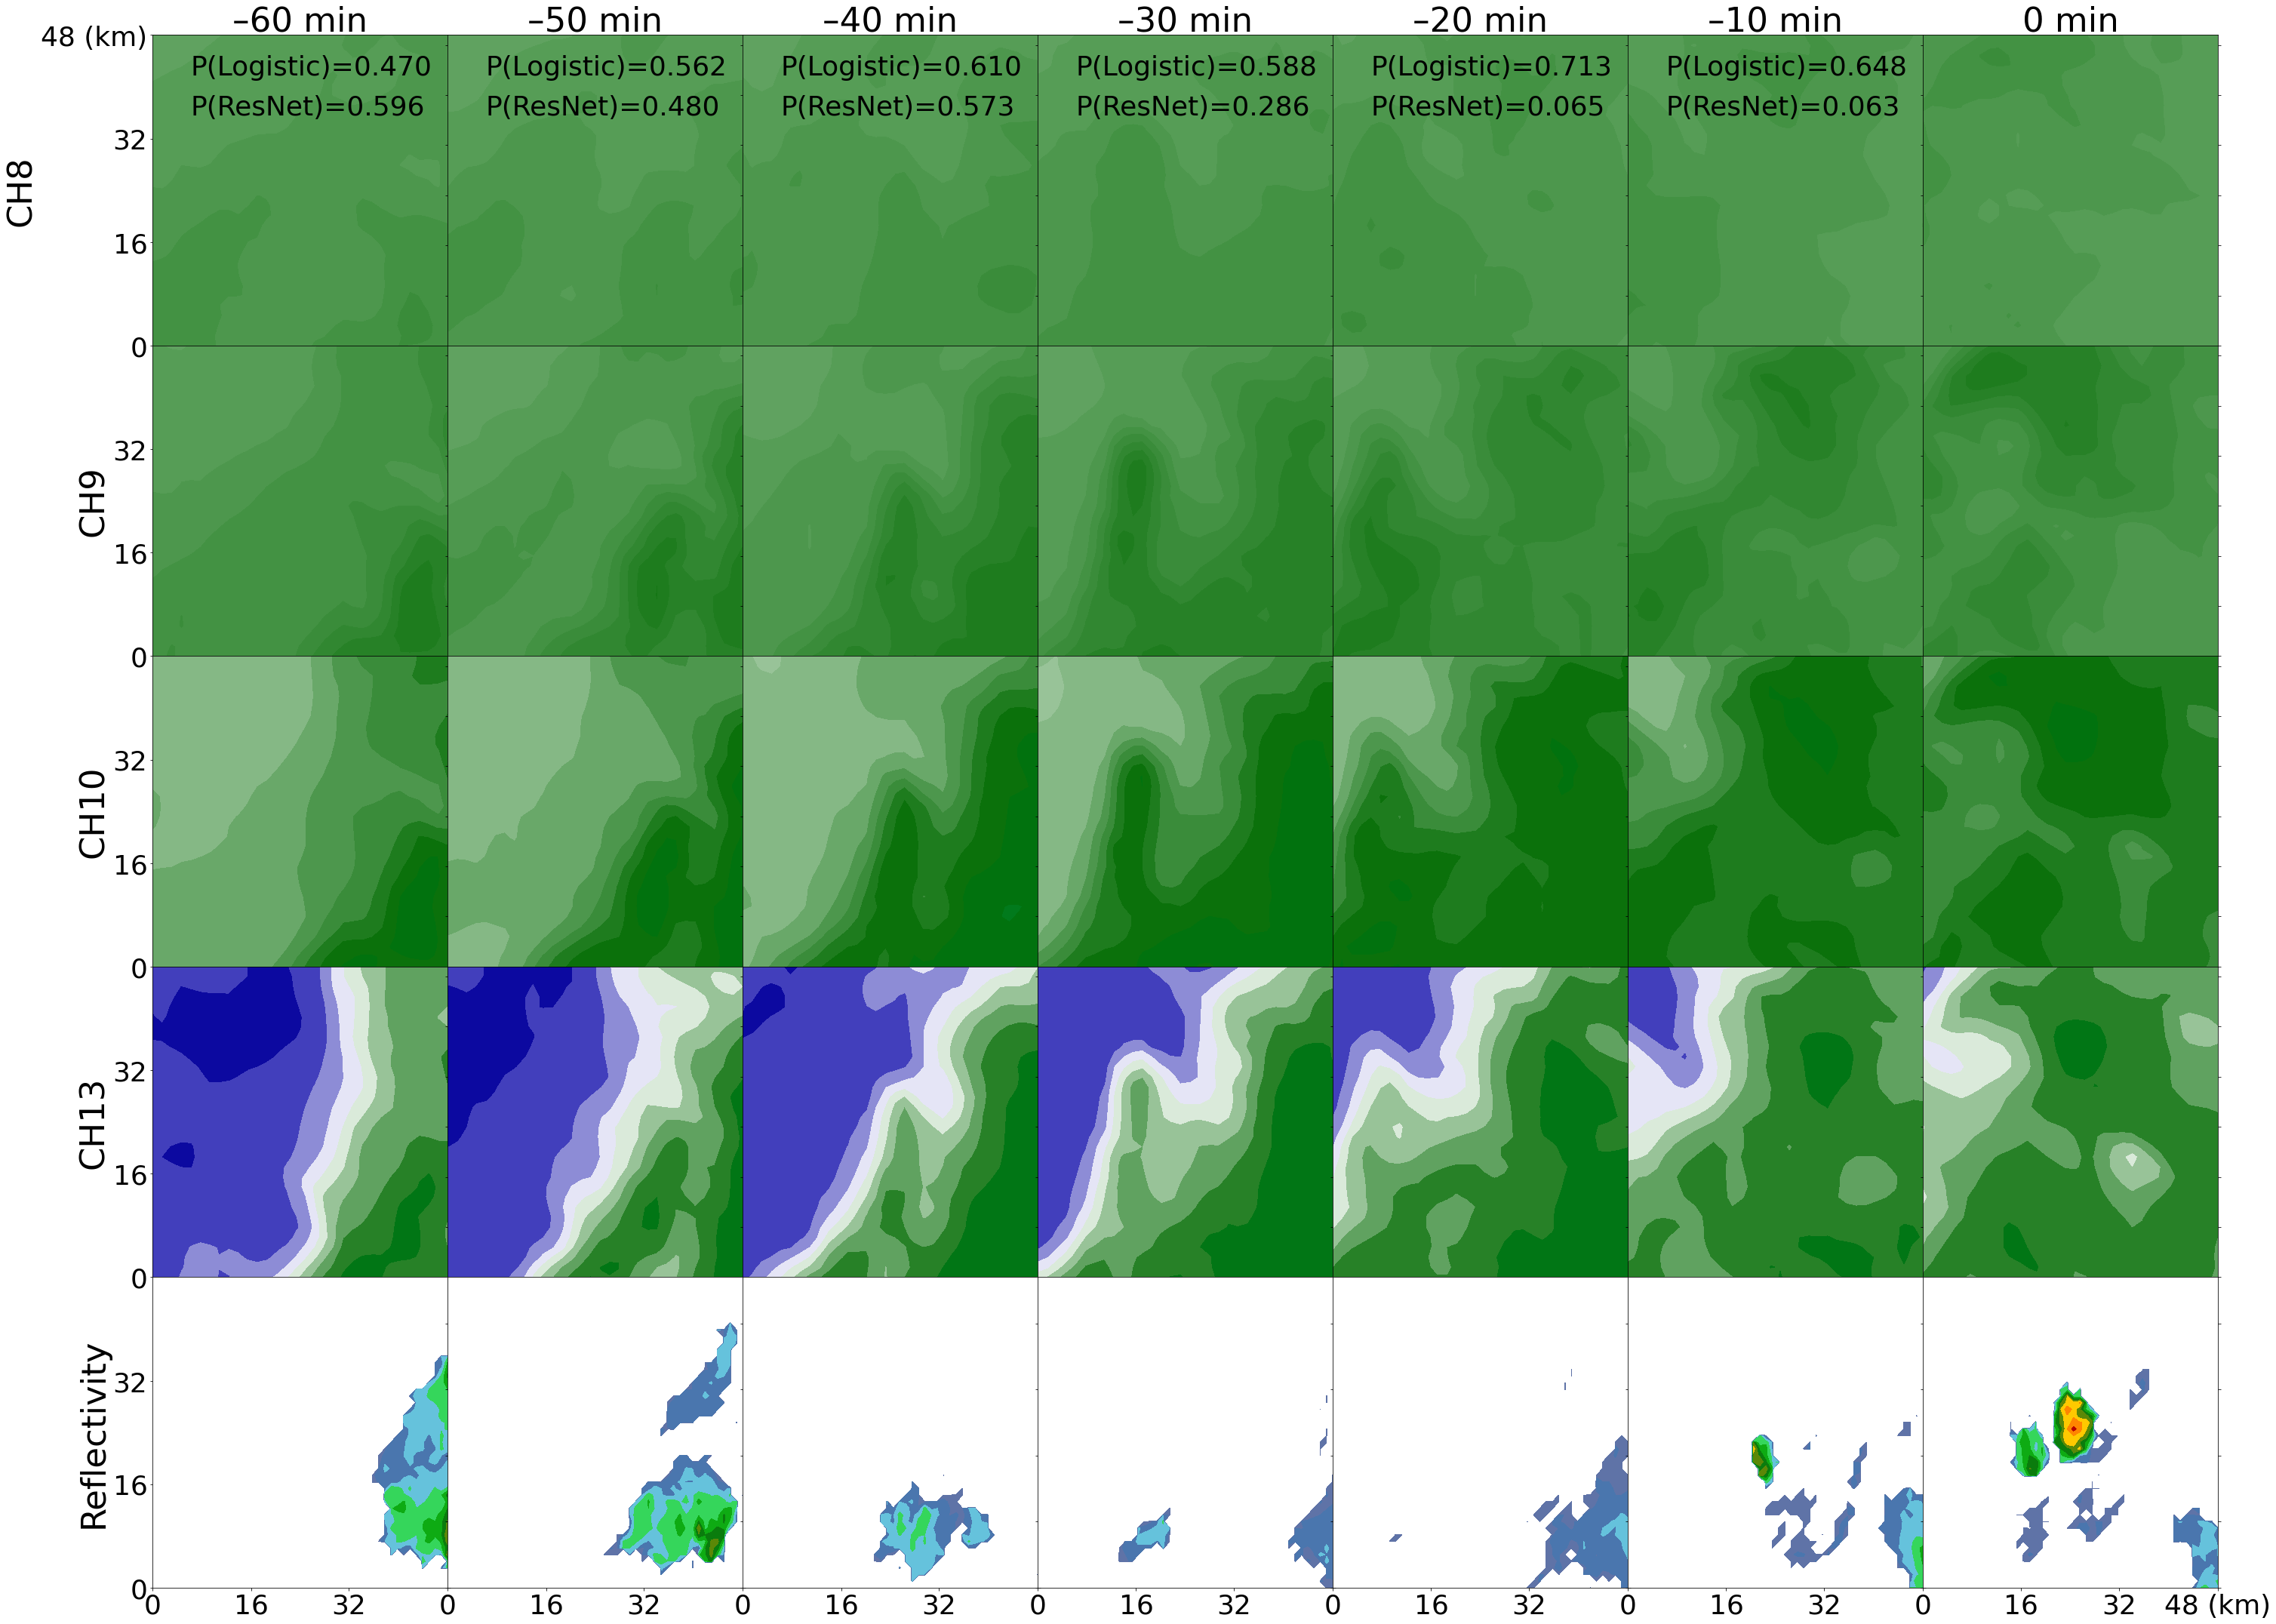

In [122]:
%matplotlib inline

from metpy.plots import colortables
#from metpy.plots import add_timestamp
index=test_lead10_all_indices["worst_miss_indices"][0]
vmin = [205,210,220,195,201,190,190]
#[205.8, 205.9, 205.8, 185.2, 211.7, 200, 199.2]
#test_images_shuffled[index[0:10],:,:,7:14].min() # set min/max plotting range  
vmax = [300,315,315,365,315,385,385] 
#[300,315,315,365,315,385,385] #[292,310,325,365,315,385,385]
#[256.5, 265.9, 273.7, 306.5, 279.4, 326, 327]
#test_images_shuffled[index[0:10],:,:,7:14].max()
wavelength = [6.2, 6.9, 7.3, 8.4, 9.6, 10.3, 11.2]
log_pred = ['0.470', 0.562, '0.610', 0.588, 0.713, 0.648]  #[0.407,0.456,0.344,0.466,0.454,0.839] 
res_pred = [0.596, '0.480', 0.573, 0.286, 0.065, 0.063] #[0.042,0.374,0.567,0.956,0.977,0.999]
ch = [8, 9, 10, 13]
row = 5#0
column = 7
#fig, ax = plt.subplots(3, 7, figsize=(42, 18))
#vmin=vmin[j], vmax=vmax[j]
# Use a colortable/colormap available from MetPy
ctable = ('NWSStormClearReflectivity',-20,0.45)#('NWSStormClearReflectivity', -20, 0.5)
norm, cmap = colortables.get_with_steps(*ctable)     

#wv_norm, wv_cmap = colortables.get_with_range('WVCIMSS_r',210,290)#265)
#[210,290] [220,300] [225,305] [230,335]
#[230,249] [238,255] [242,262] [250,306]
#im.set_cmap(wv_cmap)
#im.set_norm(wv_norm)
#ir_norm, ir_cmap = colortables.get_with_range('ir_drgb_r', 190, 265)
x_index = np.ones(28)*10
y_index = np.ones(28)*38
x_array = np.arange(10,38,1)
y_array = np.arange(10,38,1)

#vmin_all = [210,210,210,165]
#vmax_all = [295,295,295,405]
#vmin_all = [220,220,220,165]
#vmax_all = [305,305,305,405]
vmin_all = 160
vmax_all = 410
#[210,290] [220,300] [225,305] [230,335]
#[230,249] [238,255] [242,262] [250,306]
WV_min = [210, 215, 220, 220]
WV_max = [290, 300, 305, 335]
#[210,290] [220,300] [225,305] [230,335]
fig, ax = plt.subplots(row,column, figsize=(6*column,6*row))
for i in range(row):
    for j in range(column):
        if i < 4:
            #all_images[index,:,:,i].plot(ax=ax.ravel()[i], vmin=vmin, vmax=vmax)#index[i] #vmin=vmin[j], vmax=vmax[j]
            #a = ax[i][j].contourf(test_colorbar, vmin=170, vmax=410, cmap=wv_cmap, N=500)#i*7
            wv_norm, wv_cmap = colortables.get_with_range('WVCIMSS_r',WV_min[i],WV_max[i])
            a = ax[i][6 - j].contourf(np.squeeze(test_images_shuffled[index[10],:,:,ch[i]-8+j*7]), vmin=vmin_all, vmax=vmax_all, \
                                      cmap=wv_cmap, norm=wv_norm, N=500)#, shading="flat", edgecolors='None')#378
    #cmap=wv_cmap, vmin=vmin[j], vmax=vmax[j])#, norm=ir_norm)#, vmin=vmin[j], vmax=vmax[j])#, shading="flat", edgecolors='None', N=45,ylabel='-'+str((j+1)*10)+'0 min') #cmap='seismic'#cpt_convert
            #if j == column:
            #ax[i][j].axis('off')
            if i == 3:
                print(np.min(np.squeeze(test_images_shuffled[index[10],:,:,ch[i]-8+j*7])))
            if j == 0:
                ax[i][j].set_ylabel('CH'+str(ch[i]),fontsize=45)
            if i == 0:
                if j != 6:
                    ax[i][j].text(4, 27, 'P(Logistic)='+str(log_pred[j])+'', fontsize=36)
                    ax[i][j].text(4, 23, 'P(ResNet)='+str(res_pred[j])+'', fontsize=36)
                if j==6:
                    ax[i][j].set_title('0 min',fontsize=45)
                else:
                    ax[i][j].set_title('–'+str((6-j)*10)+' min',fontsize=45)
        else:
            #files[0:31:5]
            processed_file = nc.Dataset(os.path.join(My_dir,files[j*5]))
            dbz = processed_file.variables['MergedReflectivityQCComposite'][:]
            figure = ax[i][j].contourf( 
                                        np.fliplr(dbz[lat_index_1[0][0]:lat_index_0[0][0],lon_index_0[0][0]:lon_index_1[0][0]].T),
                                        norm=norm, cmap=cmap,levels=(0, 5, 10, 15, 20,25,30,35,40,45,50))
            #ax[i][j].plot(x_index,x_array)
            #ax[i][j].plot(y_index,y_array)
            if j == 0:
                ax[i][j].set_ylabel('Reflectivity',fontsize=45)

        #if j == 0:
        #ax[i][j].set_ylabel('-'+str((j+1)*10)+'0 min',fontsize=36)
        #ax[i][j].set_aspect(1)
        ax[i][j].spines['top'].set_visible(True)
        ax[i][j].spines['right'].set_visible(True)
        ax[i][j].spines['bottom'].set_visible(True)
        ax[i][j].spines['left'].set_visible(True)
        #ax[i][j].tick_params(left = False, right = False , labelleft = False ,
        #                labelbottom = False, bottom = False)
        
        if j == 0:
            if i==4:
                ax[i][j].set_yticks((0, 15.66, 31.23))
                ax[i][j].set_yticklabels(('0', '16', '32'), fontsize=36)
                ax[i][j].set_xticks((0, 15.66, 31.23))
                ax[i][j].set_xticklabels(('0', '16', '32'), fontsize=36)
            elif i == 0:
                ax[i][j].set_yticks((0, 10.33, 20.66, 31))
                ax[i][j].set_yticklabels(('0', '16', '32', '48 (km)'), fontsize=36)
            else:
                ax[i][j].set_yticks((0, 10.33, 20.66))
                ax[i][j].set_yticklabels(('0', '16', '32'), fontsize=36)
            if i==4:
                ax[i][j].tick_params(left = True, right = True , labelleft = True ,
                labelbottom = True, bottom = True)
            else:
                ax[i][j].tick_params(left = True, right = True , labelleft = True ,
                labelbottom = False, bottom = False)
        else:
            if i==4:
                if j == 6:
                    ax[i][j].set_xticks((0, 15.66, 31.23, 47))
                    ax[i][j].set_xticklabels(('0', '16', '32', '48 (km)'), fontsize=36)
                else:
                    ax[i][j].set_xticks((0, 15.66, 31.23))
                    ax[i][j].set_xticklabels(('0', '16', '32'), fontsize=36)
                ax[i][j].tick_params(left = True, right = True , labelleft = False ,
                labelbottom = True, bottom = True)
            else: 
                ax[i][j].tick_params(left = True, right = True , labelleft = False ,
                labelbottom = False, bottom = False)
        '''
        else:
              ax[i][j].axis('off')
        cbar = fig.colorbar(a, ax=ax[i][j])#, ticks=range(170, 410, 5))#vmin[j], vmax[j], 5))
        tick_font_size = 20
        cbar.ax.tick_params(labelsize=tick_font_size)
        '''
        #cbar.set_clim(190,320)
        #cbar.set_ticks(np.arange(210,291,20))
        #cbar.set_ticklabels( ('210', '230','250','270','290')) 
        #cbar.set_ticks(np.arange(190,320,20))
        #cbar.set_ticklabels( ('190', '210', '230','250','270','290','310'))        
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)

#plt.savefig('plots/misses_case1_all.png')

In [ ]:
ML provides us with a much more effective approach to learn physcis from the observation directly.

In [123]:
# plot gif
%matplotlib notebook
#inline
#notebook inline
# Enable interactive plot
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
import matplotlib.ticker as mticker

plt.rcParams['font.size'] = '28'
row = 1
column = 5
#fig, ax = plt.subplots(3, 7, figsize=(42, 18))
fig, ax = plt.subplots(row,column, figsize=(6*column,6*row))
fig.suptitle("Lead time = "+str((6-6)*10)+"min",fontsize=48,y=1.05)

def animate(k):
    plt.gca().clear()
    for i in range(column):
        if i < 4:
            wv_norm, wv_cmap = colortables.get_with_range('WVCIMSS_r',WV_min[i],WV_max[i])
            a = ax[i].contourf(np.squeeze(test_images_shuffled[index[10],:,:,ch[i]-8+(6-k)*7]), vmin=vmin_all, vmax=vmax_all, \
                                      cmap=wv_cmap, norm=wv_norm, N=500)
            ax[i].set_title('CH'+str(ch[i]),fontsize=36)
        else:
        #all_images[index,:,:,i].plot(ax=ax.ravel()[i], vmin=vmin, vmax=vmax)
        #a = ax[j].contourf(test_data[index[-i],:,:,j+7*(6-k)], cmap='seismic', 
        #                      shading="flat", edgecolors='None', vmin=vmin_all[j],
        #                      vmax=vmax_all[j], N=100)
            processed_file = nc.Dataset(os.path.join(My_dir,files[k*5]))
            dbz = processed_file.variables['MergedReflectivityQCComposite'][:]
            a = ax[i].contourf( np.fliplr(dbz[lat_index_1[0][0]:lat_index_0[0][0],lon_index_0[0][0]:lon_index_1[0][0]].T),\
                                norm=norm, cmap=cmap,levels=(0, 5, 10, 15, 20,25,30,35,40,45,50))
            ax[i].set_title('Reflectivity',fontsize=36)
        #ax[i].axis('off')
            #if i == 0:
            #    ax[i][j].set_title('ch'+str(j+8),fontsize=36)
        if i==4:
            #ax[i].set_yticks((0, 15.66, 31.23))
            #ax[i].set_yticklabels(('0', '16', '32'), fontsize=36)
            ax[i].set_xticks((0, 15.66, 31.23, 47))
            ax[i].set_xticklabels(('0', '16', '32', '48 (km)'), fontsize=24)
            ax[i].set_yticks((0, 15.66, 31.23, 47))
            ax[i].set_yticklabels(('0', '16', '32', '48'), fontsize=24)
        elif i == 0:
            ax[i].set_yticks((0, 10.33, 20.66, 31))
            ax[i].set_yticklabels(('0', '16', '32', '48 (km)'), fontsize=24)
            ax[i].set_xticks((0, 10.33, 20.66, 31))
            ax[i].set_xticklabels(('0', '16', '32', '48'), fontsize=24)
        else:
            ax[i].set_xticks((0, 10.33, 20.66, 31))
            ax[i].set_xticklabels(('0', '16', '32', '48'), fontsize=24)
            ax[i].set_yticks((0, 10.33, 20.66, 31))
            #ax[i].set_yticklabels(('0', '16', '32', '48'), fontsize=30)
            #ax[i].set_yticklabels(('0', '16', '32'), fontsize=36)
        if i==0:
            ax[i].tick_params(left = True, right = False , labelleft = True,
            labelbottom = True, bottom = True)
        else:
            ax[i].tick_params(left = True, right = False , labelleft = False,
            labelbottom = True, bottom = True)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.5, hspace=-0.5)
    if k < 6:
        fig.suptitle("t = "+str((k-6)*10)+"min [P(ResNet)="+str(res_pred[k])+"]",fontsize=40,y=0.95)
    else:
        fig.suptitle("t = "+str((k-6)*10)+"min ",fontsize=40,y=0.95)
    #return lines, timetext, #a1, lines[1], lines[2],
    #return line1,


ani = FuncAnimation(fig, animate, frames=range(7),
                    interval=2000, repeat=False)
from IPython.display import HTML
HTML(ani.to_jshtml())
ani.save("plots/Worst_MS_animation_BN_test123.gif", writer='imagemagick', dpi = 300)

<IPython.core.display.Javascript object>

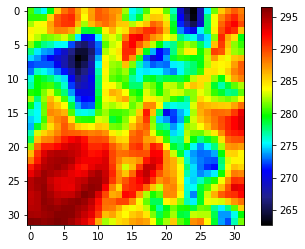

In [18]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# Define the colormap using a list of RGB tuples
color_list = [(0,0,0), (0.13,0.13,0.55), (0,0,1), (0,1,1), (0,1,0), (1,1,0), (1,0.5,0), (1,0,0), (0.5,0,0)]

# Create the colormap
ir_cmap = colors.LinearSegmentedColormap.from_list('IR_Colormap', color_list, N=256)

# Plot an example image using the colormap
#example_image = plt.imread('example_image.png')
plt.imshow(np.squeeze(test_images_shuffled[index[95],:,:,j+i*7]), cmap=ir_cmap)
plt.colorbar()
plt.show()

In [113]:
# For false alarm:
index=test_lead10_all_indices["worst_false_alarm_indices"][0]
import datetime
def time_plus_2h(initial_date):
    return str(datetime.datetime.strptime(initial_date,'%Y-%m-%d %H:%M:%S')+datetime.timedelta(hours=2))
i=73#82
index=test_lead10_all_indices["worst_false_alarm_indices"][0]
lon_center = lon_0[index[i]]
lat_center = lat_0[index[i]]
print(time_plus_2h(str(datetime.datetime.fromtimestamp(date_0[index[i]]))))
print(lon_0[index[i]])
print(lat_0[index[i]])
My_dir = '/glade/scratch/fanda/files/MergedReflectivityQCComposite/25/MergedReflectivityQCComposite/00.50'
testfiles = [f for f in listdir(My_dir) if isfile(join(My_dir, f))]
#testfiles.sort
files = []
for i in testfiles:
    if i[9:15]>'184200' and i[9:15]<'194300':
    #if i[9:15]>'101620' and i[9:15]<'111820':
    #if i[9:15]>'184600' and i[9:15]<'194800':
    #if i[9:15]>'143520' and i[9:15]<'153720':
    #if i[9:15]>'065340' and i[9:15]<'075540':
        files.append(i)
files=sorted(files)
print(len(files))
processed_file=nc.Dataset(os.path.join(My_dir,files[0]))
dbz = processed_file.variables['MergedReflectivityQCComposite'][:]
interval = processed_file.LatGridSpacing
lon_grid, lat_grid = np.meshgrid(np.arange(processed_file.Longitude,processed_file.Longitude+interval*np.shape(dbz)[1],interval),
                                 np.arange(processed_file.Latitude,processed_file.Latitude-interval*np.shape(dbz)[0],-interval))
lat_target_0 = lat_center-0.24#42.75-0.1#34.93#39#34.93 43.23 -98.14 42.75 -97.66
lat_target_1 = lat_center+0.24 #43.23+0.1#35.41#42#35.41+0.01
lon_target_0 = lon_center-0.24#-98.14-0.1#-98.79#-99#-98.79
lon_target_1 = lon_center+0.24#-97.66+0.1#-98.31#-96#-98.31-0.01
lon_1d = np.arange(processed_file.Longitude,processed_file.Longitude+interval*np.shape(dbz)[1],interval)
lat_1d = np.arange(processed_file.Latitude,processed_file.Latitude-interval*np.shape(dbz)[1],-interval)
lat_index_0 = np.where(np.abs(lat_1d-lat_target_0)<0.001)
lat_index_1 = np.where(np.abs(lat_1d-lat_target_1)<0.001)
lon_index_0 = np.where(np.abs(lon_1d-lon_target_0)<0.001)
lon_index_1 = np.where(np.abs(lon_1d-lon_target_1)<0.001)

2021-06-25 19:42:56
-98.02
36.87
31


In [240]:
np.round(Res_target_preds[::-1],3)

array([0.563, 0.6  , 0.625, 0.615, 0.435, 0.993])

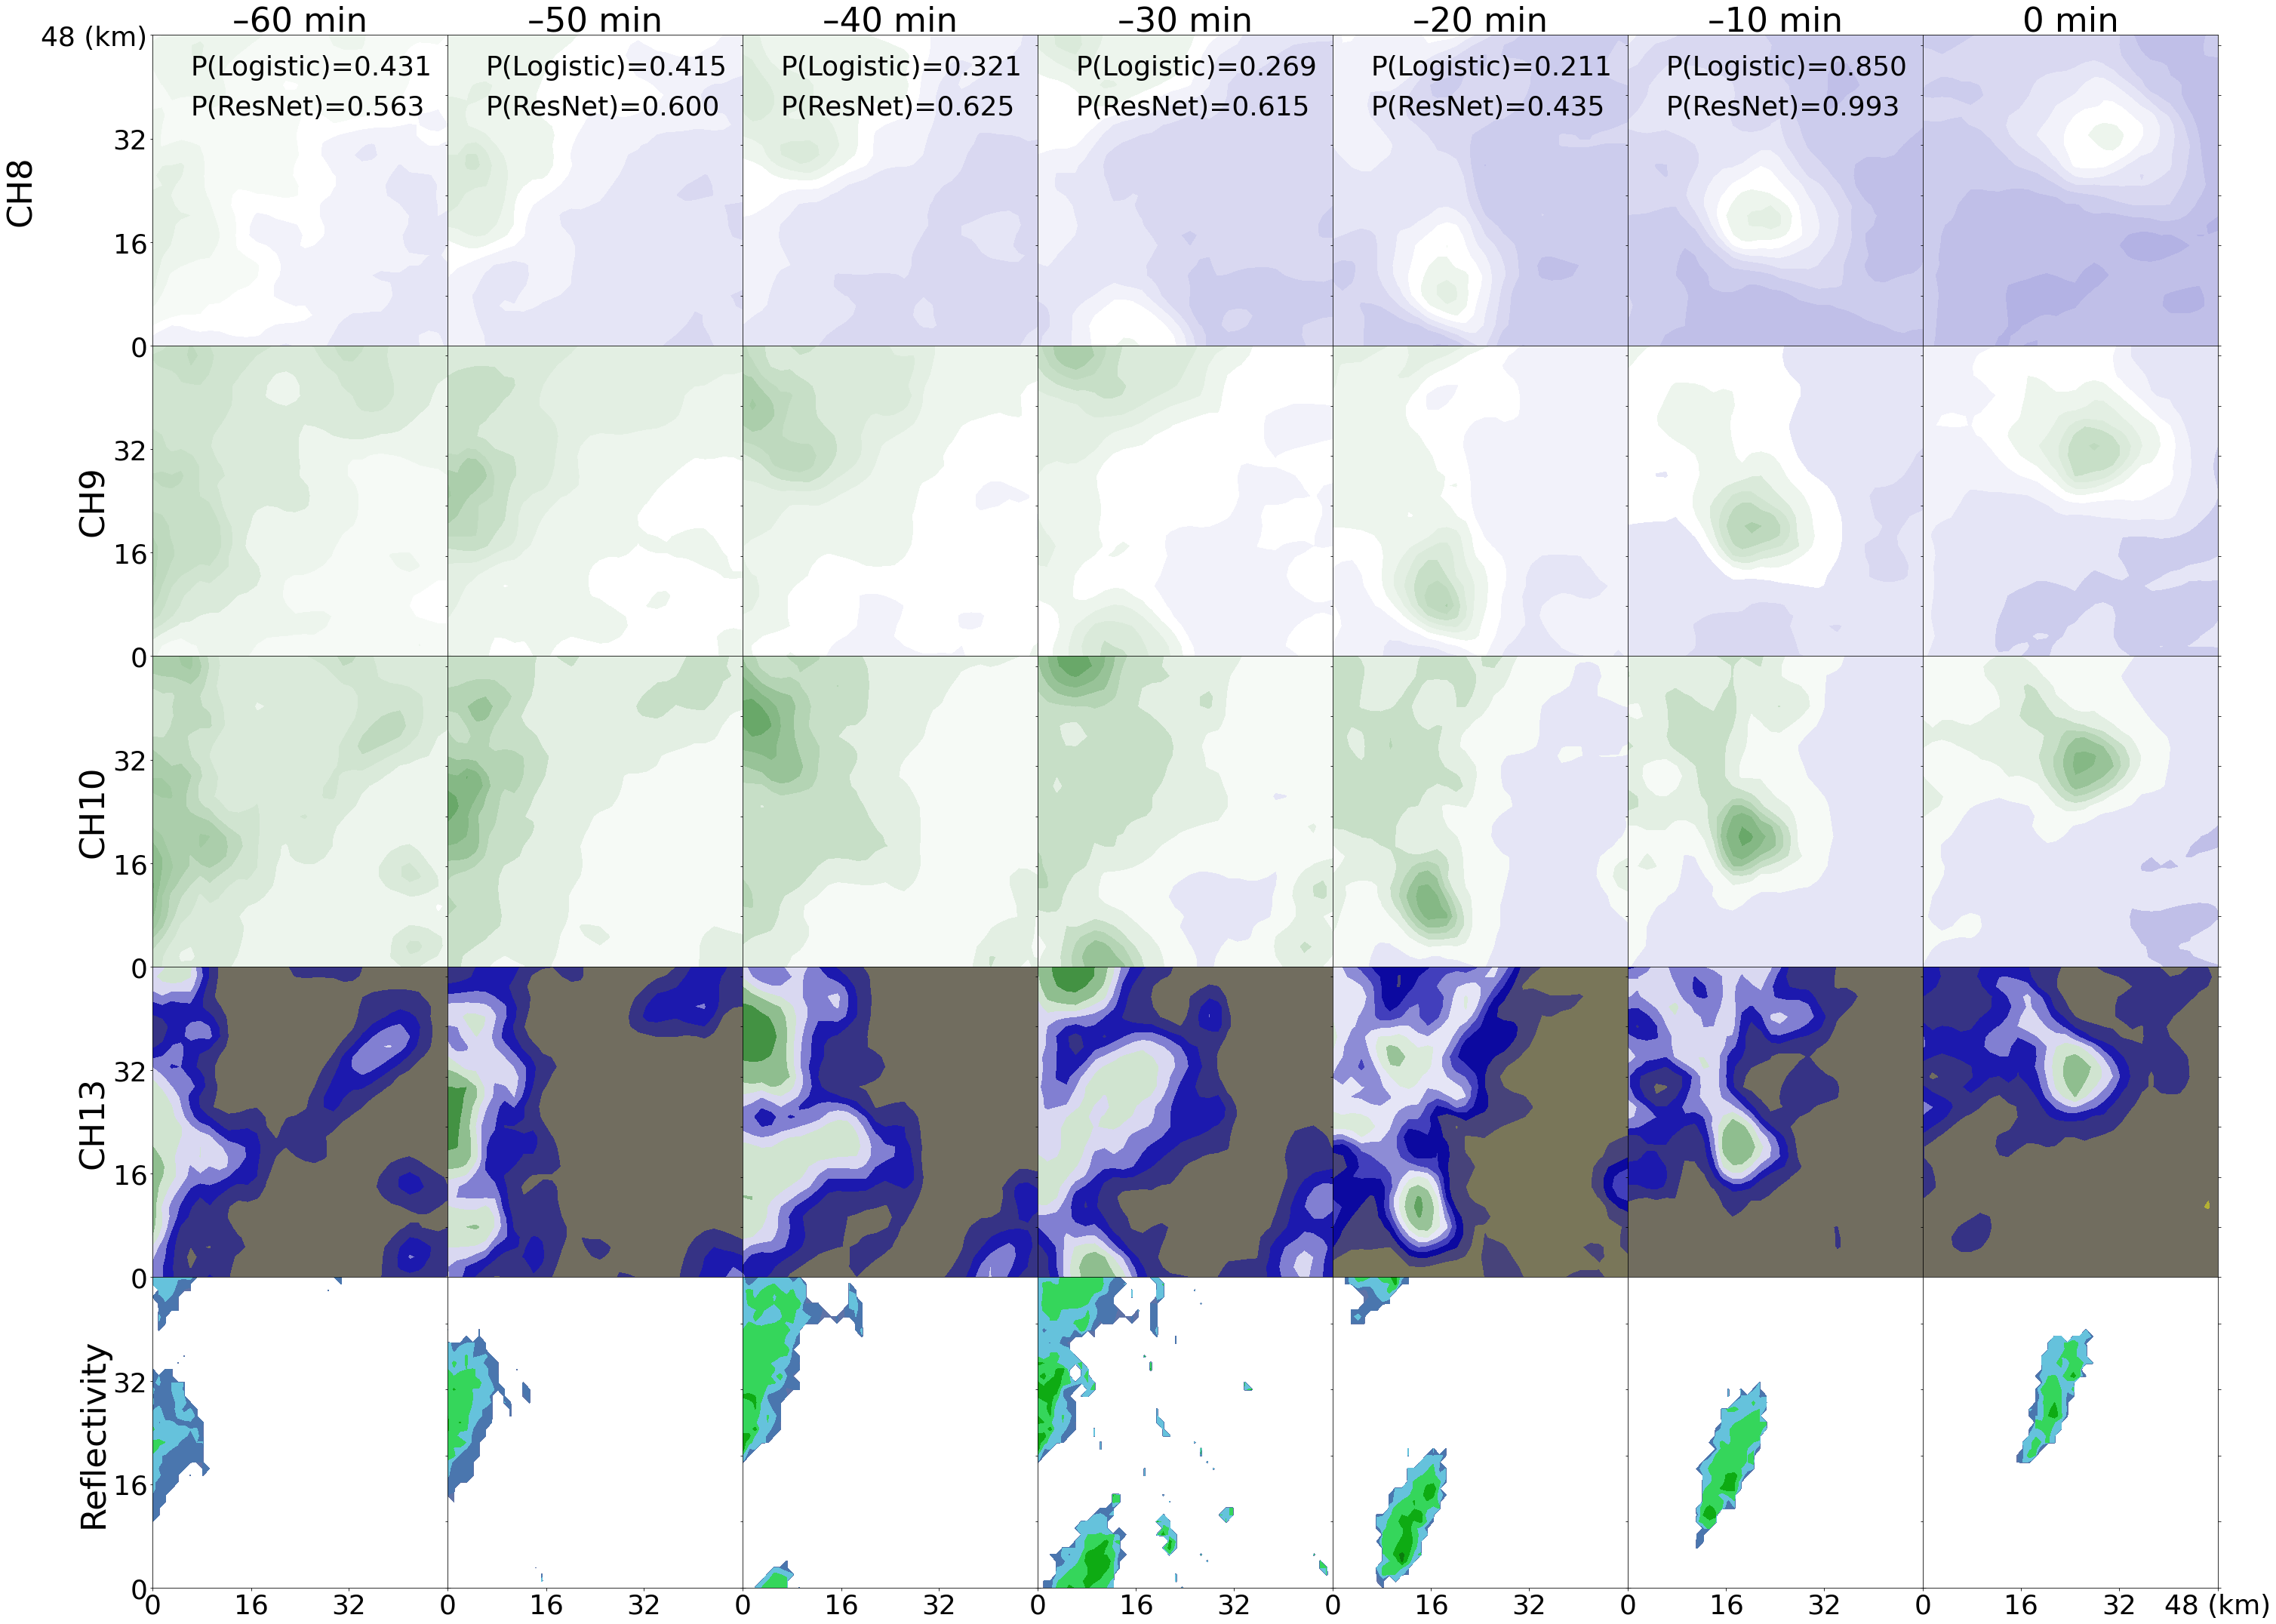

In [116]:
%matplotlib inline
from metpy.plots import colortables
#from metpy.plots import add_timestamp

from metpy.plots import colortables
#from metpy.plots import add_timestamp
index=test_lead10_all_indices["worst_false_alarm_indices"][0]
vmin = [205,210,220,195,201,190,190]
#[205.8, 205.9, 205.8, 185.2, 211.7, 200, 199.2]
#test_images_shuffled[index[0:10],:,:,7:14].min() # set min/max plotting range  
vmax = [300,315,315,365,315,385,385] 
#[300,315,315,365,315,385,385] #[292,310,325,365,315,385,385]
#[256.5, 265.9, 273.7, 306.5, 279.4, 326, 327]
#test_images_shuffled[index[0:10],:,:,7:14].max()
wavelength = [6.2, 6.9, 7.3, 8.4, 9.6, 10.3, 11.2]
log_pred = [0.431, 0.415, 0.321, 0.269, 0.211, '0.850']  #[0.407,0.456,0.344,0.466,0.454,0.839] 
res_pred = [0.563, '0.600', 0.625, 0.615, 0.435, 0.993] #[0.042,0.374,0.567,0.956,0.977,0.999]
ch = [8, 9, 10, 13]
row = 5#0
column = 7
#fig, ax = plt.subplots(3, 7, figsize=(42, 18))
#vmin=vmin[j], vmax=vmax[j]
# Use a colortable/colormap available from MetPy
ctable = ('NWSStormClearReflectivity',-20,0.45)#('NWSStormClearReflectivity', -20, 0.5)
norm, cmap = colortables.get_with_steps(*ctable)     

#wv_norm, wv_cmap = colortables.get_with_range('WVCIMSS_r',210,290)#265)
#[210,290] [220,300] [225,305] [230,335]
#[230,249] [238,255] [242,262] [250,306]
#im.set_cmap(wv_cmap)
#im.set_norm(wv_norm)
#ir_norm, ir_cmap = colortables.get_with_range('ir_drgb_r', 190, 265)
x_index = np.ones(28)*10
y_index = np.ones(28)*38
x_array = np.arange(10,38,1)
y_array = np.arange(10,38,1)

#vmin_all = [210,210,210,165]
#vmax_all = [295,295,295,405]
#vmin_all = [220,220,220,165]
#vmax_all = [305,305,305,405]
vmin_all = 160
vmax_all = 410
#[210,290] [220,300] [225,305] [230,335]
#[230,249] [238,255] [242,262] [250,306]
WV_min = [210, 215, 220, 220]
WV_max = [290, 300, 305, 335]
#[210,290] [220,300] [225,305] [230,335]
fig, ax = plt.subplots(row,column, figsize=(6*column,6*row))
for i in range(row):
    for j in range(column):
        if i < 4:
            #all_images[index,:,:,i].plot(ax=ax.ravel()[i], vmin=vmin, vmax=vmax)#index[i] #vmin=vmin[j], vmax=vmax[j]
            #a = ax[i][j].contourf(test_colorbar, vmin=170, vmax=410, cmap=wv_cmap, N=500)#i*7
            wv_norm, wv_cmap = colortables.get_with_range('WVCIMSS_r',WV_min[i],WV_max[i])
            a = ax[i][6 - j].contourf(np.squeeze(test_images_shuffled[index[73],:,:,ch[i]-8+j*7]), vmin=vmin_all, vmax=vmax_all, \
                                      cmap=wv_cmap, norm=wv_norm, N=500)#, shading="flat", edgecolors='None')#378
    #cmap=wv_cmap, vmin=vmin[j], vmax=vmax[j])#, norm=ir_norm)#, vmin=vmin[j], vmax=vmax[j])#, shading="flat", edgecolors='None', N=45,ylabel='-'+str((j+1)*10)+'0 min') #cmap='seismic'#cpt_convert
            #if j == column:
            #ax[i][j].axis('off')
            if j == 0:
                ax[i][j].set_ylabel('CH'+str(ch[i]),fontsize=45)
            if i == 0:
                if j != 6:
                    ax[i][j].text(4, 27, 'P(Logistic)='+str(log_pred[j])+'', fontsize=36)
                    ax[i][j].text(4, 23, 'P(ResNet)='+str(res_pred[j])+'', fontsize=36)
                if j==6:
                    ax[i][j].set_title('0 min',fontsize=45)
                else:
                    ax[i][j].set_title('–'+str((6-j)*10)+' min',fontsize=45)
        else:
            #files[0:31:5]
            processed_file = nc.Dataset(os.path.join(My_dir,files[j*5]))
            dbz = processed_file.variables['MergedReflectivityQCComposite'][:]
            figure = ax[i][j].contourf( 
                                        np.fliplr(dbz[lat_index_1[0][0]:lat_index_0[0][0],lon_index_0[0][0]:lon_index_1[0][0]].T),
                                        norm=norm, cmap=cmap,levels=(0, 5, 10, 15, 20,25,30,35,40,45,50))
            #ax[i][j].plot(x_index,x_array)
            #ax[i][j].plot(y_index,y_array)
            if j == 0:
                ax[i][j].set_ylabel('Reflectivity',fontsize=45)

        #if j == 0:
        #ax[i][j].set_ylabel('-'+str((j+1)*10)+'0 min',fontsize=36)
        #ax[i][j].set_aspect(1)
        ax[i][j].spines['top'].set_visible(True)
        ax[i][j].spines['right'].set_visible(True)
        ax[i][j].spines['bottom'].set_visible(True)
        ax[i][j].spines['left'].set_visible(True)
        #ax[i][j].tick_params(left = False, right = False , labelleft = False ,
        #                labelbottom = False, bottom = False)
        
        if j == 0:
            if i==4:
                ax[i][j].set_yticks((0, 15.66, 31.23))
                ax[i][j].set_yticklabels(('0', '16', '32'), fontsize=36)
                ax[i][j].set_xticks((0, 15.66, 31.23))
                ax[i][j].set_xticklabels(('0', '16', '32'), fontsize=36)
            elif i == 0:
                ax[i][j].set_yticks((0, 10.33, 20.66, 31))
                ax[i][j].set_yticklabels(('0', '16', '32', '48 (km)'), fontsize=36)
            else:
                ax[i][j].set_yticks((0, 10.33, 20.66))
                ax[i][j].set_yticklabels(('0', '16', '32'), fontsize=36)
            if i==4:
                ax[i][j].tick_params(left = True, right = True , labelleft = True ,
                labelbottom = True, bottom = True)
            else:
                ax[i][j].tick_params(left = True, right = True , labelleft = True ,
                labelbottom = False, bottom = False)
        else:
            if i==4:
                if j == 6:
                    ax[i][j].set_xticks((0, 15.66, 31.23, 47))
                    ax[i][j].set_xticklabels(('0', '16', '32', '48 (km)'), fontsize=36)
                else:
                    ax[i][j].set_xticks((0, 15.66, 31.23))
                    ax[i][j].set_xticklabels(('0', '16', '32'), fontsize=36)
                ax[i][j].tick_params(left = True, right = True , labelleft = False ,
                labelbottom = True, bottom = True)
            else: 
                ax[i][j].tick_params(left = True, right = True , labelleft = False ,
                labelbottom = False, bottom = False)
        '''
        else:
              ax[i][j].axis('off')
        cbar = fig.colorbar(a, ax=ax[i][j])#, ticks=range(170, 410, 5))#vmin[j], vmax[j], 5))
        tick_font_size = 20
        cbar.ax.tick_params(labelsize=tick_font_size)
        '''
        #cbar.set_clim(190,320)
        #cbar.set_ticks(np.arange(210,291,20))
        #cbar.set_ticklabels( ('210', '230','250','270','290')) 
        #cbar.set_ticks(np.arange(190,320,20))
        #cbar.set_ticklabels( ('190', '210', '230','250','270','290','310'))        
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)

#plt.savefig('plots/false_alarms_case1_all.png')

In [120]:
# plot gif
%matplotlib notebook
#inline
#notebook inline
# Enable interactive plot
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
import matplotlib.ticker as mticker

plt.rcParams['font.size'] = '28'
row = 1
column = 5
#fig, ax = plt.subplots(3, 7, figsize=(42, 18))
fig, ax = plt.subplots(row,column, figsize=(6*column,6*row))
fig.suptitle("Lead time = "+str((6-6)*10)+"min",fontsize=48,y=1.05)

def animate(k):
    plt.gca().clear()
    for i in range(column):
        if i < 4:
            wv_norm, wv_cmap = colortables.get_with_range('WVCIMSS_r',WV_min[i],WV_max[i])
            a = ax[i].contourf(np.squeeze(test_images_shuffled[index[73],:,:,ch[i]-8+(6-k)*7]), vmin=vmin_all, vmax=vmax_all, \
                                      cmap=wv_cmap, norm=wv_norm, N=500)
            ax[i].set_title('CH'+str(ch[i]),fontsize=36)
        else:
        #all_images[index,:,:,i].plot(ax=ax.ravel()[i], vmin=vmin, vmax=vmax)
        #a = ax[j].contourf(test_data[index[-i],:,:,j+7*(6-k)], cmap='seismic', 
        #                      shading="flat", edgecolors='None', vmin=vmin_all[j],
        #                      vmax=vmax_all[j], N=100)
            processed_file = nc.Dataset(os.path.join(My_dir,files[k*5]))
            dbz = processed_file.variables['MergedReflectivityQCComposite'][:]
            a = ax[i].contourf( np.fliplr(dbz[lat_index_1[0][0]:lat_index_0[0][0],lon_index_0[0][0]:lon_index_1[0][0]].T),\
                                norm=norm, cmap=cmap,levels=(0, 5, 10, 15, 20,25,30,35,40,45,50))
            ax[i].set_title('Reflectivity',fontsize=36)
        #ax[i].axis('off')
            #if i == 0:
            #    ax[i][j].set_title('ch'+str(j+8),fontsize=36)
        if i==4:
            #ax[i].set_yticks((0, 15.66, 31.23))
            #ax[i].set_yticklabels(('0', '16', '32'), fontsize=36)
            ax[i].set_xticks((0, 15.66, 31.23, 47))
            ax[i].set_xticklabels(('0', '16', '32', '48 (km)'), fontsize=24)
            ax[i].set_yticks((0, 15.66, 31.23, 47))
            ax[i].set_yticklabels(('0', '16', '32', '48'), fontsize=24)
        elif i == 0:
            ax[i].set_yticks((0, 10.33, 20.66, 31))
            ax[i].set_yticklabels(('0', '16', '32', '48 (km)'), fontsize=24)
            ax[i].set_xticks((0, 10.33, 20.66, 31))
            ax[i].set_xticklabels(('0', '16', '32', '48'), fontsize=24)
        else:
            ax[i].set_xticks((0, 10.33, 20.66, 31))
            ax[i].set_xticklabels(('0', '16', '32', '48'), fontsize=24)
            ax[i].set_yticks((0, 10.33, 20.66, 31))
            #ax[i].set_yticklabels(('0', '16', '32', '48'), fontsize=30)
            #ax[i].set_yticklabels(('0', '16', '32'), fontsize=36)
        if i==0:
            ax[i].tick_params(left = True, right = False , labelleft = True,
            labelbottom = True, bottom = True)
        else:
            ax[i].tick_params(left = True, right = False , labelleft = False,
            labelbottom = True, bottom = True)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.5, hspace=-0.5)
    if k < 6:
        fig.suptitle("t = "+str((k-6)*10)+"min [P(ResNet)="+str(res_pred[k])+"]",fontsize=40,y=0.95)
    else:
        fig.suptitle("t = "+str((k-6)*10)+"min ",fontsize=40,y=0.95)
    #return lines, timetext, #a1, lines[1], lines[2],
    #return line1,


ani = FuncAnimation(fig, animate, frames=range(7),
                    interval=2000, repeat=False)
from IPython.display import HTML
HTML(ani.to_jshtml())
ani.save("plots/Worst_FA_animation_BN_test123.gif", writer='imagemagick', dpi = 300)

<IPython.core.display.Javascript object>

In [6]:
# For false alarm:
index=test_lead10_all_indices["best_hit_indices"][0]
import datetime
def time_plus_2h(initial_date):
    return str(datetime.datetime.strptime(initial_date,'%Y-%m-%d %H:%M:%S')+datetime.timedelta(hours=2))
i=63#82
lon_center = lon_0[index[i]]
lat_center = lat_0[index[i]]
print(time_plus_2h(str(datetime.datetime.fromtimestamp(date_0[index[i]]))))
print(lon_0[index[i]])
print(lat_0[index[i]])
My_dir = '/glade/scratch/fanda/files/MergedReflectivityQCComposite/06/MergedReflectivityQCComposite/00.50'
testfiles = [f for f in listdir(My_dir) if isfile(join(My_dir, f))]
#testfiles.sort
files = []
for i in testfiles:
    #if i[9:15]>'180800' and i[9:15]<'190900':
    #if i[9:15]>'101620' and i[9:15]<'111820':
    #if i[9:15]>'184600' and i[9:15]<'194800':
    #if i[9:15]>'143520' and i[9:15]<'153720':
    if i[9:15]>'065500' and i[9:15]<'075700':
        files.append(i)
files=sorted(files)
print(len(files))
processed_file=nc.Dataset(os.path.join(My_dir,files[0]))
dbz = processed_file.variables['MergedReflectivityQCComposite'][:]
interval = processed_file.LatGridSpacing
lon_grid, lat_grid = np.meshgrid(np.arange(processed_file.Longitude,processed_file.Longitude+interval*np.shape(dbz)[1],interval),
                                 np.arange(processed_file.Latitude,processed_file.Latitude-interval*np.shape(dbz)[0],-interval))
lat_target_0 = lat_center-0.24#42.75-0.1#34.93#39#34.93 43.23 -98.14 42.75 -97.66
lat_target_1 = lat_center+0.24 #43.23+0.1#35.41#42#35.41+0.01
lon_target_0 = lon_center-0.24#-98.14-0.1#-98.79#-99#-98.79
lon_target_1 = lon_center+0.24#-97.66+0.1#-98.31#-96#-98.31-0.01
lon_1d = np.arange(processed_file.Longitude,processed_file.Longitude+interval*np.shape(dbz)[1],interval)
lat_1d = np.arange(processed_file.Latitude,processed_file.Latitude-interval*np.shape(dbz)[1],-interval)
lat_index_0 = np.where(np.abs(lat_1d-lat_target_0)<0.001)
lat_index_1 = np.where(np.abs(lat_1d-lat_target_1)<0.001)
lon_index_0 = np.where(np.abs(lon_1d-lon_target_0)<0.001)
lon_index_1 = np.where(np.abs(lon_1d-lon_target_1)<0.001)

2021-06-06 07:56:48
-101.48
35.3
31


In [224]:
np.round(Res_target_preds[::-1],3)

array([0.31 , 0.741, 0.731, 0.824, 0.998, 1.   ])

'\ncbar = fig.colorbar(a, ax=ax.ravel().tolist(),location="bottom",shrink=0.5, extend=\'both\')#, fontsize=20)\ntick_font_size = 30\ncbar.ax.tick_params(labelsize=tick_font_size)\n'

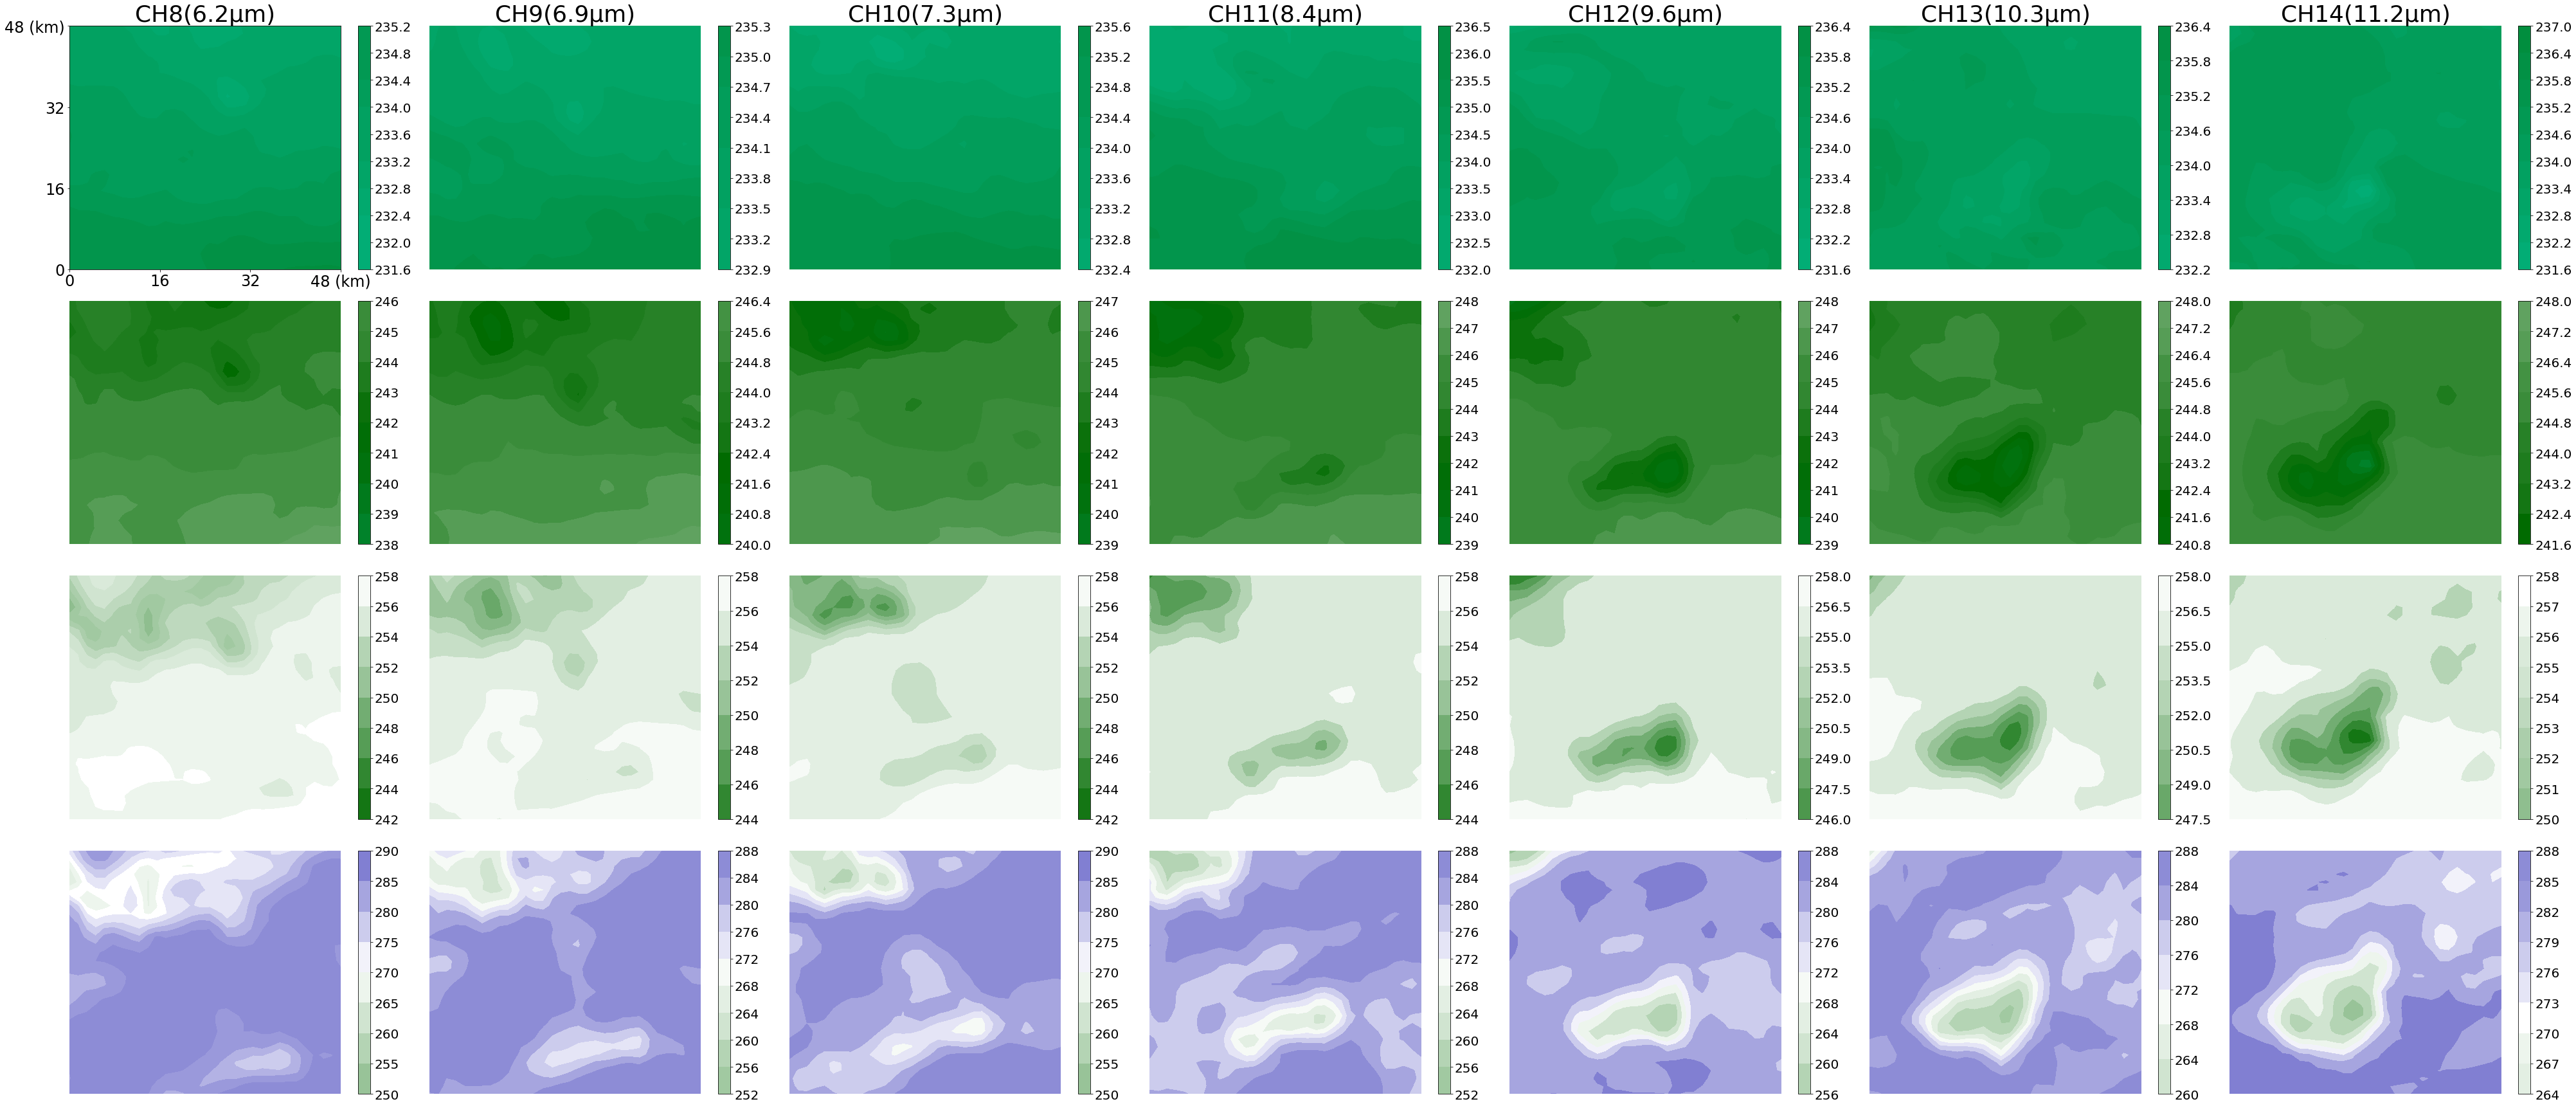

In [104]:
# index: 10 and 94
#matplotlib.rcParams.update({'font.size': 24})
from metpy.plots import colortables
#from metpy.plots import add_timestamp
#index=test_lead10_all_indices["worst_false_alarm_indices"][0]#test_lead10_all_indices["best_hit_indices"][0]
vmin = [205,210,220,195,201,190,190]
#[205.8, 205.9, 205.8, 185.2, 211.7, 200, 199.2]
#test_images_shuffled[index[0:10],:,:,7:14].min() # set min/max plotting range  
vmax = [300,315,315,365,315,385,385] 
#[300,315,315,365,315,385,385] #[292,310,325,365,315,385,385]
#[256.5, 265.9, 273.7, 306.5, 279.4, 326, 327]
#test_images_shuffled[index[0:10],:,:,7:14].max()
wavelength = [6.2, 6.9, 7.3, 8.4, 9.6, 10.3, 11.2]
row = 4#0
column = 7
index=test_lead10_all_indices["best_hit_indices"][0]
#fig, ax = plt.subplots(3, 7, figsize=(42, 18))
#vmin=vmin[j], vmax=vmax[j]
# Use a colortable/colormap available from MetPy
wv_norm, wv_cmap = colortables.get_with_range('WVCIMSS_r', 220, 245)#265)
#im.set_cmap(wv_cmap)
#im.set_norm(wv_norm)
#ir_norm, ir_cmap = colortables.get_with_range('ir_drgb_r', 190, 265)
fig, ax = plt.subplots(row,column, figsize=(8*column,6*row))
vmin_all = [220,220,220,165]
vmax_all = [305,305,305,405]
for i in range(row):
    for j in range(column):
        #all_images[index,:,:,i].plot(ax=ax.ravel()[i], vmin=vmin, vmax=vmax)#index[i] #vmin=vmin[j], vmax=vmax[j]
        #a = ax[i][j].contourf(test_colorbar, vmin=170, vmax=410, cmap=wv_cmap, N=500)#i*7
        a = ax[i][6 - j].contourf(np.squeeze(test_images_shuffled[index[63],:,:,ch[i]-8+j*7]), vmin=vmin_all[i], vmax=vmax_all[i], cmap=wv_cmap, N=500)
        #a = ax[i][j].contourf(np.squeeze(test_images_shuffled[index[73],:,:,j+i*7]),  vmin=160, vmax=375, cmap=wv_cmap, N=500)#, shading="flat", edgecolors='None')#378
#cmap=wv_cmap, vmin=vmin[j], vmax=vmax[j])#, norm=ir_norm)#, vmin=vmin[j], vmax=vmax[j])#, shading="flat", edgecolors='None', N=45,ylabel='-'+str((j+1)*10)+'0 min') #cmap='seismic'#cpt_convert
        #if j == column:
        #ax[i][j].axis('off')
        if i == 0:
            ax[i][j].set_title('CH'+str(j+8)+'('+str(wavelength[j])+'µm)',fontsize=36)
        #if j == 0:
        #ax[i][j].set_ylabel('-'+str((j+1)*10)+'0 min',fontsize=36)
        if i == 0 and j==0:
              ax[i][j].set_xticks((0, 10.33, 20.66, 31))
              ax[i][j].set_xticklabels(('0', '16', '32', '48 (km)'), fontsize=24)
              ax[i][j].set_yticks((0, 10.33, 20.66, 31))
              ax[i][j].set_yticklabels(('0', '16', '32', '48 (km)'), fontsize=24)
        else:
              ax[i][j].axis('off')
        cbar = fig.colorbar(a, ax=ax[i][j])#, ticks=range(170, 410, 5))#vmin[j], vmax[j], 5))
        tick_font_size = 20
        cbar.ax.tick_params(labelsize=tick_font_size)
        #cbar.set_clim(190,320)
        #cbar.set_ticks(np.arange(210,291,20))
        #cbar.set_ticklabels( ('210', '230','250','270','290')) 
        #cbar.set_ticks(np.arange(190,320,20))
        #cbar.set_ticklabels( ('190', '210', '230','250','270','290','310'))  
plt.tight_layout()
#cbar_ax = fig.add_axes([0.1, 0.2, 0.8, 0.6])
#fig.colorbar(a, orientation="h", cax=cbar_ax)
'''
cbar = fig.colorbar(a, ax=ax.ravel().tolist(),location="bottom",shrink=0.5, extend='both')#, fontsize=20)
tick_font_size = 30
cbar.ax.tick_params(labelsize=tick_font_size)
'''
#plt.savefig('plots/hits_case2.png')
#plt.colorbar(im, pad=0, aspect=50, ticks=range(190,351,10))
#plt.colorbar(a)

In [61]:
[210,290] [215,300] [220,305] [225,335]
[230,249] [238,255] [242,262] [250,306]

TypeError: list indices must be integers or slices, not tuple

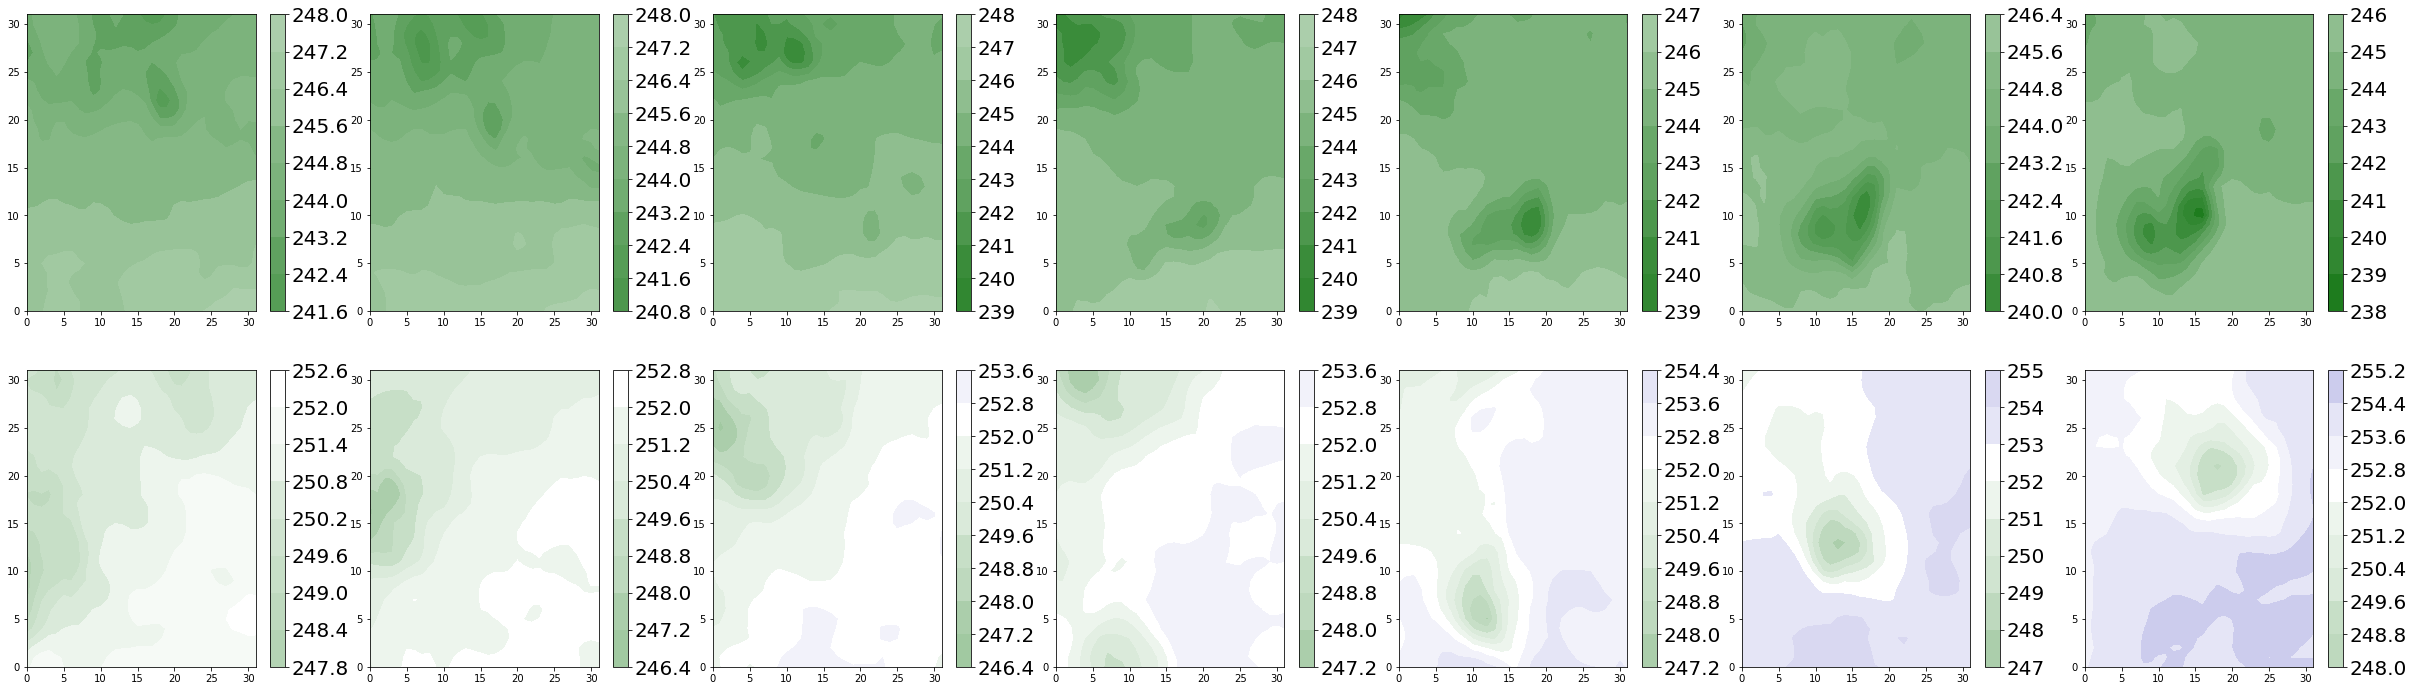

In [74]:
from cpt_convert import loadCPT # Import the CPT convert function
from matplotlib.colors import LinearSegmentedColormap #

wv_norm, wv_cmap = colortables.get_with_range('WVCIMSS_r',215,300)# 195, 265)#265)
#im.set_cmap(wv_cmap)
#im.set_norm(wv_norm)
#ir_norm, ir_cmap = colortables.get_with_range('ir_drgb_r', 190, 265)
x_index = np.ones(28)*10
y_index = np.ones(28)*38
x_array = np.arange(10,38,1)
y_array = np.arange(10,38,1)

#vmin_all = [210,210,210,165]
#vmax_all = [290,290,290,405]
#vmin_all = [210,210,210,165]
#vmax_all = [295,295,295,405]
vmin_all = [165,165]#[230,230,220,165]
vmax_all = [405,405]#[270,270,305,405]
cpt=loadCPT('IR4AVHRR6.cpt')
cpt_convert = LinearSegmentedColormap('cpt', cpt)
ir_norm, ir_cmap = colortables.get_with_range('ir_bd', 150, 357)
row = 2#0
column = 7
fig, ax = plt.subplots(row,column, figsize=(6*column,6*row))
for i in range(row):
    for j in range(column):
        if i == 0:
            #all_images[index,:,:,i].plot(ax=ax.ravel()[i], vmin=vmin, vmax=vmax)#index[i] #vmin=vmin[j], vmax=vmax[j]
            #a = ax[i][j].contourf(test_colorbar, vmin=170, vmax=410, cmap=wv_cmap, N=500)#i*7
            a = ax[i][6 - j].contourf(np.squeeze(test_images_shuffled[test_lead10_all_indices["best_hit_indices"][0][63],:,:,ch[i+1]-8+j*7]), vmin=vmin_all[i], vmax=vmax_all[i],\
                                      cmap=wv_cmap, norm=wv_norm, N=500)
            cbar = fig.colorbar(a, ax=ax[i][6-j])#, ticks=range(170, 410, 5))#vmin[j], vmax[j], 5))
            tick_font_size = 20
            cbar.ax.tick_params(labelsize=tick_font_size)
        else:
            a = ax[i][6 - j].contourf(np.squeeze(test_images_shuffled[test_lead10_all_indices["worst_false_alarm_indices"][0][73],:,:,ch[i]-8+j*7]), vmin=vmin_all[i], vmax=vmax_all[i],\
                                      cmap=wv_cmap, norm=wv_norm, N=500)
            cbar = fig.colorbar(a, ax=ax[i][6-j])#, ticks=range(170, 410, 5))#vmin[j], vmax[j], 5))
            tick_font_size = 20
            cbar.ax.tick_params(labelsize=tick_font_size)

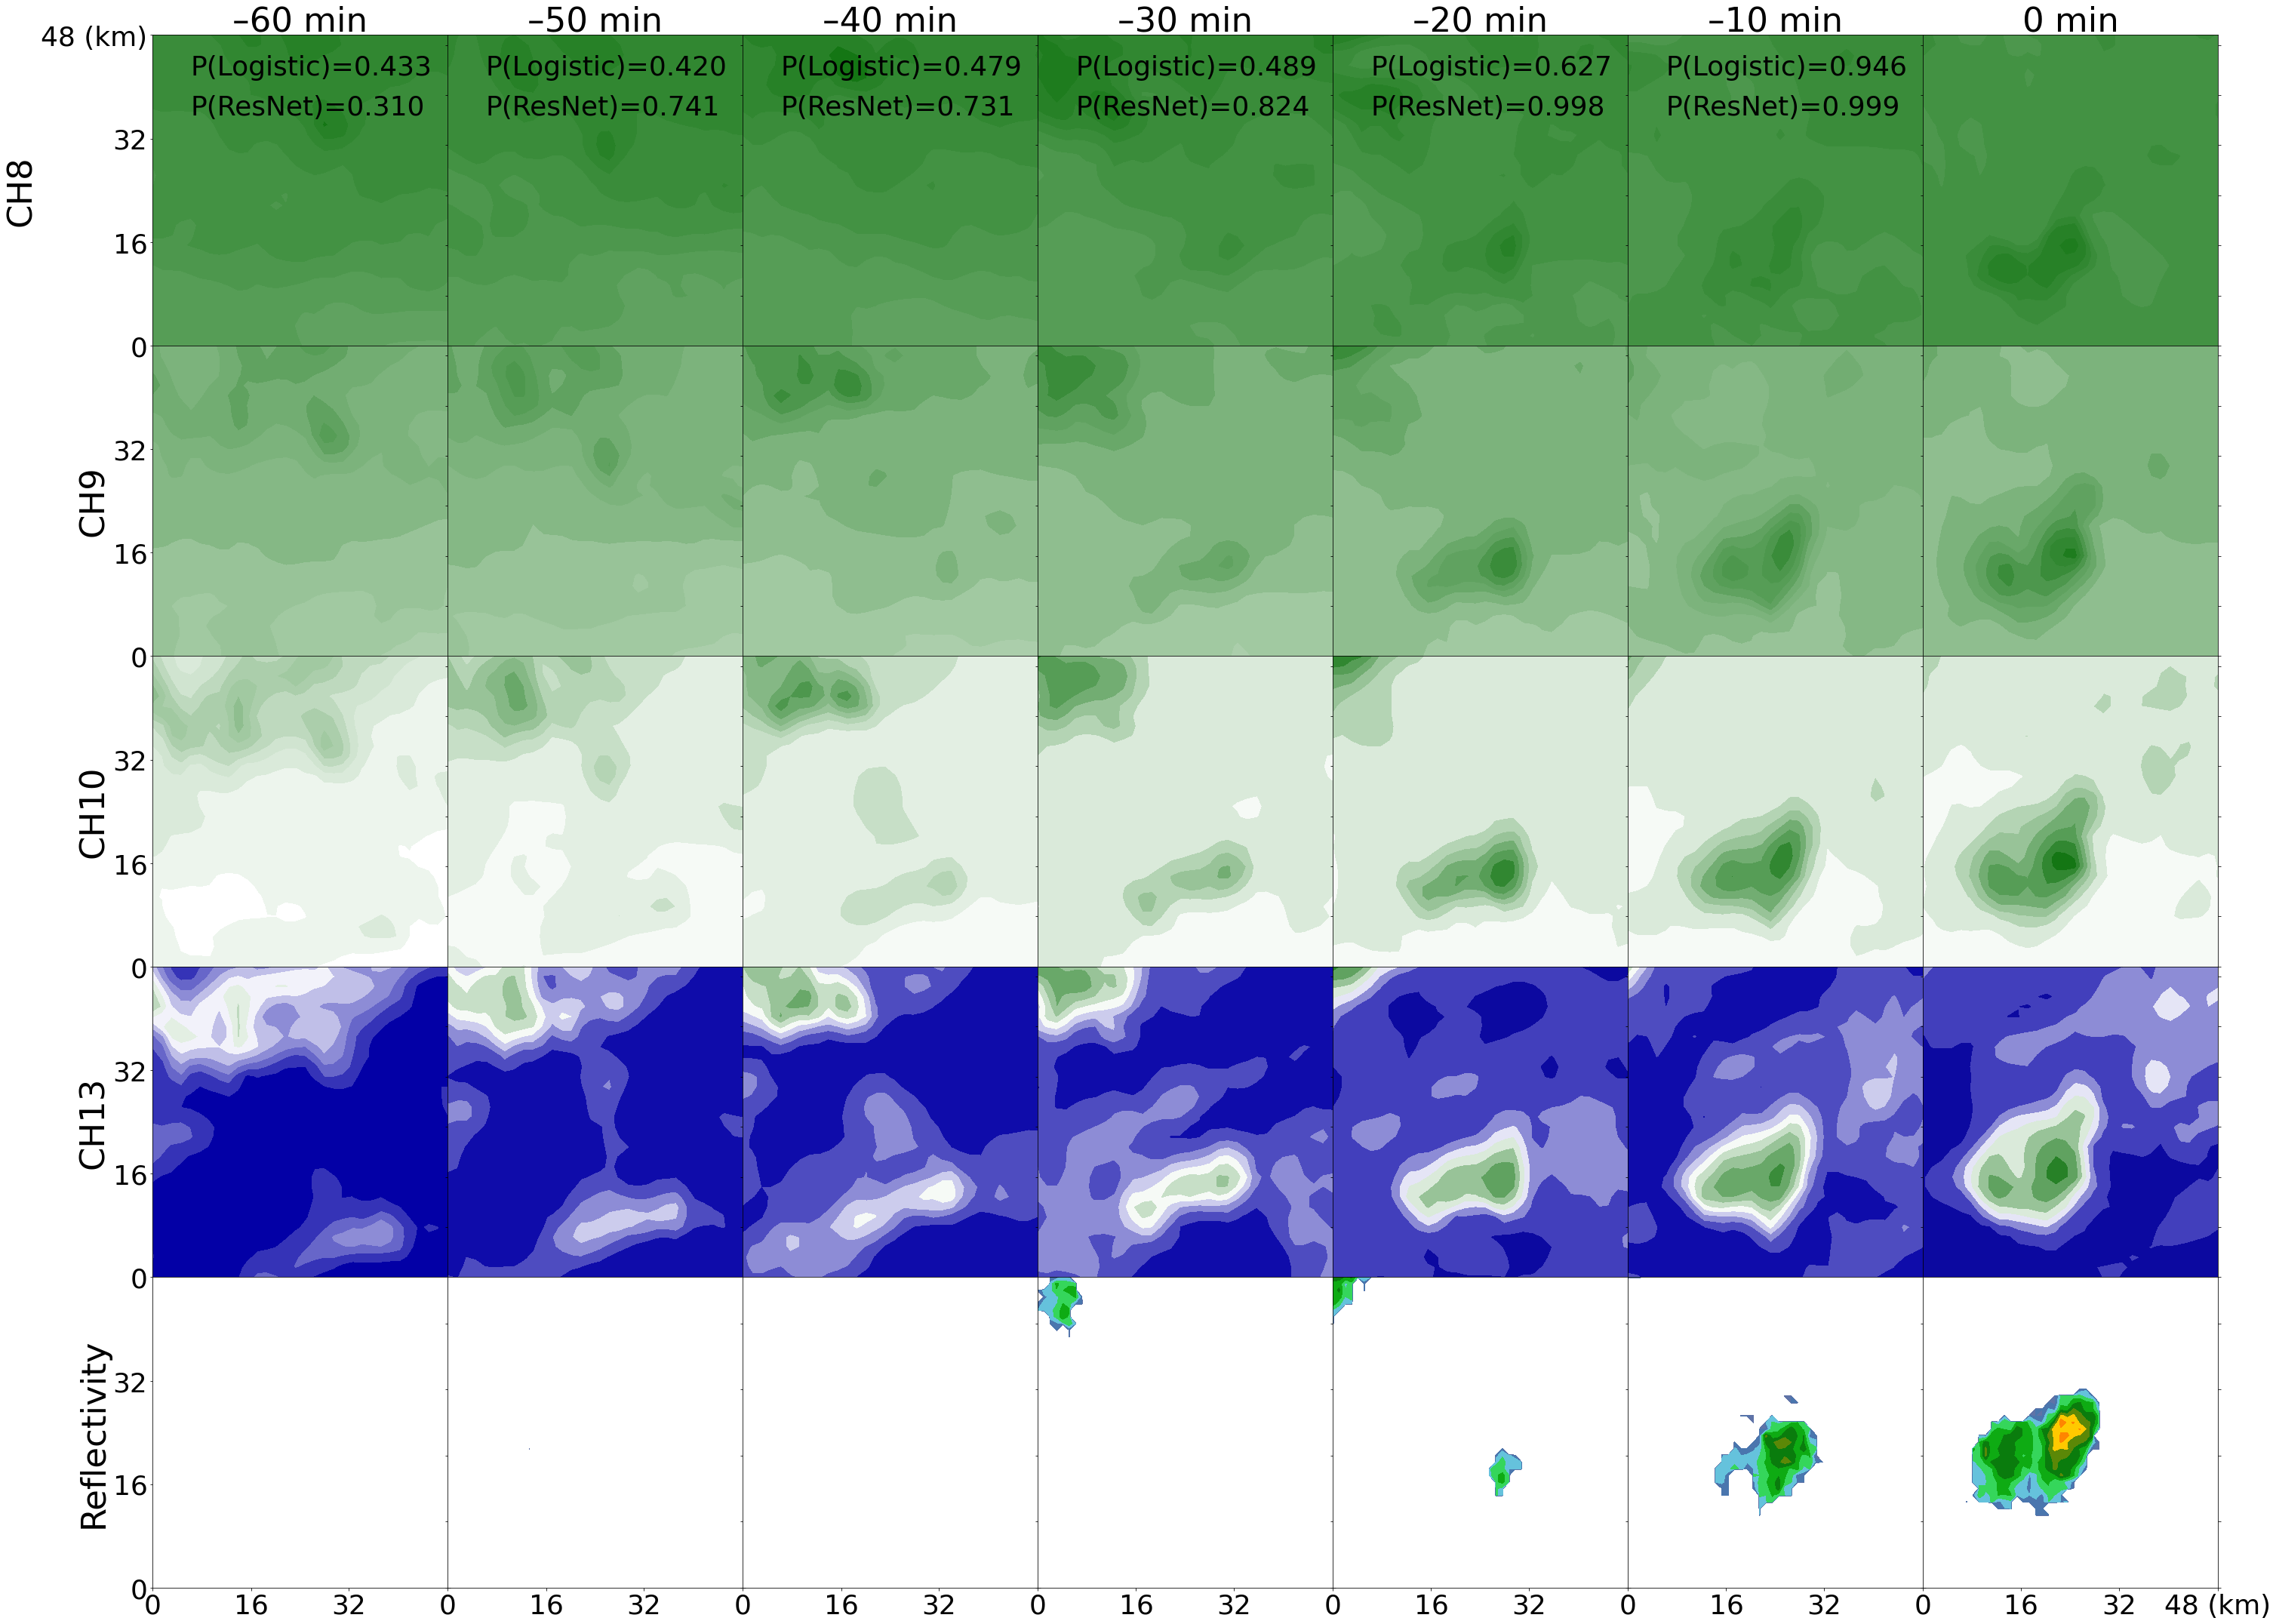

In [8]:
from metpy.plots import colortables
#from metpy.plots import add_timestamp

from metpy.plots import colortables
#from metpy.plots import add_timestamp
index=test_lead10_all_indices["best_hit_indices"][0]
vmin = [205,210,220,195,201,190,190]
#[205.8, 205.9, 205.8, 185.2, 211.7, 200, 199.2]
#test_images_shuffled[index[0:10],:,:,7:14].min() # set min/max plotting range  
vmax = [300,315,315,365,315,385,385] 
#[300,315,315,365,315,385,385] #[292,310,325,365,315,385,385]
#[256.5, 265.9, 273.7, 306.5, 279.4, 326, 327]
#test_images_shuffled[index[0:10],:,:,7:14].max()
wavelength = [6.2, 6.9, 7.3, 8.4, 9.6, 10.3, 11.2]
log_pred = [0.433, '0.420', 0.479, 0.489, 0.627, 0.946]#[0.246,0.366,0.462,0.509,0.773,0.935]  #[0.407,0.456,0.344,0.466,0.454,0.839] 
res_pred = ['0.310' , 0.741, 0.731, 0.824, 0.998, 0.999]#[0.378,0.729,0.824,0.842,0.922,0.999] #[0.042,0.374,0.567,0.956,0.977,0.999]
ch = [8, 9, 10, 13]
row = 5#0
column = 7
#fig, ax = plt.subplots(3, 7, figsize=(42, 18))
#vmin=vmin[j], vmax=vmax[j]
# Use a colortable/colormap available from MetPy
ctable = ('NWSStormClearReflectivity',-20,0.45)#('NWSStormClearReflectivity', -20, 0.5)
norm, cmap = colortables.get_with_steps(*ctable)     

#wv_norm, wv_cmap = colortables.get_with_range('WVCIMSS_r',210,290)# 195, 265)#265)
#im.set_cmap(wv_cmap)
#im.set_norm(wv_norm)
#ir_norm, ir_cmap = colortables.get_with_range('ir_drgb_r', 190, 265)
x_index = np.ones(28)*10
y_index = np.ones(28)*38
x_array = np.arange(10,38,1)
y_array = np.arange(10,38,1)

#vmin_all = [210,210,210,165]
#vmax_all = [290,290,290,405]
#vmin_all = [210,210,210,165]
#vmax_all = [295,295,295,405]
vmin_all = 160
vmax_all = 410
WV_min = [210, 215, 220, 220]
WV_max = [290, 300, 305, 335]
fig, ax = plt.subplots(row,column, figsize=(6*column,6*row))
for i in range(row):
    for j in range(column):
        if i < 4:
            #all_images[index,:,:,i].plot(ax=ax.ravel()[i], vmin=vmin, vmax=vmax)#index[i] #vmin=vmin[j], vmax=vmax[j]
            #a = ax[i][j].contourf(test_colorbar, vmin=170, vmax=410, cmap=wv_cmap, N=500)#i*7
            wv_norm, wv_cmap = colortables.get_with_range('WVCIMSS_r',WV_min[i],WV_max[i])
            a = ax[i][6 - j].contourf(np.squeeze(test_images_shuffled[index[63],:,:,ch[i]-8+j*7]), vmin=vmin_all, vmax=vmax_all,\
                                      cmap=wv_cmap, norm=wv_norm, N=500)#, shading="flat", edgecolors='None')#378
    #cmap=wv_cmap, vmin=vmin[j], vmax=vmax[j])#, norm=ir_norm)#, vmin=vmin[j], vmax=vmax[j])#, shading="flat", edgecolors='None', N=45,ylabel='-'+str((j+1)*10)+'0 min') #cmap='seismic'#cpt_convert
            #if j == column:
            #ax[i][j].axis('off')
            if j == 0:
                ax[i][j].set_ylabel('CH'+str(ch[i]),fontsize=45)
            if i == 0:
                if j != 6:
                    ax[i][j].text(4, 27, 'P(Logistic)='+str(log_pred[j])+'', fontsize=36)
                    ax[i][j].text(4, 23, 'P(ResNet)='+str(res_pred[j])+'', fontsize=36)
                if j==6:
                    ax[i][j].set_title('0 min',fontsize=45)
                else:
                    ax[i][j].set_title('–'+str((6-j)*10)+' min',fontsize=45)
        else:
            #files[0:31:5]
            processed_file = nc.Dataset(os.path.join(My_dir,files[j*5]))
            dbz = processed_file.variables['MergedReflectivityQCComposite'][:]
            figure = ax[i][j].contourf( 
                                        np.fliplr(dbz[lat_index_1[0][0]:lat_index_0[0][0],lon_index_0[0][0]:lon_index_1[0][0]].T),
                                        norm=norm, cmap=cmap,levels=(0, 5, 10, 15, 20,25,30,35,40,45,50))
            #ax[i][j].plot(x_index,x_array)
            #ax[i][j].plot(y_index,y_array)
            if j == 0:
                ax[i][j].set_ylabel('Reflectivity',fontsize=45)

        #if j == 0:
        #ax[i][j].set_ylabel('-'+str((j+1)*10)+'0 min',fontsize=36)
        #ax[i][j].set_aspect(1)
        ax[i][j].spines['top'].set_visible(True)
        ax[i][j].spines['right'].set_visible(True)
        ax[i][j].spines['bottom'].set_visible(True)
        ax[i][j].spines['left'].set_visible(True)
        #ax[i][j].tick_params(left = False, right = False , labelleft = False ,
        #                labelbottom = False, bottom = False)
        
        if j == 0:
            if i==4:
                ax[i][j].set_yticks((0, 15.66, 31.23))
                ax[i][j].set_yticklabels(('0', '16', '32'), fontsize=36)
                ax[i][j].set_xticks((0, 15.66, 31.23))
                ax[i][j].set_xticklabels(('0', '16', '32'), fontsize=36)
            elif i == 0:
                ax[i][j].set_yticks((0, 10.33, 20.66, 31))
                ax[i][j].set_yticklabels(('0', '16', '32', '48 (km)'), fontsize=36)
            else:
                ax[i][j].set_yticks((0, 10.33, 20.66))
                ax[i][j].set_yticklabels(('0', '16', '32'), fontsize=36)
            if i==4:
                ax[i][j].tick_params(left = True, right = True , labelleft = True ,
                labelbottom = True, bottom = True)
            else:
                ax[i][j].tick_params(left = True, right = True , labelleft = True ,
                labelbottom = False, bottom = False)
        else:
            if i==4:
                if j == 6:
                    ax[i][j].set_xticks((0, 15.66, 31.23, 47))
                    ax[i][j].set_xticklabels(('0', '16', '32', '48 (km)'), fontsize=36)
                else:
                    ax[i][j].set_xticks((0, 15.66, 31.23))
                    ax[i][j].set_xticklabels(('0', '16', '32'), fontsize=36)
                ax[i][j].tick_params(left = True, right = True , labelleft = False ,
                labelbottom = True, bottom = True)
            else: 
                ax[i][j].tick_params(left = True, right = True , labelleft = False ,
                labelbottom = False, bottom = False)
        '''
        else:
              ax[i][j].axis('off')
        cbar = fig.colorbar(a, ax=ax[i][j])#, ticks=range(170, 410, 5))#vmin[j], vmax[j], 5))
        tick_font_size = 20
        cbar.ax.tick_params(labelsize=tick_font_size)
        '''
        #cbar.set_clim(190,320)
        #cbar.set_ticks(np.arange(210,291,20))
        #cbar.set_ticklabels( ('210', '230','250','270','290')) 
        #cbar.set_ticks(np.arange(190,320,20))
        #cbar.set_ticklabels( ('190', '210', '230','250','270','290','310'))        
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
#plt.savefig('plots/hits_case3_new_all.png')

In [89]:
res_pred

['0.310', 0.741, 0.731, 0.824, 0.998, 0.999]

In [25]:
dbz_all=np.zeros((7,2700,5900))
for i in range(7):
    processed_file = nc.Dataset(os.path.join(My_dir,files[i*5]))
    dbz_all[i,:,:] = processed_file.variables['MergedReflectivityQCComposite'][:]

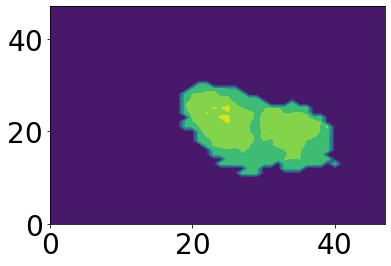

In [59]:
plt.contourf(dbz_all[6,lat_index_1[0][0]:lat_index_0[0][0],lon_index_0[0][0]:lon_index_1[0][0]].T)

In [36]:
np.max(dbz_all[4,:,:])

60.0

In [40]:
np.fliplr(dbz_all[0, lat_index_1[0][0]:lat_index_0[0][0],lon_index_0[0][0]:lon_index_1[0][0]].T).shape

(48, 48)

In [42]:
for i in range(5):
    print(i)

0
1
2
3
4


In [112]:
%matplotlib notebook
#inline
#notebook inline
# Enable interactive plot
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
import matplotlib.ticker as mticker

plt.rcParams['font.size'] = '28'
row = 1
column = 5
#fig, ax = plt.subplots(3, 7, figsize=(42, 18))
fig, ax = plt.subplots(row,column, figsize=(6*column,6*row))
fig.suptitle("Lead time = "+str((6-6)*10)+"min",fontsize=48,y=1.05)

def animate(k):
    plt.gca().clear()
    for i in range(column):
        if i < 4:
            wv_norm, wv_cmap = colortables.get_with_range('WVCIMSS_r',WV_min[i],WV_max[i])
            a = ax[i].contourf(np.squeeze(test_images_shuffled[index[63],:,:,ch[i]-8+(6-k)*7]), vmin=vmin_all, vmax=vmax_all,\
                                          cmap=wv_cmap, norm=wv_norm, N=500)
            ax[i].set_title('CH'+str(ch[i]),fontsize=36)
        else:
        #all_images[index,:,:,i].plot(ax=ax.ravel()[i], vmin=vmin, vmax=vmax)
        #a = ax[j].contourf(test_data[index[-i],:,:,j+7*(6-k)], cmap='seismic', 
        #                      shading="flat", edgecolors='None', vmin=vmin_all[j],
        #                      vmax=vmax_all[j], N=100)
            processed_file = nc.Dataset(os.path.join(My_dir,files[k*5]))
            dbz = processed_file.variables['MergedReflectivityQCComposite'][:]
            a = ax[i].contourf( np.fliplr(dbz[lat_index_1[0][0]:lat_index_0[0][0],lon_index_0[0][0]:lon_index_1[0][0]].T),\
                                norm=norm, cmap=cmap,levels=(0, 5, 10, 15, 20,25,30,35,40,45,50))
            ax[i].set_title('Reflectivity',fontsize=36)
        #ax[i].axis('off')
            #if i == 0:
            #    ax[i][j].set_title('ch'+str(j+8),fontsize=36)
        if i==4:
            #ax[i].set_yticks((0, 15.66, 31.23))
            #ax[i].set_yticklabels(('0', '16', '32'), fontsize=36)
            ax[i].set_xticks((0, 15.66, 31.23, 47))
            ax[i].set_xticklabels(('0', '16', '32', '48 (km)'), fontsize=24)
            ax[i].set_yticks((0, 15.66, 31.23, 47))
            ax[i].set_yticklabels(('0', '16', '32', '48'), fontsize=24)
        elif i == 0:
            ax[i].set_yticks((0, 10.33, 20.66, 31))
            ax[i].set_yticklabels(('0', '16', '32', '48 (km)'), fontsize=24)
            ax[i].set_xticks((0, 10.33, 20.66, 31))
            ax[i].set_xticklabels(('0', '16', '32', '48'), fontsize=24)
        else:
            ax[i].set_xticks((0, 10.33, 20.66, 31))
            ax[i].set_xticklabels(('0', '16', '32', '48'), fontsize=24)
            ax[i].set_yticks((0, 10.33, 20.66, 31))
            #ax[i].set_yticklabels(('0', '16', '32', '48'), fontsize=30)
            #ax[i].set_yticklabels(('0', '16', '32'), fontsize=36)
        if i==0:
            ax[i].tick_params(left = True, right = False , labelleft = True,
            labelbottom = True, bottom = True)
        else:
            ax[i].tick_params(left = True, right = False , labelleft = False,
            labelbottom = True, bottom = True)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.5, hspace=-0.5)
    if k < 6:
        fig.suptitle("t = "+str((k-6)*10)+"min [P(ResNet)="+str(res_pred[k])+"]",fontsize=40,y=0.95)
    else:
        fig.suptitle("t = "+str((k-6)*10)+"min ",fontsize=40,y=0.95)
    #return lines, timetext, #a1, lines[1], lines[2],
    #return line1,


ani = FuncAnimation(fig, animate, frames=range(7),
                    interval=2000, repeat=False)
from IPython.display import HTML
HTML(ani.to_jshtml())
ani.save("plots/Best_Hits_animation_BN_test123.gif", writer='imagemagick', dpi = 300)
'''
for i in range(row):
    for j in range(column):
        if i < 4:
            #all_images[index,:,:,i].plot(ax=ax.ravel()[i], vmin=vmin, vmax=vmax)#index[i] #vmin=vmin[j], vmax=vmax[j]
            #a = ax[i][j].contourf(test_colorbar, vmin=170, vmax=410, cmap=wv_cmap, N=500)#i*7
            wv_norm, wv_cmap = colortables.get_with_range('WVCIMSS_r',WV_min[i],WV_max[i])
            a = ax[i][6 - j].contourf(np.squeeze(test_images_shuffled[index[63],:,:,ch[i]-8+j*7]), vmin=vmin_all, vmax=vmax_all,\
                                      cmap=wv_cmap, norm=wv_norm, N=500)#, shading="flat", edgecolors='None')#378
    #cmap=wv_cmap, vmin=vmin[j], vmax=vmax[j])#, norm=ir_norm)#, vmin=vmin[j], vmax=vmax[j])#, shading="flat", edgecolors='None', N=45,ylabel='-'+str((j+1)*10)+'0 min') #cmap='seismic'#cpt_convert
            #if j == column:
            #ax[i][j].axis('off')
            if j == 0:
                ax[i][j].set_ylabel('CH'+str(ch[i]),fontsize=45)
            if i == 0:
                if j != 6:
                    ax[i][j].text(4, 27, 'P(Logistic)='+str(log_pred[j])+'', fontsize=36)
                    ax[i][j].text(4, 23, 'P(ResNet)='+str(res_pred[j])+'', fontsize=36)
                if j==6:
                    ax[i][j].set_title('0 min',fontsize=45)
                else:
                    ax[i][j].set_title('–'+str((6-j)*10)+' min',fontsize=45)
        else:
            #files[0:31:5]
            processed_file = nc.Dataset(os.path.join(My_dir,files[j*5]))
            dbz = processed_file.variables['MergedReflectivityQCComposite'][:]
            figure = ax[i][j].contourf( 
                                        np.fliplr(dbz[lat_index_1[0][0]:lat_index_0[0][0],lon_index_0[0][0]:lon_index_1[0][0]].T),
                                        norm=norm, cmap=cmap,levels=(0, 5, 10, 15, 20,25,30,35,40,45,50))
            #ax[i][j].plot(x_index,x_array)
            #ax[i][j].plot(y_index,y_array)
            if j == 0:
                ax[i][j].set_ylabel('Reflectivity',fontsize=45)

        #if j == 0:
        #ax[i][j].set_ylabel('-'+str((j+1)*10)+'0 min',fontsize=36)
        #ax[i][j].set_aspect(1)
        ax[i][j].spines['top'].set_visible(True)
        ax[i][j].spines['right'].set_visible(True)
        ax[i][j].spines['bottom'].set_visible(True)
        ax[i][j].spines['left'].set_visible(True)
        #ax[i][j].tick_params(left = False, right = False , labelleft = False ,
        #                labelbottom = False, bottom = False)
        
        if j == 0:
            if i==4:
                ax[i][j].set_yticks((0, 15.66, 31.23))
                ax[i][j].set_yticklabels(('0', '16', '32'), fontsize=36)
                ax[i][j].set_xticks((0, 15.66, 31.23))
                ax[i][j].set_xticklabels(('0', '16', '32'), fontsize=36)
            elif i == 0:
                ax[i][j].set_yticks((0, 10.33, 20.66, 31))
                ax[i][j].set_yticklabels(('0', '16', '32', '48 (km)'), fontsize=36)
            else:
                ax[i][j].set_yticks((0, 10.33, 20.66))
                ax[i][j].set_yticklabels(('0', '16', '32'), fontsize=36)
            if i==4:
                ax[i][j].tick_params(left = True, right = True , labelleft = True ,
                labelbottom = True, bottom = True)
            else:
                ax[i][j].tick_params(left = True, right = True , labelleft = True ,
                labelbottom = False, bottom = False)
        else:
            if i==4:
                if j == 6:
                    ax[i][j].set_xticks((0, 15.66, 31.23, 47))
                    ax[i][j].set_xticklabels(('0', '16', '32', '48 (km)'), fontsize=36)
                else:
                    ax[i][j].set_xticks((0, 15.66, 31.23))
                    ax[i][j].set_xticklabels(('0', '16', '32'), fontsize=36)
                ax[i][j].tick_params(left = True, right = True , labelleft = False ,
                labelbottom = True, bottom = True)
            else: 
                ax[i][j].tick_params(left = True, right = True , labelleft = False ,
                labelbottom = False, bottom = False)
        #cbar.set_clim(190,320)
        #cbar.set_ticks(np.arange(210,291,20))
        #cbar.set_ticklabels( ('210', '230','250','270','290')) 
        #cbar.set_ticks(np.arange(190,320,20))
        #cbar.set_ticklabels( ('190', '210', '230','250','270','290','310'))        
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
'''

<IPython.core.display.Javascript object>

'\nfor i in range(row):\n    for j in range(column):\n        if i < 4:\n            #all_images[index,:,:,i].plot(ax=ax.ravel()[i], vmin=vmin, vmax=vmax)#index[i] #vmin=vmin[j], vmax=vmax[j]\n            #a = ax[i][j].contourf(test_colorbar, vmin=170, vmax=410, cmap=wv_cmap, N=500)#i*7\n            wv_norm, wv_cmap = colortables.get_with_range(\'WVCIMSS_r\',WV_min[i],WV_max[i])\n            a = ax[i][6 - j].contourf(np.squeeze(test_images_shuffled[index[63],:,:,ch[i]-8+j*7]), vmin=vmin_all, vmax=vmax_all,                                      cmap=wv_cmap, norm=wv_norm, N=500)#, shading="flat", edgecolors=\'None\')#378\n    #cmap=wv_cmap, vmin=vmin[j], vmax=vmax[j])#, norm=ir_norm)#, vmin=vmin[j], vmax=vmax[j])#, shading="flat", edgecolors=\'None\', N=45,ylabel=\'-\'+str((j+1)*10)+\'0 min\') #cmap=\'seismic\'#cpt_convert\n            #if j == column:\n            #ax[i][j].axis(\'off\')\n            if j == 0:\n                ax[i][j].set_ylabel(\'CH\'+str(ch[i]),fontsize=45)\n       

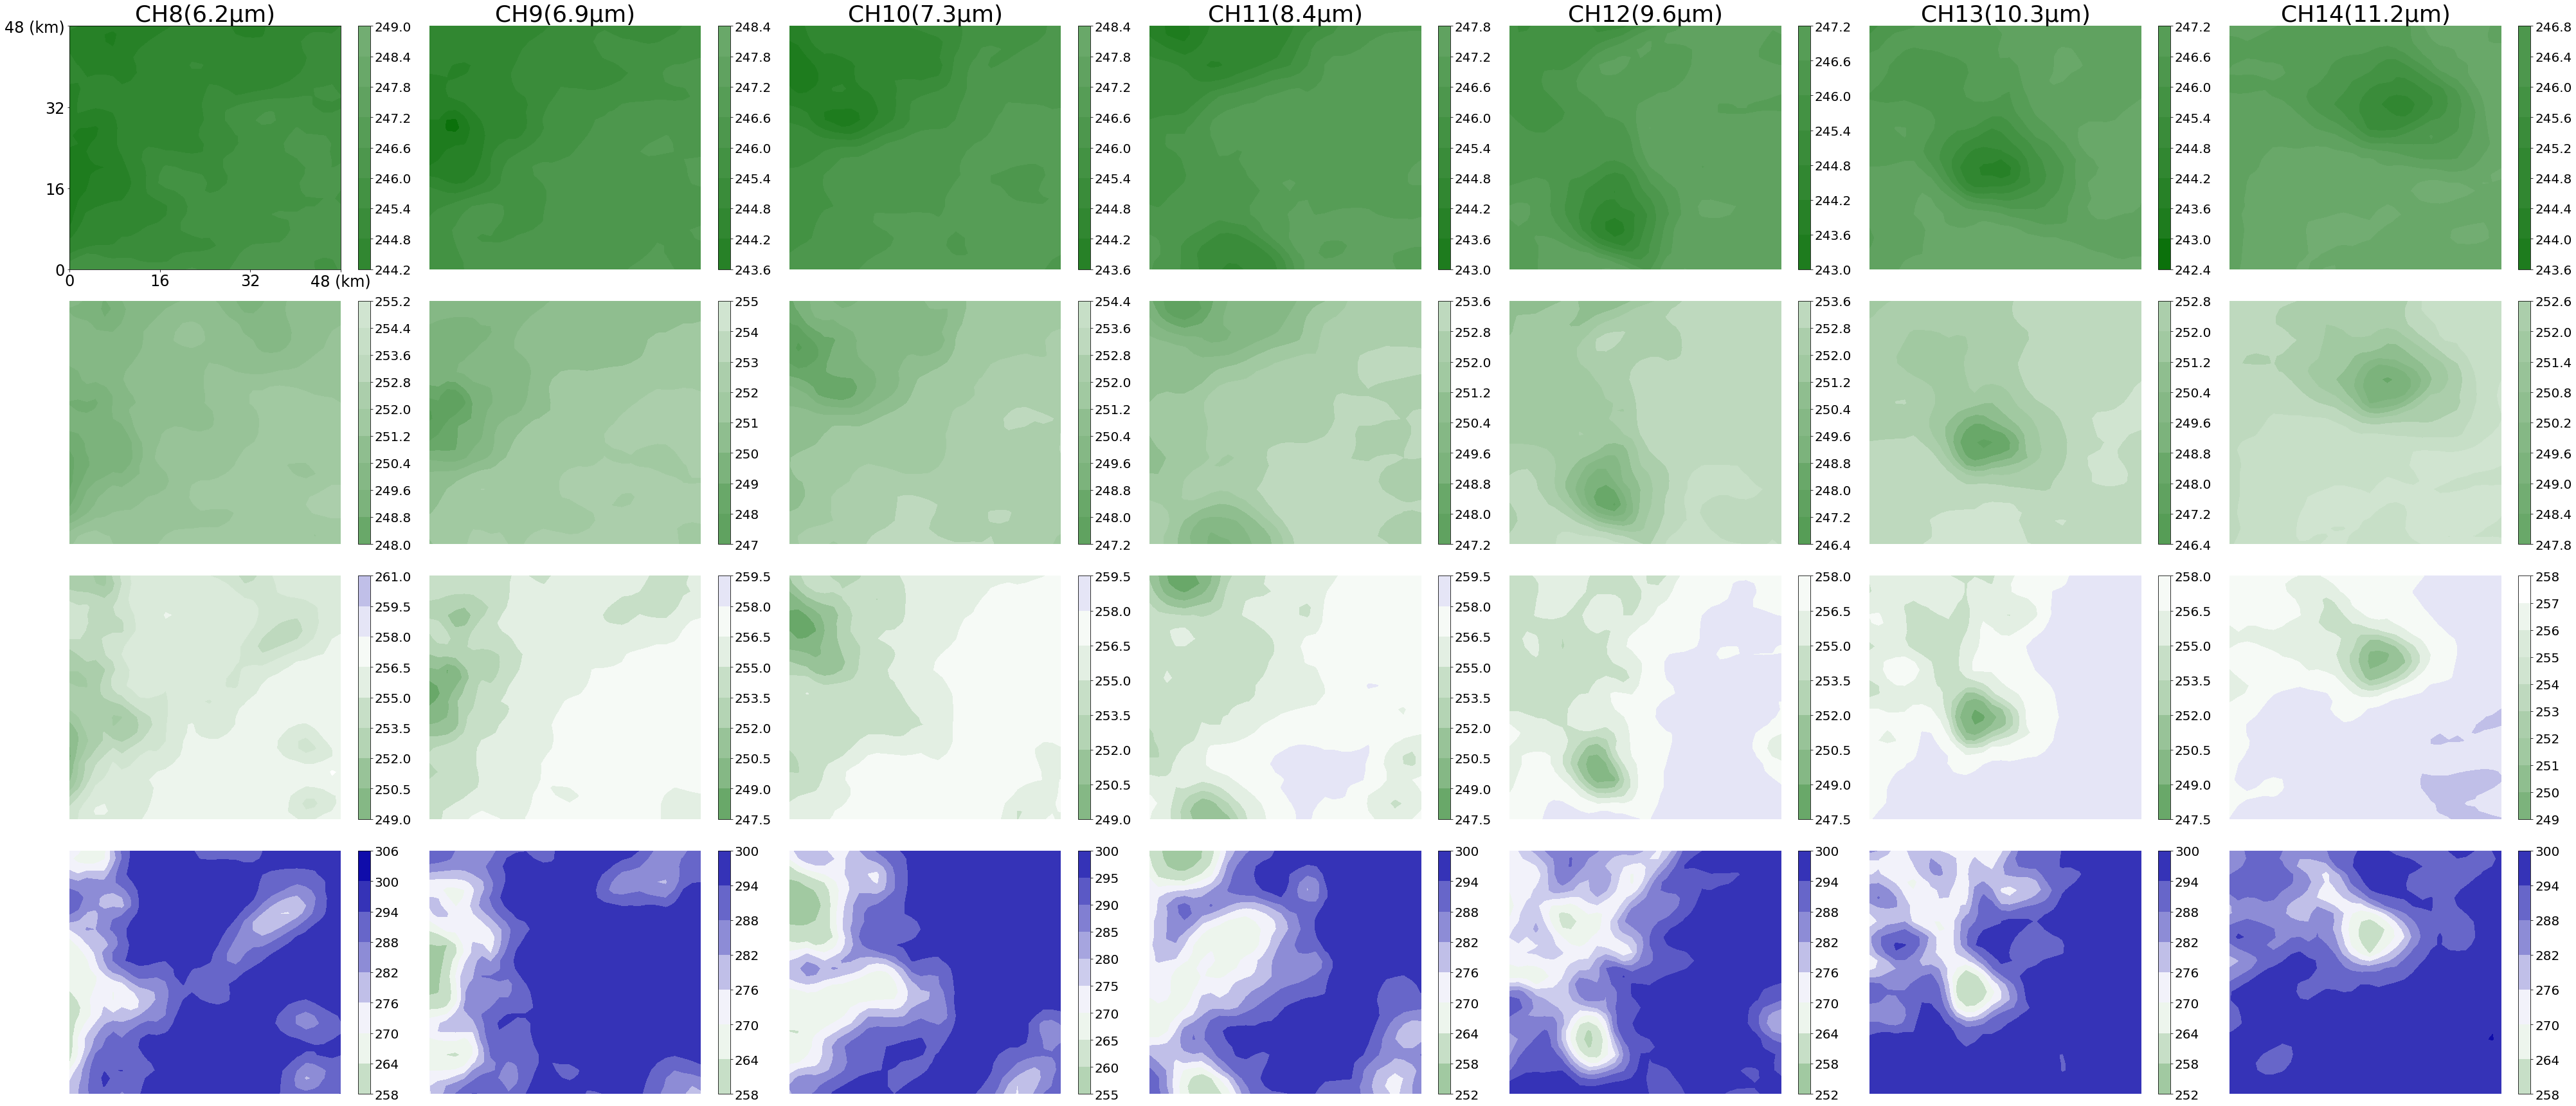

In [79]:
# index: 10 and 94
#matplotlib.rcParams.update({'font.size': 24})
from metpy.plots import colortables
#from metpy.plots import add_timestamp
#index=test_lead10_all_indices["worst_false_alarm_indices"][0]#test_lead10_all_indices["best_hit_indices"][0]
vmin = [205,210,220,195,201,190,190]
#[205.8, 205.9, 205.8, 185.2, 211.7, 200, 199.2]
#test_images_shuffled[index[0:10],:,:,7:14].min() # set min/max plotting range  
vmax = [300,315,315,365,315,385,385] 
#[300,315,315,365,315,385,385] #[292,310,325,365,315,385,385]
#[256.5, 265.9, 273.7, 306.5, 279.4, 326, 327]
#test_images_shuffled[index[0:10],:,:,7:14].max()
wavelength = [6.2, 6.9, 7.3, 8.4, 9.6, 10.3, 11.2]
row = 4#0
column = 7
#fig, ax = plt.subplots(3, 7, figsize=(42, 18))
#vmin=vmin[j], vmax=vmax[j]
# Use a colortable/colormap available from MetPy
wv_norm, wv_cmap = colortables.get_with_range('WVCIMSS_r', 220, 245)#265)
#im.set_cmap(wv_cmap)
#im.set_norm(wv_norm)
#ir_norm, ir_cmap = colortables.get_with_range('ir_drgb_r', 190, 265)
fig, ax = plt.subplots(row,column, figsize=(8*column,6*row))
vmin_all = [220,220,220,165]
vmax_all = [305,305,305,405]
for i in range(row):
    for j in range(column):
        #all_images[index,:,:,i].plot(ax=ax.ravel()[i], vmin=vmin, vmax=vmax)#index[i] #vmin=vmin[j], vmax=vmax[j]
        #a = ax[i][j].contourf(test_colorbar, vmin=170, vmax=410, cmap=wv_cmap, N=500)#i*7
        a = ax[i][6 - j].contourf(np.squeeze(test_images_shuffled[index[73],:,:,ch[i]-8+j*7]), vmin=vmin_all[i], vmax=vmax_all[i], cmap=wv_cmap, N=500)
        #a = ax[i][j].contourf(np.squeeze(test_images_shuffled[index[73],:,:,j+i*7]),  vmin=160, vmax=375, cmap=wv_cmap, N=500)#, shading="flat", edgecolors='None')#378
#cmap=wv_cmap, vmin=vmin[j], vmax=vmax[j])#, norm=ir_norm)#, vmin=vmin[j], vmax=vmax[j])#, shading="flat", edgecolors='None', N=45,ylabel='-'+str((j+1)*10)+'0 min') #cmap='seismic'#cpt_convert
        #if j == column:
        #ax[i][j].axis('off')
        if i == 0:
            ax[i][j].set_title('CH'+str(j+8)+'('+str(wavelength[j])+'µm)',fontsize=36)
        #if j == 0:
        #ax[i][j].set_ylabel('-'+str((j+1)*10)+'0 min',fontsize=36)
        if i == 0 and j==0:
              ax[i][j].set_xticks((0, 10.33, 20.66, 31))
              ax[i][j].set_xticklabels(('0', '16', '32', '48 (km)'), fontsize=24)
              ax[i][j].set_yticks((0, 10.33, 20.66, 31))
              ax[i][j].set_yticklabels(('0', '16', '32', '48 (km)'), fontsize=24)
        else:
              ax[i][j].axis('off')
        cbar = fig.colorbar(a, ax=ax[i][j])#, ticks=range(170, 410, 5))#vmin[j], vmax[j], 5))
        tick_font_size = 20
        cbar.ax.tick_params(labelsize=tick_font_size)
        #cbar.set_clim(190,320)
        #cbar.set_ticks(np.arange(210,291,20))
        #cbar.set_ticklabels( ('210', '230','250','270','290')) 
        #cbar.set_ticks(np.arange(190,320,20))
        #cbar.set_ticklabels( ('190', '210', '230','250','270','290','310'))  
plt.tight_layout()
#cbar_ax = fig.add_axes([0.1, 0.2, 0.8, 0.6])
#fig.colorbar(a, orientation="h", cax=cbar_ax)
'''
cbar = fig.colorbar(a, ax=ax.ravel().tolist(),location="bottom",shrink=0.5, extend='both')#, fontsize=20)
tick_font_size = 30
cbar.ax.tick_params(labelsize=tick_font_size)
'''
#plt.savefig('plots/hits_case2.png')
#plt.colorbar(im, pad=0, aspect=50, ticks=range(190,351,10))
#plt.colorbar(a)

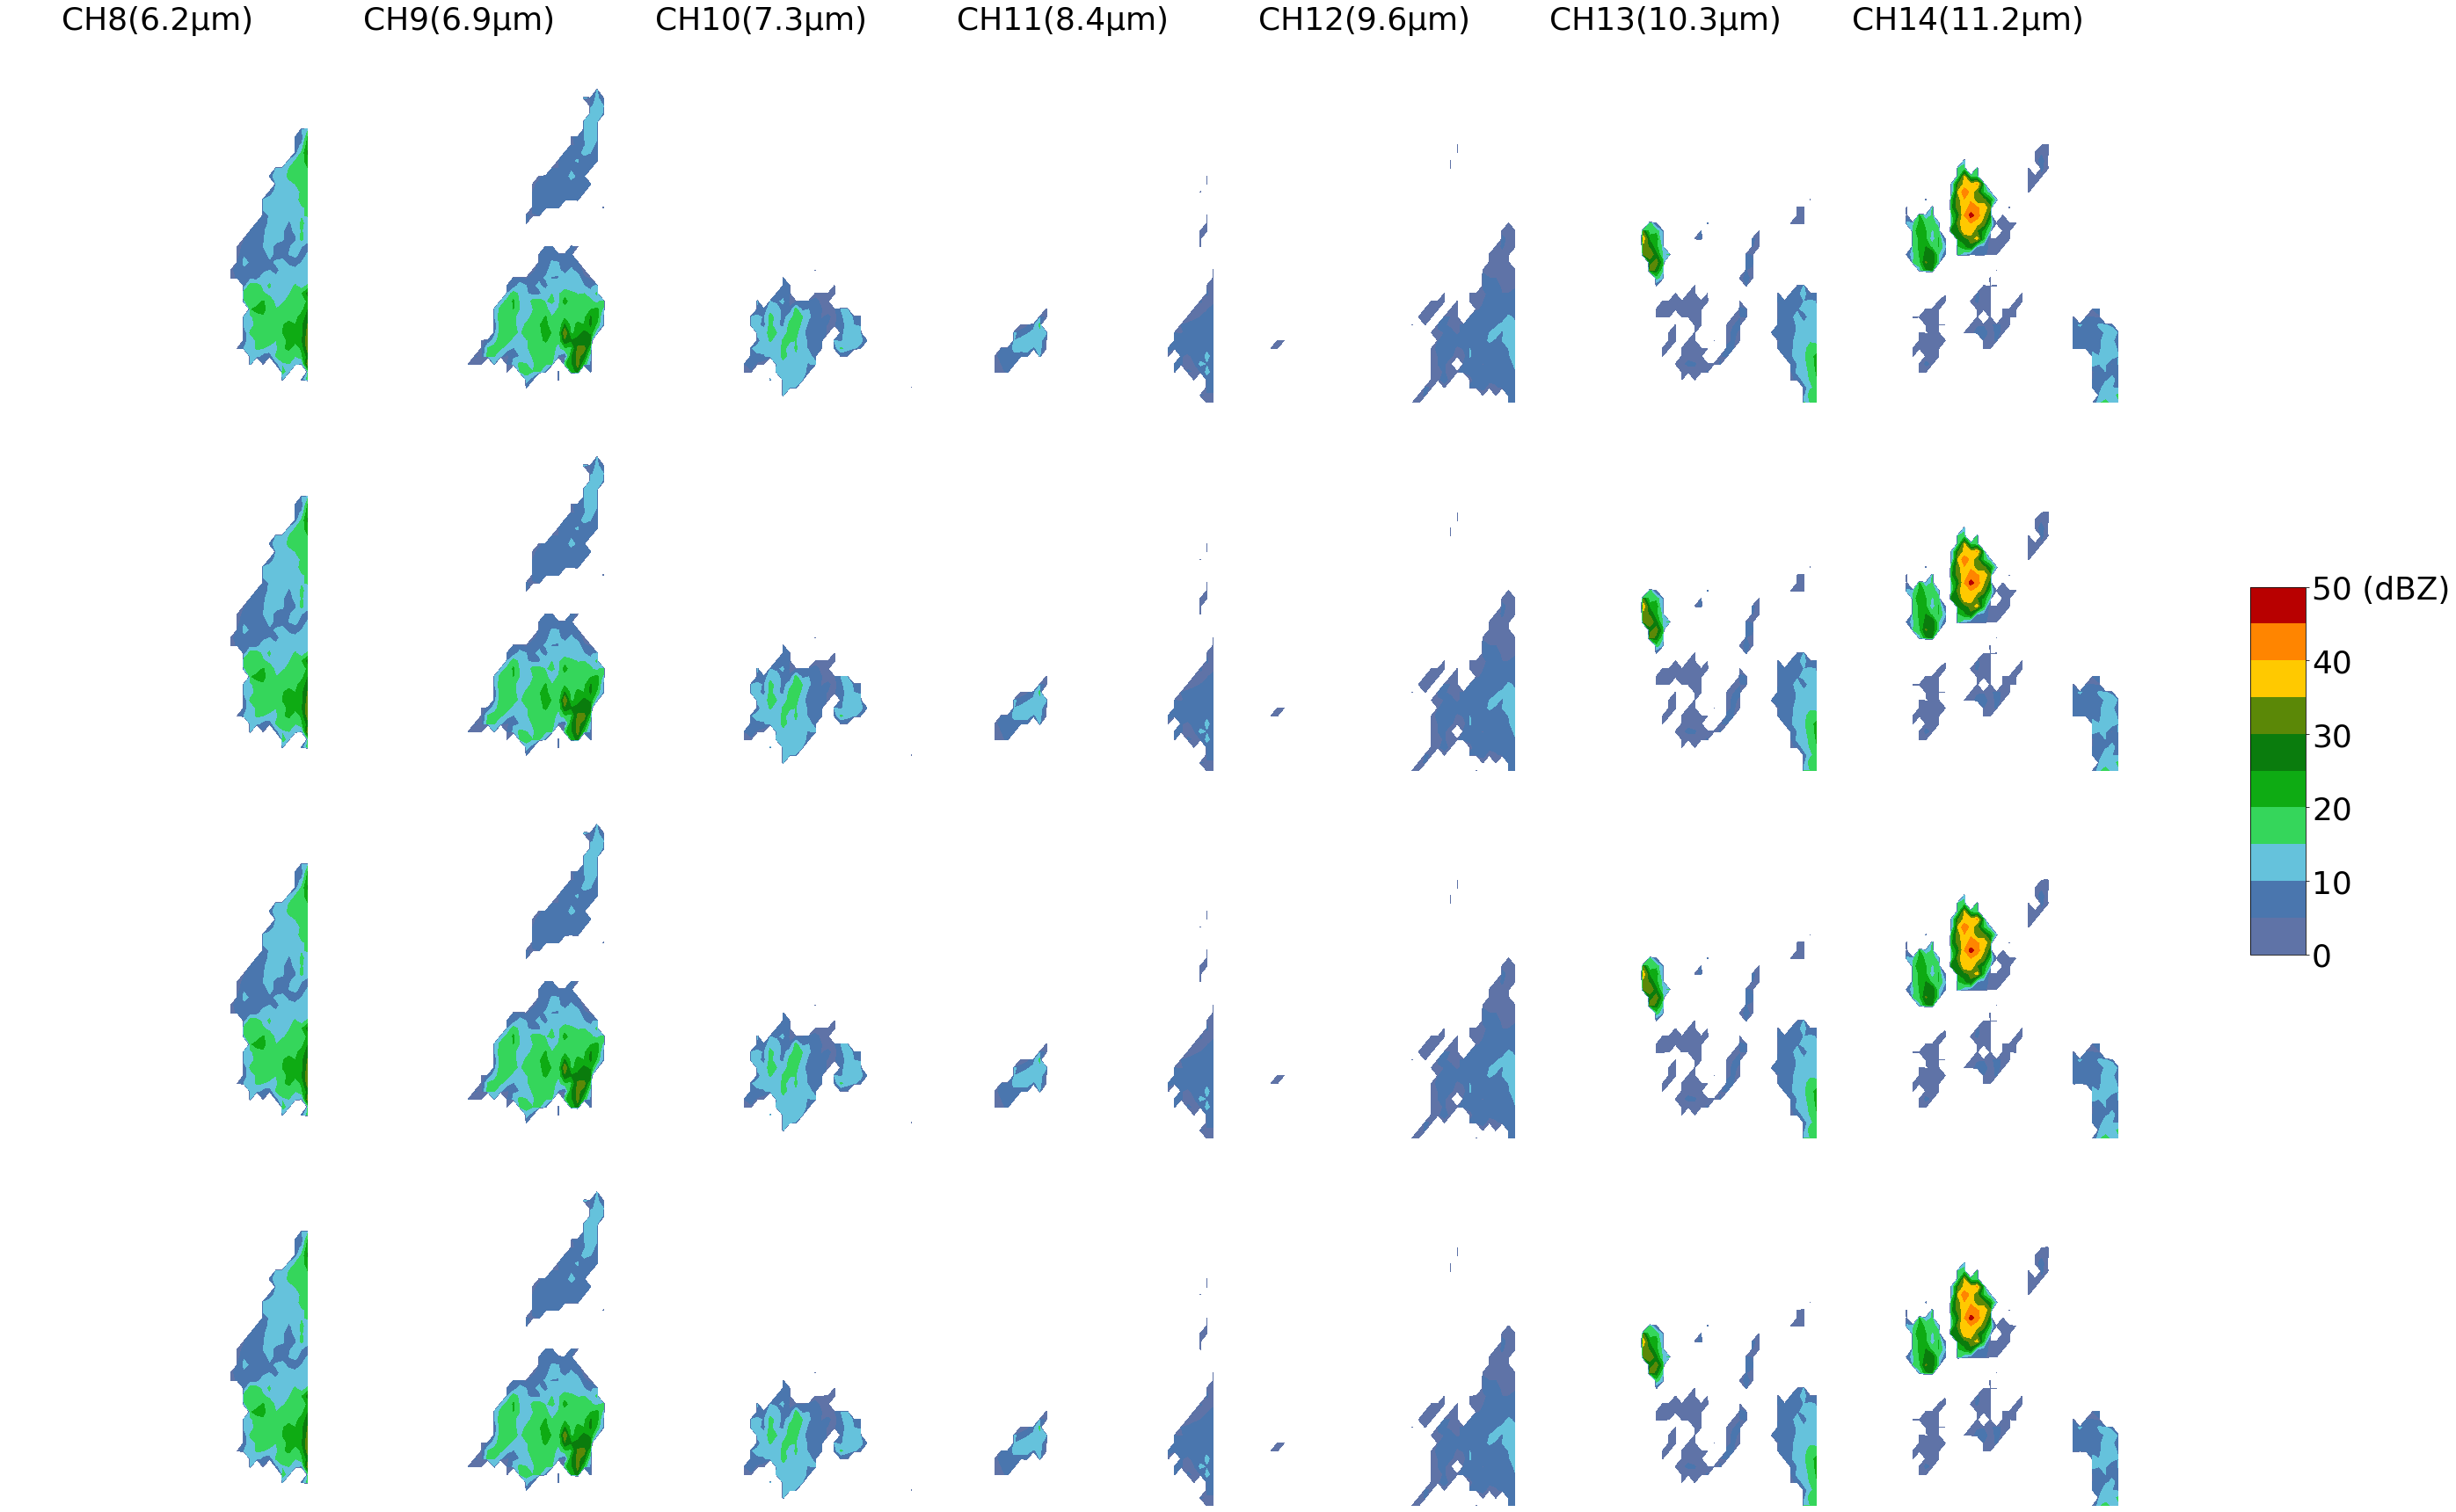

In [6]:
#matplotlib.rcParams.update({'font.size': 24})
from metpy.plots import colortables
import matplotlib as mpl
#from metpy.plots import add_timestamp
index=test_lead10_all_indices["best_hit_indices"][0]
vmin = [205,210,220,195,201,190,190]
#[205.8, 205.9, 205.8, 185.2, 211.7, 200, 199.2]
#test_images_shuffled[index[0:10],:,:,7:14].min() # set min/max plotting range  
vmax = [300,315,315,365,315,385,385] 
#[300,315,315,365,315,385,385] #[292,310,325,365,315,385,385]
#[256.5, 265.9, 273.7, 306.5, 279.4, 326, 327]
#test_images_shuffled[index[0:10],:,:,7:14].max()
wavelength = [6.2, 6.9, 7.3, 8.4, 9.6, 10.3, 11.2]
row = 4#0
column = 7
#fig, ax = plt.subplots(3, 7, figsize=(42, 18))
#vmin=vmin[j], vmax=vmax[j]
# Use a colortable/colormap available from MetPy
wv_norm, wv_cmap = colortables.get_with_range('WVCIMSS_r', 220, 265)#265)
ctable = ('NWSStormClearReflectivity',-20,0.45)#('NWSStormClearReflectivity', -20, 0.5)
norm, cmap = colortables.get_with_steps(*ctable)  
#im.set_cmap(wv_cmap)
#im.set_norm(wv_norm)
#ir_norm, ir_cmap = colortables.get_with_range('ir_drgb_r', 190, 265)
fig, ax = plt.subplots(row,column, figsize=(6*column,6*row))
for i in range(row):
    for j in range(column):
        #all_images[index,:,:,i].plot(ax=ax.ravel()[i], vmin=vmin, vmax=vmax)#index[i] #vmin=vmin[j], vmax=vmax[j]
        #a = ax[i][j].pcolormesh(test_colorbar, vmin=170, vmax=410, cmap=wv_cmap)#, N=500)
        processed_file = nc.Dataset(os.path.join(My_dir,files[j*5]))
        dbz = processed_file.variables['MergedReflectivityQCComposite'][:]
        a = ax[i][j].contourf( 
                                    np.fliplr(dbz[lat_index_1[0][0]:lat_index_0[0][0],lon_index_0[0][0]:lon_index_1[0][0]].T),
                                    norm=norm, cmap=cmap,levels=(0, 5, 10, 15, 20,25,30,35,40,45,50))
        #if j == column:
        #ax[i][j].axis('off')
        if i == 0:
            ax[i][j].set_title('CH'+str(j+8)+'('+str(wavelength[j])+'µm)',fontsize=36)
        #if j == 0:
        #ax[i][j].set_ylabel('-'+str((j+1)*10)+'0 min',fontsize=36)
        '''
        if i == 0 and j==0:
              ax[i][j].set_xticks((0, 10.33, 20.66, 31))
              ax[i][j].set_xticklabels(('0', '16', '32', '48 (km)'), fontsize=24)
              ax[i][j].set_yticks((0, 10.33, 20.66, 31))
              ax[i][j].set_yticklabels(('0', '16', '32', '48 (km)'), fontsize=24)
        else:
              ax[i][j].axis('off')
        '''
        ax[i][j].axis('off')
        #cbar = fig.colorbar(a, ax=ax[i][j])#, ticks=range(170, 410, 5))#vmin[j], vmax[j], 5))
        #tick_font_size = 20
        #cbar.ax.tick_params(labelsize=tick_font_size)
        #cbar.set_clim(190,320)
        #cbar.set_ticks(np.arange(210,291,20))
        #cbar.set_ticklabels( ('210', '230','250','270','290')) 
        #cbar.set_ticks(np.arange(190,320,20))
        #cbar.set_ticklabels( ('190', '210', '230','250','270','290','310'))  
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
#cbar_ax = fig.add_axes([0.1, 0.2, 0.8, 0.6])
#fig.colorbar(a, orientation="h", cax=cbar_ax)
cbar = fig.colorbar(a, ax=ax.ravel().tolist(),location="right",cmap = wv_cmap, shrink=0.25,  boundaries=np.arange(0,51,10), aspect=6.66)#, fontsize=20)
#fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
#cbar.mappable.set_clim(170,410)
tick_font_size = 36
cbar.ax.tick_params(labelsize=tick_font_size)
cbar.set_ticks(np.arange(0,51,10))
cbar.set_ticklabels( ('0', '10', '20','30','40', '50 (dBZ)')) 

#plt.savefig('plots/hits_colorbar.png')
#plt.colorbar(im, pad=0, aspect=50, ticks=range(190,351,10))
#plt.colorbar(a)

In [26]:
print(np.min(test_images_shuffled[test_lead10_all_indices["best_hit_indices"][0][63],:,:,ch[3]-8+j*7]))
print(np.max(test_images_shuffled[test_lead10_all_indices["best_hit_indices"][0][63],:,:,ch[3]-8+j*7]))

264.22412
287.67596


In [27]:
print(np.min(np.squeeze(test_images_shuffled[test_lead10_all_indices["worst_false_alarm_indices"][0][73],:,:,ch[i]-8+j*7])))
print(np.max(np.squeeze(test_images_shuffled[test_lead10_all_indices["worst_false_alarm_indices"][0][73],:,:,ch[i]-8+j*7])))

258.79623
299.14685


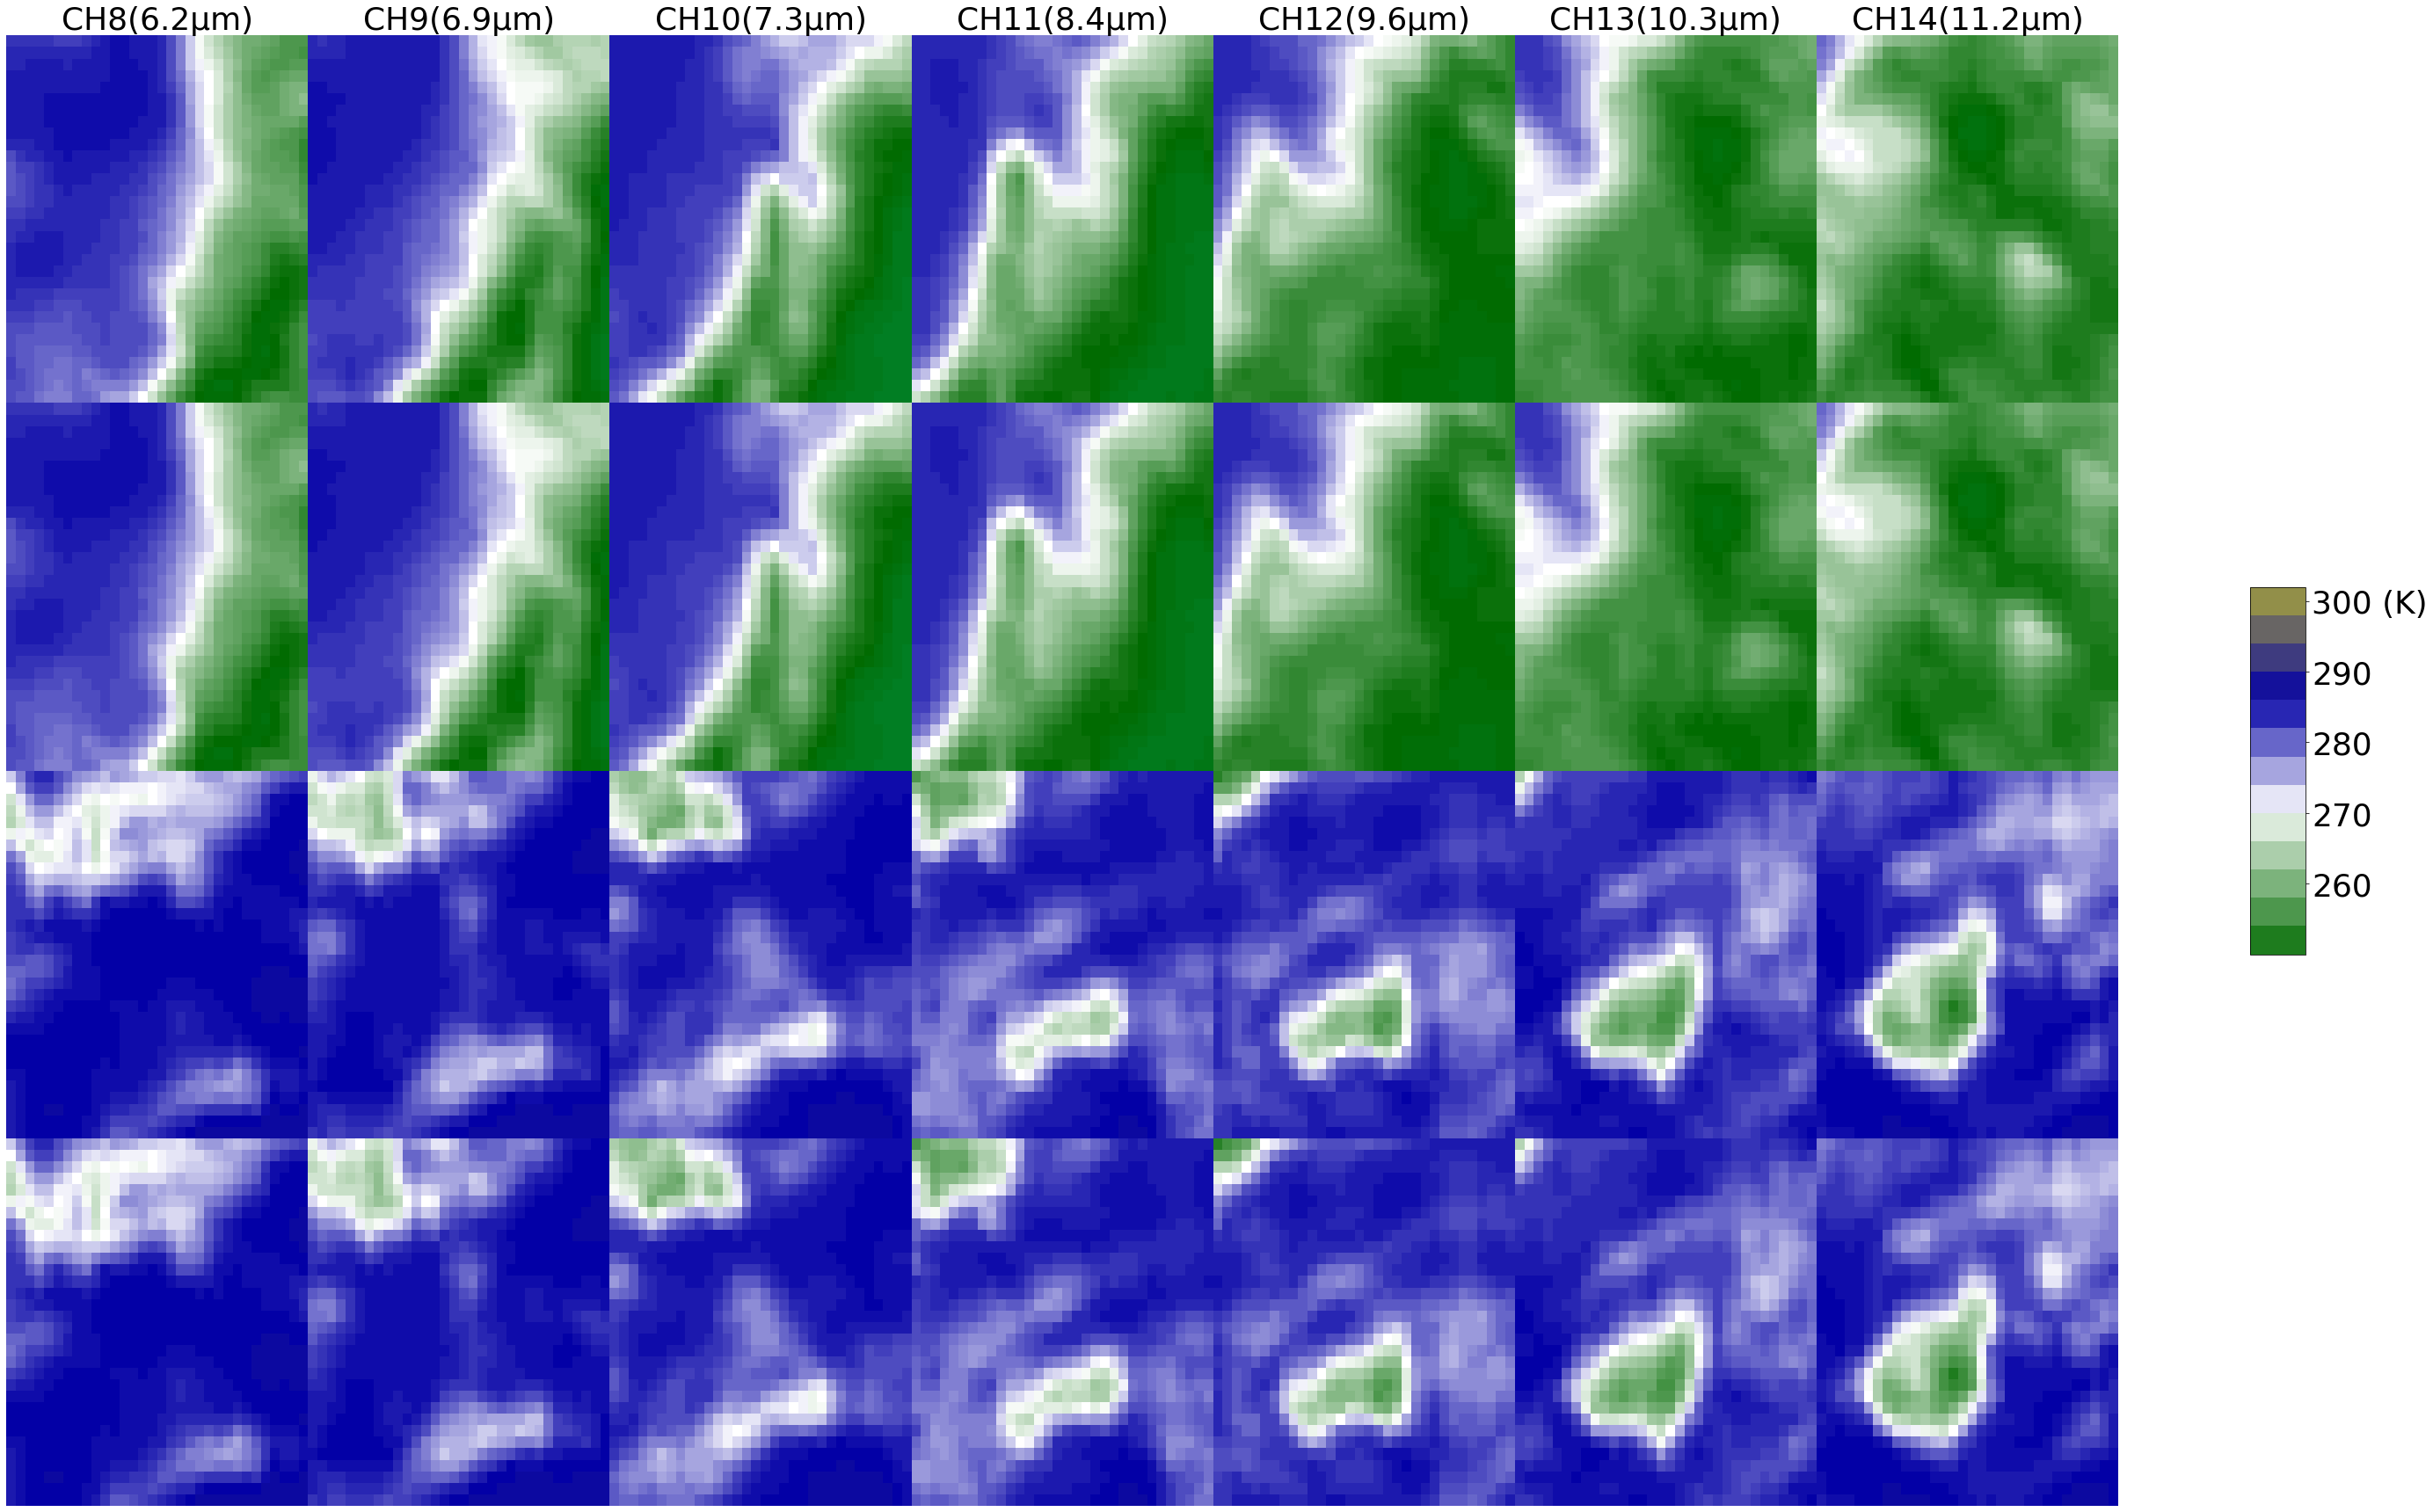

In [70]:
#matplotlib.rcParams.update({'font.size': 24})
from metpy.plots import colortables
import matplotlib as mpl
#from metpy.plots import add_timestamp
index=test_lead10_all_indices["best_hit_indices"][0]
vmin = [205,210,220,195,201,190,190]
#[205.8, 205.9, 205.8, 185.2, 211.7, 200, 199.2]
#test_images_shuffled[index[0:10],:,:,7:14].min() # set min/max plotting range  
vmax = [300,315,315,365,315,385,385] 
#[300,315,315,365,315,385,385] #[292,310,325,365,315,385,385]
#[256.5, 265.9, 273.7, 306.5, 279.4, 326, 327]
#test_images_shuffled[index[0:10],:,:,7:14].max()
wavelength = [6.2, 6.9, 7.3, 8.4, 9.6, 10.3, 11.2]
row = 4#0
column = 7
#fig, ax = plt.subplots(3, 7, figsize=(42, 18))
#vmin=vmin[j], vmax=vmax[j]
# Use a colortable/colormap available from MetPy
vmin_all = 160
vmax_all = 410
#[210,290] [220,300] [225,305] [230,335]
#[230,249] [238,255] [242,262] [250,306]
WV_min = [210, 220, 225, 220]
WV_max = [290, 300, 305, 335]
#[210,290] [220,300] [225,305] [230,335]
fig, ax = plt.subplots(row,column, figsize=(6*column,6*row))
for i in range(row):
    for j in range(column):
            #all_images[index,:,:,i].plot(ax=ax.ravel()[i], vmin=vmin, vmax=vmax)#index[i] #vmin=vmin[j], vmax=vmax[j]
            #a = ax[i][j].contourf(test_colorbar, vmin=170, vmax=410, cmap=wv_cmap, N=500)#i*7
        wv_norm, wv_cmap = colortables.get_with_range('WVCIMSS_r',WV_min[3],WV_max[3])
        if i == 0 or i == 1:
            a = ax[i][6 - j].pcolormesh(np.squeeze(test_images_shuffled[test_lead10_all_indices["worst_miss_indices"][0][10],:,:,ch[3]-8+j*7]), \
                                      cmap=wv_cmap, vmin=WV_min[3], vmax=WV_max[3])#265
        #if i == 3:
        #    a = ax[i][6 - j].contourf(np.squeeze(test_images_shuffled[test_lead10_all_indices["worst_false_alarm_indices"][0][73],:,:,ch[i]-8+j*7]), vmin=vmin_all, vmax=vmax_all,\
        #                              cmap=wv_cmap, norm=wv_norm, N=500)
        #else:
        else:
            a = ax[i][6 - j].pcolormesh(np.squeeze(test_images_shuffled[test_lead10_all_indices["best_hit_indices"][0][63],:,:,ch[3]-8+j*7]),\
                                      cmap=wv_cmap, vmin=WV_min[3], vmax=WV_max[3])
        #if j == column:
        #ax[i][j].axis('off')
        if i == 0:
            ax[i][j].set_title('CH'+str(j+8)+'('+str(wavelength[j])+'µm)',fontsize=36)
        #if j == 0:
        #ax[i][j].set_ylabel('-'+str((j+1)*10)+'0 min',fontsize=36)
        '''
        if i == 0 and j==0:
              ax[i][j].set_xticks((0, 10.33, 20.66, 31))
              ax[i][j].set_xticklabels(('0', '16', '32', '48 (km)'), fontsize=24)
              ax[i][j].set_yticks((0, 10.33, 20.66, 31))
              ax[i][j].set_yticklabels(('0', '16', '32', '48 (km)'), fontsize=24)
        else:
              ax[i][j].axis('off')
        '''
        ax[i][j].axis('off')
        #cbar = fig.colorbar(a, ax=ax[i][j])#, ticks=range(170, 410, 5))#vmin[j], vmax[j], 5))
        #tick_font_size = 20
        #cbar.ax.tick_params(labelsize=tick_font_size)
        #cbar.set_clim(190,320)
        #cbar.set_ticks(np.arange(210,291,20))
        #cbar.set_ticklabels( ('210', '230','250','270','290')) 
        #cbar.set_ticks(np.arange(190,320,20))
        #cbar.set_ticklabels( ('190', '210', '230','250','270','290','310'))  
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
#cbar_ax = fig.add_axes([0.1, 0.2, 0.8, 0.6])
#fig.colorbar(a, orientation="h", cax=cbar_ax)
cbar = fig.colorbar(a, ax=ax.ravel().tolist(),location="right",cmap = wv_cmap, shrink=0.25,  boundaries=np.arange(250,305,4), aspect=6.66)#, fontsize=20)
#fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
#cbar.mappable.set_clim(170,410)
tick_font_size = 36
cbar.ax.tick_params(labelsize=tick_font_size)
cbar.set_ticks(np.arange(260,301,10))
cbar.set_ticklabels( ('260', '270','280','290','300 (K)')) 

#plt.savefig('plots/hits_colorbar.png')
#plt.colorbar(im, pad=0, aspect=50, ticks=range(190,351,10))
#plt.colorbar(a)

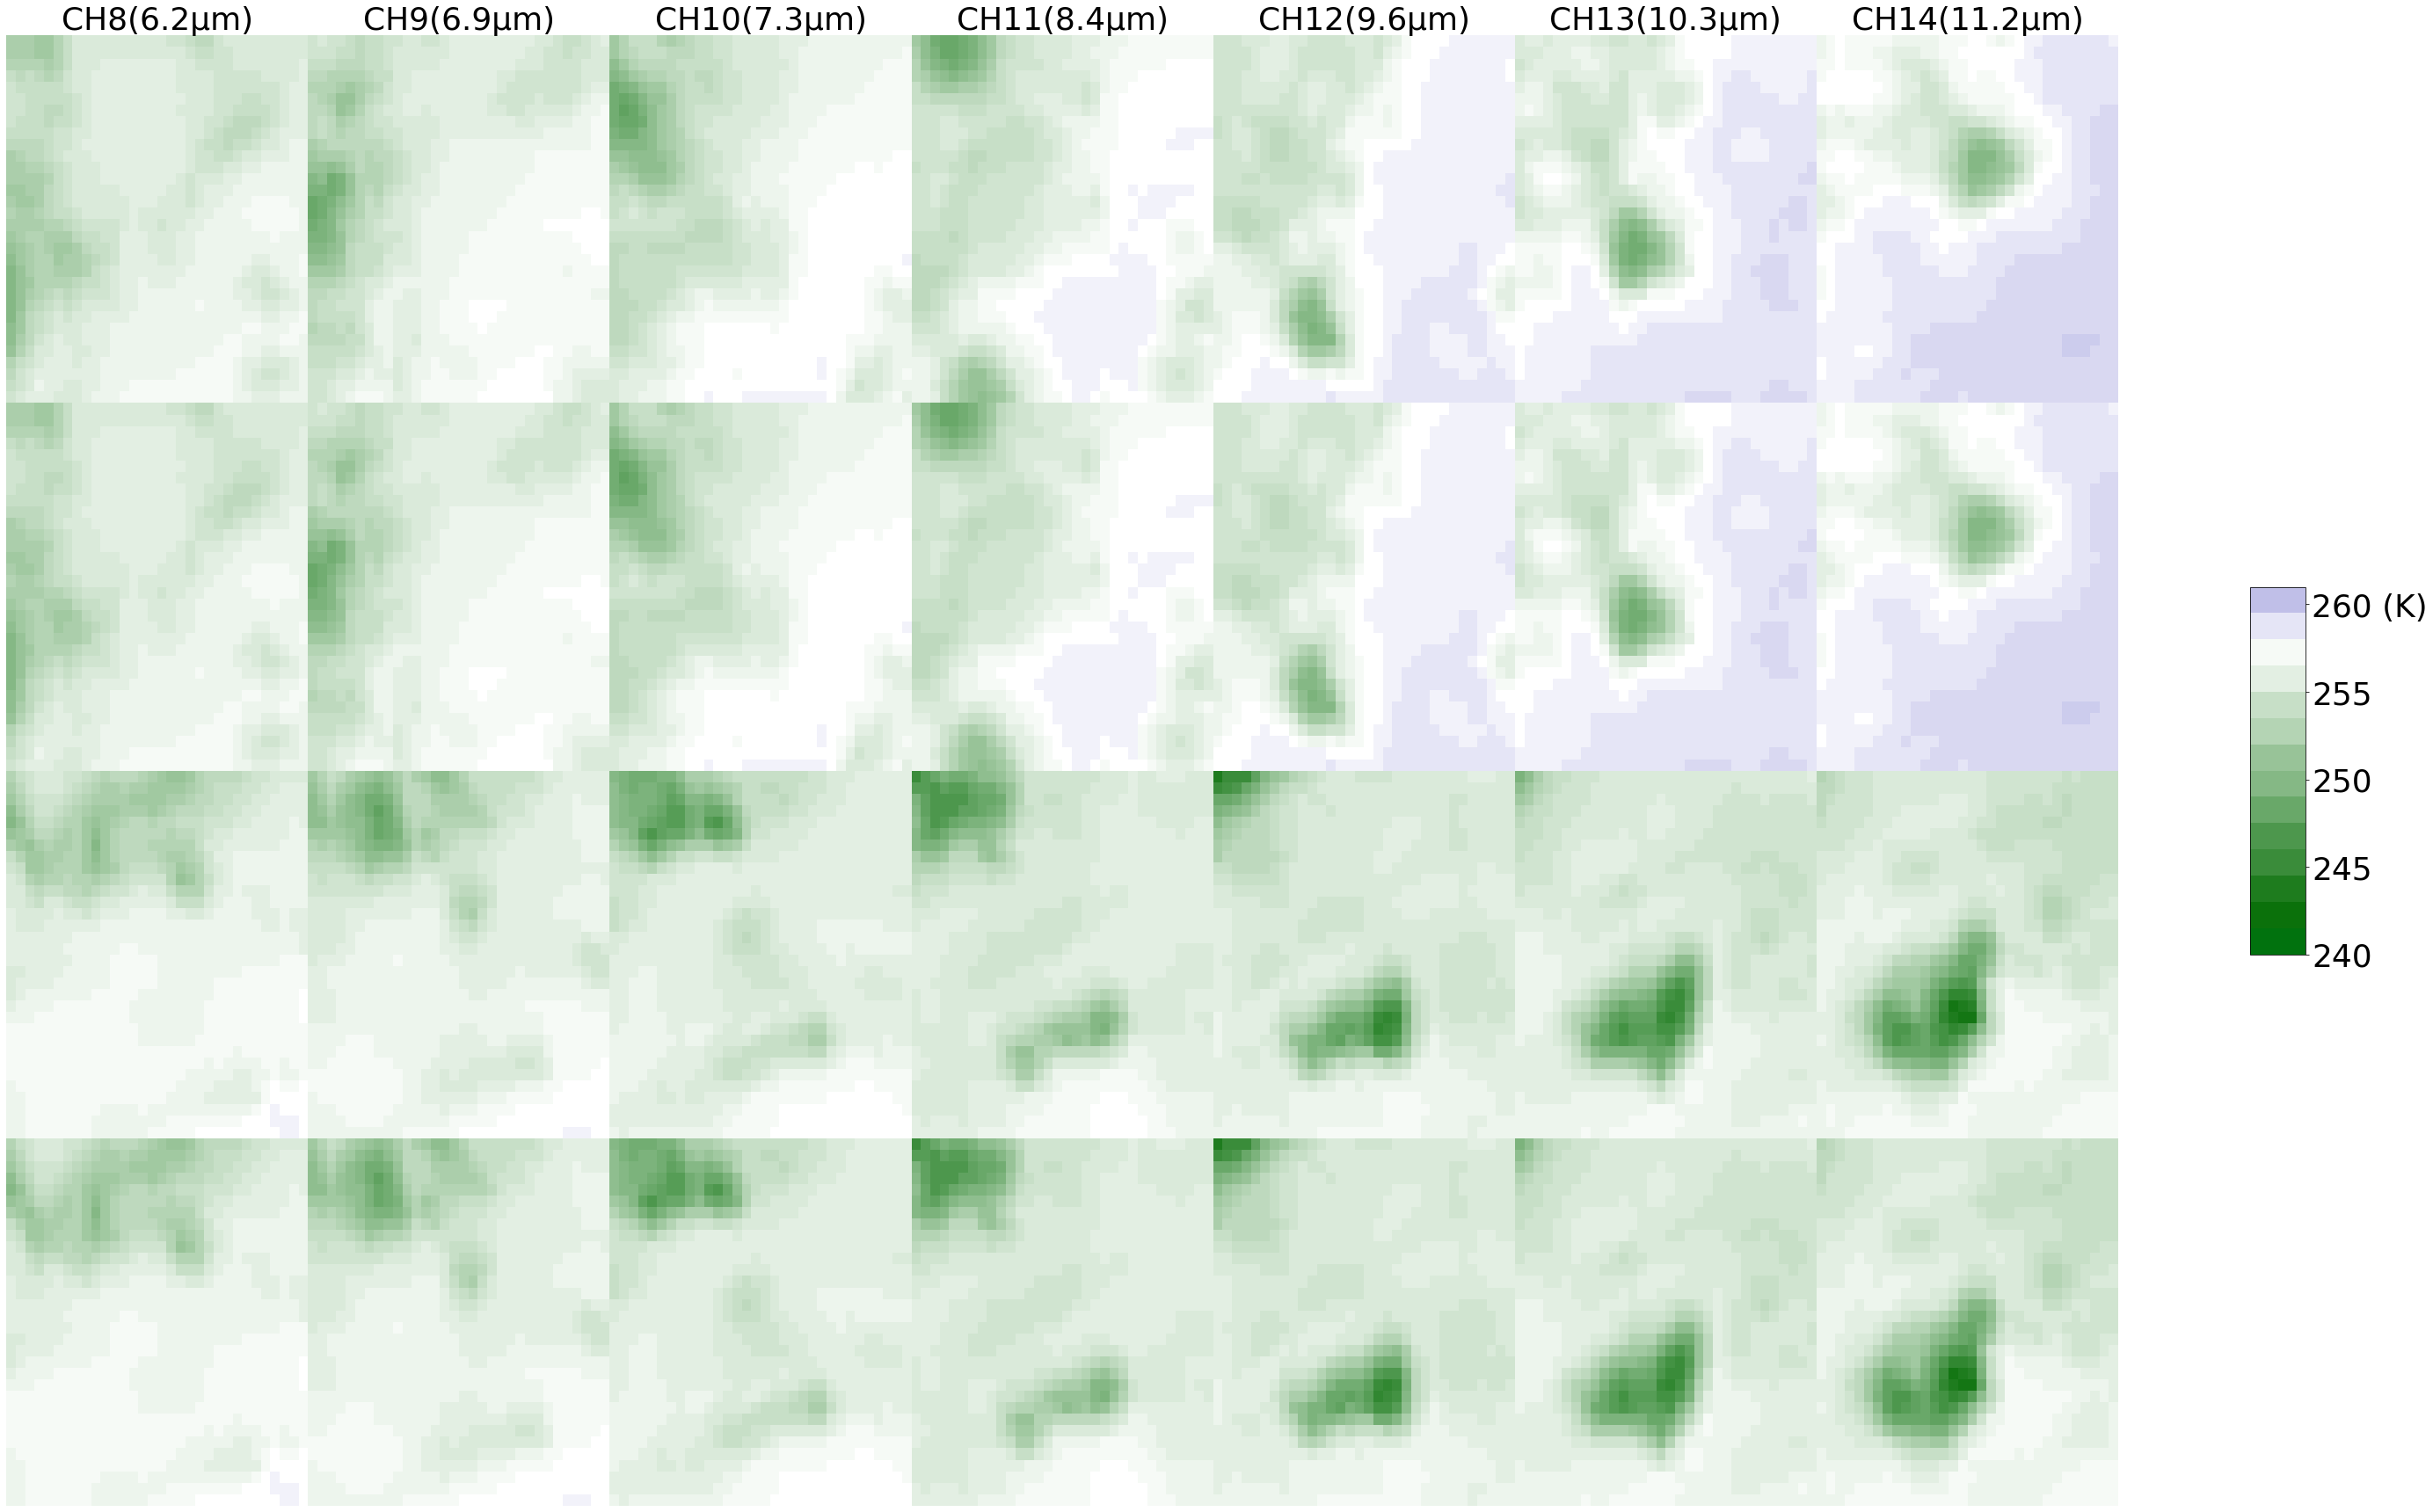

In [72]:
#matplotlib.rcParams.update({'font.size': 24})
from metpy.plots import colortables
import matplotlib as mpl
#from metpy.plots import add_timestamp
index=test_lead10_all_indices["best_hit_indices"][0]
vmin = [205,210,220,195,201,190,190]
#[205.8, 205.9, 205.8, 185.2, 211.7, 200, 199.2]
#test_images_shuffled[index[0:10],:,:,7:14].min() # set min/max plotting range  
vmax = [300,315,315,365,315,385,385] 
#[300,315,315,365,315,385,385] #[292,310,325,365,315,385,385]
#[256.5, 265.9, 273.7, 306.5, 279.4, 326, 327]
#test_images_shuffled[index[0:10],:,:,7:14].max()
wavelength = [6.2, 6.9, 7.3, 8.4, 9.6, 10.3, 11.2]
row = 4#0
column = 7
#fig, ax = plt.subplots(3, 7, figsize=(42, 18))
#vmin=vmin[j], vmax=vmax[j]
# Use a colortable/colormap available from MetPy
vmin_all = 160
vmax_all = 410
#[210,290] [220,300] [225,305] [230,335]
#[230,249] [238,255] [242,262] [250,306]
WV_min = [210, 220, 220, 225]
WV_max = [290, 300, 305, 335]
#[210,290] [220,300] [225,305] [230,335]
fig, ax = plt.subplots(row,column, figsize=(6*column,6*row))
for i in range(row):
    for j in range(column):
            #all_images[index,:,:,i].plot(ax=ax.ravel()[i], vmin=vmin, vmax=vmax)#index[i] #vmin=vmin[j], vmax=vmax[j]
            #a = ax[i][j].contourf(test_colorbar, vmin=170, vmax=410, cmap=wv_cmap, N=500)#i*7
        wv_norm, wv_cmap = colortables.get_with_range('WVCIMSS_r',WV_min[2],WV_max[2])
        if i == 0 or i == 1:
            a = ax[i][6 - j].pcolormesh(np.squeeze(test_images_shuffled[test_lead10_all_indices["worst_false_alarm_indices"][0][73],:,:,ch[2]-8+j*7]), \
                                      cmap=wv_cmap, vmin=WV_min[2], vmax=WV_max[2])#265
        #if i == 3:
        #    a = ax[i][6 - j].contourf(np.squeeze(test_images_shuffled[test_lead10_all_indices["worst_false_alarm_indices"][0][73],:,:,ch[i]-8+j*7]), vmin=vmin_all, vmax=vmax_all,\
        #                              cmap=wv_cmap, norm=wv_norm, N=500)
        #else:
        else:
            a = ax[i][6 - j].pcolormesh(np.squeeze(test_images_shuffled[test_lead10_all_indices["best_hit_indices"][0][63],:,:,ch[2]-8+j*7]),\
                                      cmap=wv_cmap, vmin=WV_min[2], vmax=WV_max[2])
        #if j == column:
        #ax[i][j].axis('off')
        if i == 0:
            ax[i][j].set_title('CH'+str(j+8)+'('+str(wavelength[j])+'µm)',fontsize=36)
        #if j == 0:
        #ax[i][j].set_ylabel('-'+str((j+1)*10)+'0 min',fontsize=36)
        '''
        if i == 0 and j==0:
              ax[i][j].set_xticks((0, 10.33, 20.66, 31))
              ax[i][j].set_xticklabels(('0', '16', '32', '48 (km)'), fontsize=24)
              ax[i][j].set_yticks((0, 10.33, 20.66, 31))
              ax[i][j].set_yticklabels(('0', '16', '32', '48 (km)'), fontsize=24)
        else:
              ax[i][j].axis('off')
        '''
        ax[i][j].axis('off')
        #cbar = fig.colorbar(a, ax=ax[i][j])#, ticks=range(170, 410, 5))#vmin[j], vmax[j], 5))
        #tick_font_size = 20
        #cbar.ax.tick_params(labelsize=tick_font_size)
        #cbar.set_clim(190,320)
        #cbar.set_ticks(np.arange(210,291,20))
        #cbar.set_ticklabels( ('210', '230','250','270','290')) 
        #cbar.set_ticks(np.arange(190,320,20))
        #cbar.set_ticklabels( ('190', '210', '230','250','270','290','310'))  
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
#cbar_ax = fig.add_axes([0.1, 0.2, 0.8, 0.6])
#fig.colorbar(a, orientation="h", cax=cbar_ax)
cbar = fig.colorbar(a, ax=ax.ravel().tolist(),location="right",cmap = wv_cmap, shrink=0.25,  boundaries=np.arange(240,261.5,1.5), aspect=6.66)#, fontsize=20)
#fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
#cbar.mappable.set_clim(170,410)
tick_font_size = 36
cbar.ax.tick_params(labelsize=tick_font_size)
cbar.set_ticks(np.arange(240,260.5,5))
cbar.set_ticklabels( ('240', '245', '250', '255', '260 (K)')) 


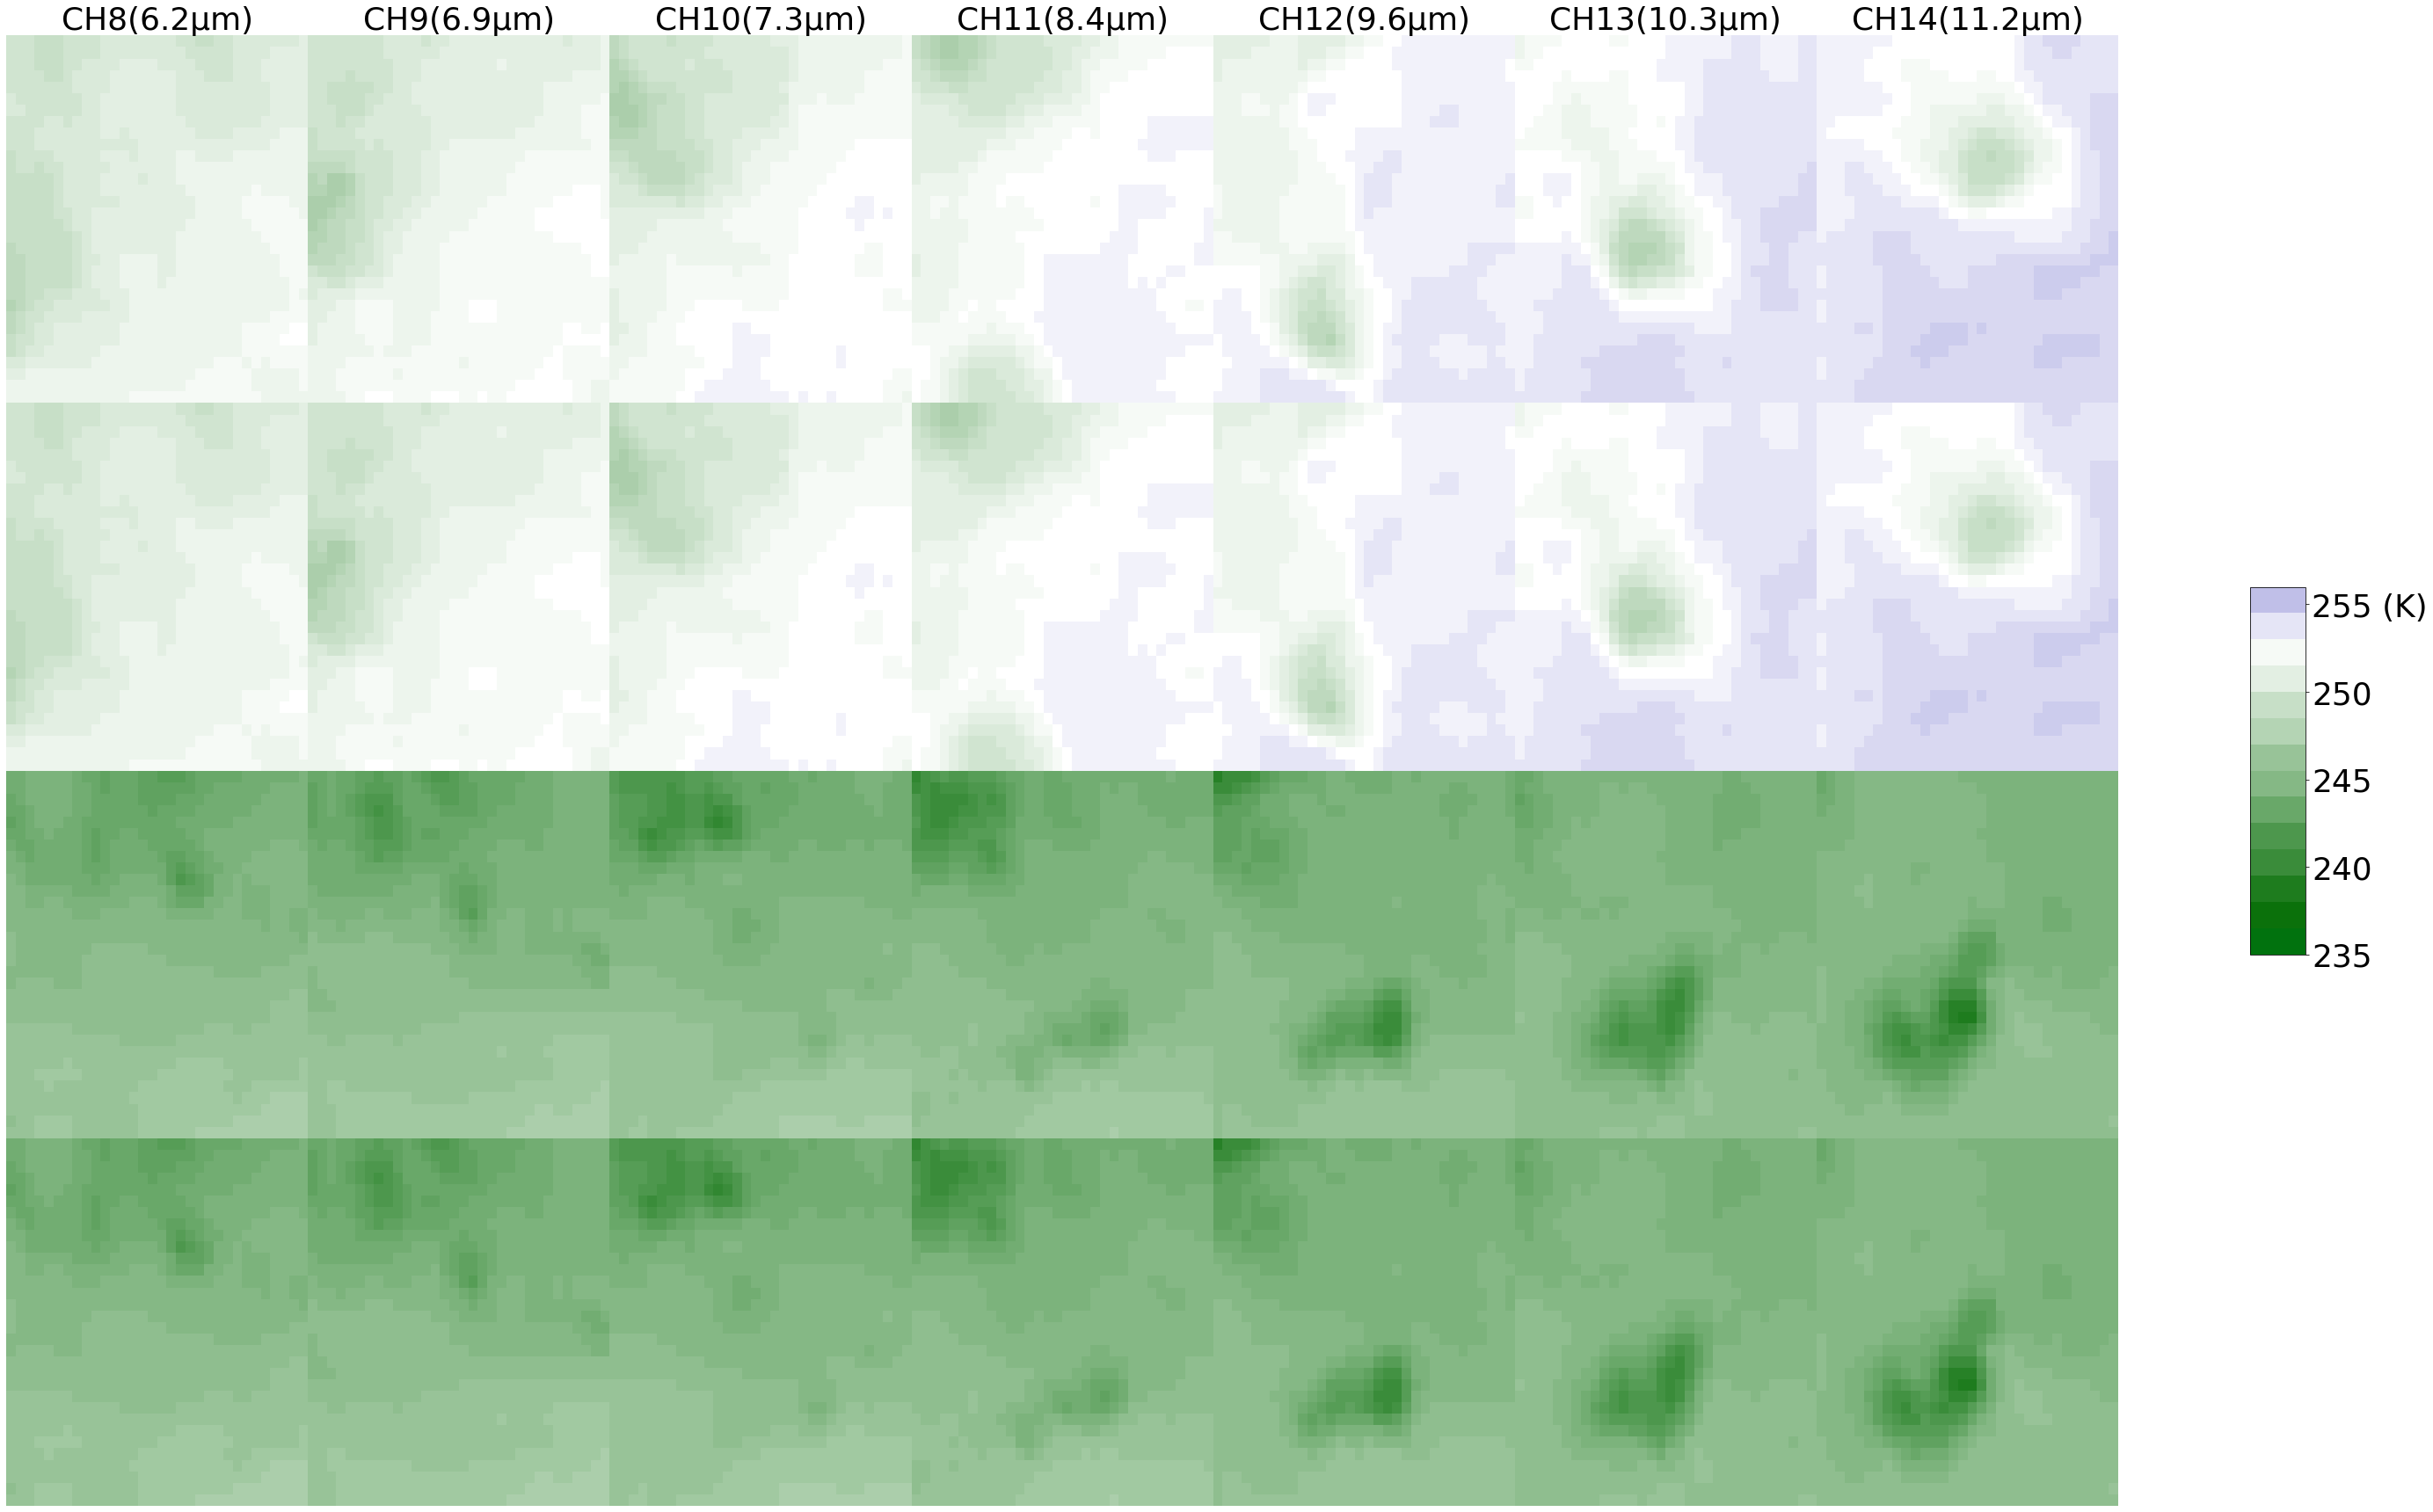

In [79]:
from metpy.plots import colortables
import matplotlib as mpl
#from metpy.plots import add_timestamp
index=test_lead10_all_indices["best_hit_indices"][0]
vmin = [205,210,220,195,201,190,190]
#[205.8, 205.9, 205.8, 185.2, 211.7, 200, 199.2]
#test_images_shuffled[index[0:10],:,:,7:14].min() # set min/max plotting range  
vmax = [300,315,315,365,315,385,385] 
#[300,315,315,365,315,385,385] #[292,310,325,365,315,385,385]
#[256.5, 265.9, 273.7, 306.5, 279.4, 326, 327]
#test_images_shuffled[index[0:10],:,:,7:14].max()
wavelength = [6.2, 6.9, 7.3, 8.4, 9.6, 10.3, 11.2]
row = 4#0
column = 7
#fig, ax = plt.subplots(3, 7, figsize=(42, 18))
#vmin=vmin[j], vmax=vmax[j]
# Use a colortable/colormap available from MetPy
vmin_all = 160
vmax_all = 410
#[210,290] [220,300] [225,305] [230,335]
#[230,249] [238,255] [242,262] [250,306]
WV_min = [210, 215, 220, 225]
WV_max = [290, 300, 305, 335]
#[210,290] [220,300] [225,305] [230,335]
fig, ax = plt.subplots(row,column, figsize=(6*column,6*row))
for i in range(row):
    for j in range(column):
            #all_images[index,:,:,i].plot(ax=ax.ravel()[i], vmin=vmin, vmax=vmax)#index[i] #vmin=vmin[j], vmax=vmax[j]
            #a = ax[i][j].contourf(test_colorbar, vmin=170, vmax=410, cmap=wv_cmap, N=500)#i*7
        wv_norm, wv_cmap = colortables.get_with_range('WVCIMSS_r',WV_min[1],WV_max[1])
        if i == 0 or i == 1:
            a = ax[i][6 - j].pcolormesh(np.squeeze(test_images_shuffled[test_lead10_all_indices["worst_false_alarm_indices"][0][73],:,:,ch[1]-8+j*7]), \
                                      cmap=wv_cmap, vmin=WV_min[1], vmax=WV_max[1])#265
        #if i == 3:
        #    a = ax[i][6 - j].contourf(np.squeeze(test_images_shuffled[test_lead10_all_indices["worst_false_alarm_indices"][0][73],:,:,ch[i]-8+j*7]), vmin=vmin_all, vmax=vmax_all,\
        #                              cmap=wv_cmap, norm=wv_norm, N=500)
        #else:
        else:
            a = ax[i][6 - j].pcolormesh(np.squeeze(test_images_shuffled[test_lead10_all_indices["best_hit_indices"][0][63],:,:,ch[1]-8+j*7]),\
                                      cmap=wv_cmap, vmin=WV_min[1], vmax=WV_max[1])
        #if j == column:
        #ax[i][j].axis('off')
        if i == 0:
            ax[i][j].set_title('CH'+str(j+8)+'('+str(wavelength[j])+'µm)',fontsize=36)
        #if j == 0:
        #ax[i][j].set_ylabel('-'+str((j+1)*10)+'0 min',fontsize=36)
        '''
        if i == 0 and j==0:
              ax[i][j].set_xticks((0, 10.33, 20.66, 31))
              ax[i][j].set_xticklabels(('0', '16', '32', '48 (km)'), fontsize=24)
              ax[i][j].set_yticks((0, 10.33, 20.66, 31))
              ax[i][j].set_yticklabels(('0', '16', '32', '48 (km)'), fontsize=24)
        else:
              ax[i][j].axis('off')
        '''
        ax[i][j].axis('off')
        #cbar = fig.colorbar(a, ax=ax[i][j])#, ticks=range(170, 410, 5))#vmin[j], vmax[j], 5))
        #tick_font_size = 20
        #cbar.ax.tick_params(labelsize=tick_font_size)
        #cbar.set_clim(190,320)
        #cbar.set_ticks(np.arange(210,291,20))
        #cbar.set_ticklabels( ('210', '230','250','270','290')) 
        #cbar.set_ticks(np.arange(190,320,20))
        #cbar.set_ticklabels( ('190', '210', '230','250','270','290','310'))  
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
#cbar_ax = fig.add_axes([0.1, 0.2, 0.8, 0.6])
#fig.colorbar(a, orientation="h", cax=cbar_ax)
cbar = fig.colorbar(a, ax=ax.ravel().tolist(),location="right",cmap = wv_cmap, shrink=0.25,  boundaries=np.arange(235,257.5,1.5), aspect=6.66)#, fontsize=20)
#fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
#cbar.mappable.set_clim(170,410)
tick_font_size = 36
cbar.ax.tick_params(labelsize=tick_font_size)
cbar.set_ticks(np.arange(235,255.5,5))
cbar.set_ticklabels( ('235', '240', '245', '250', '255 (K)')) 


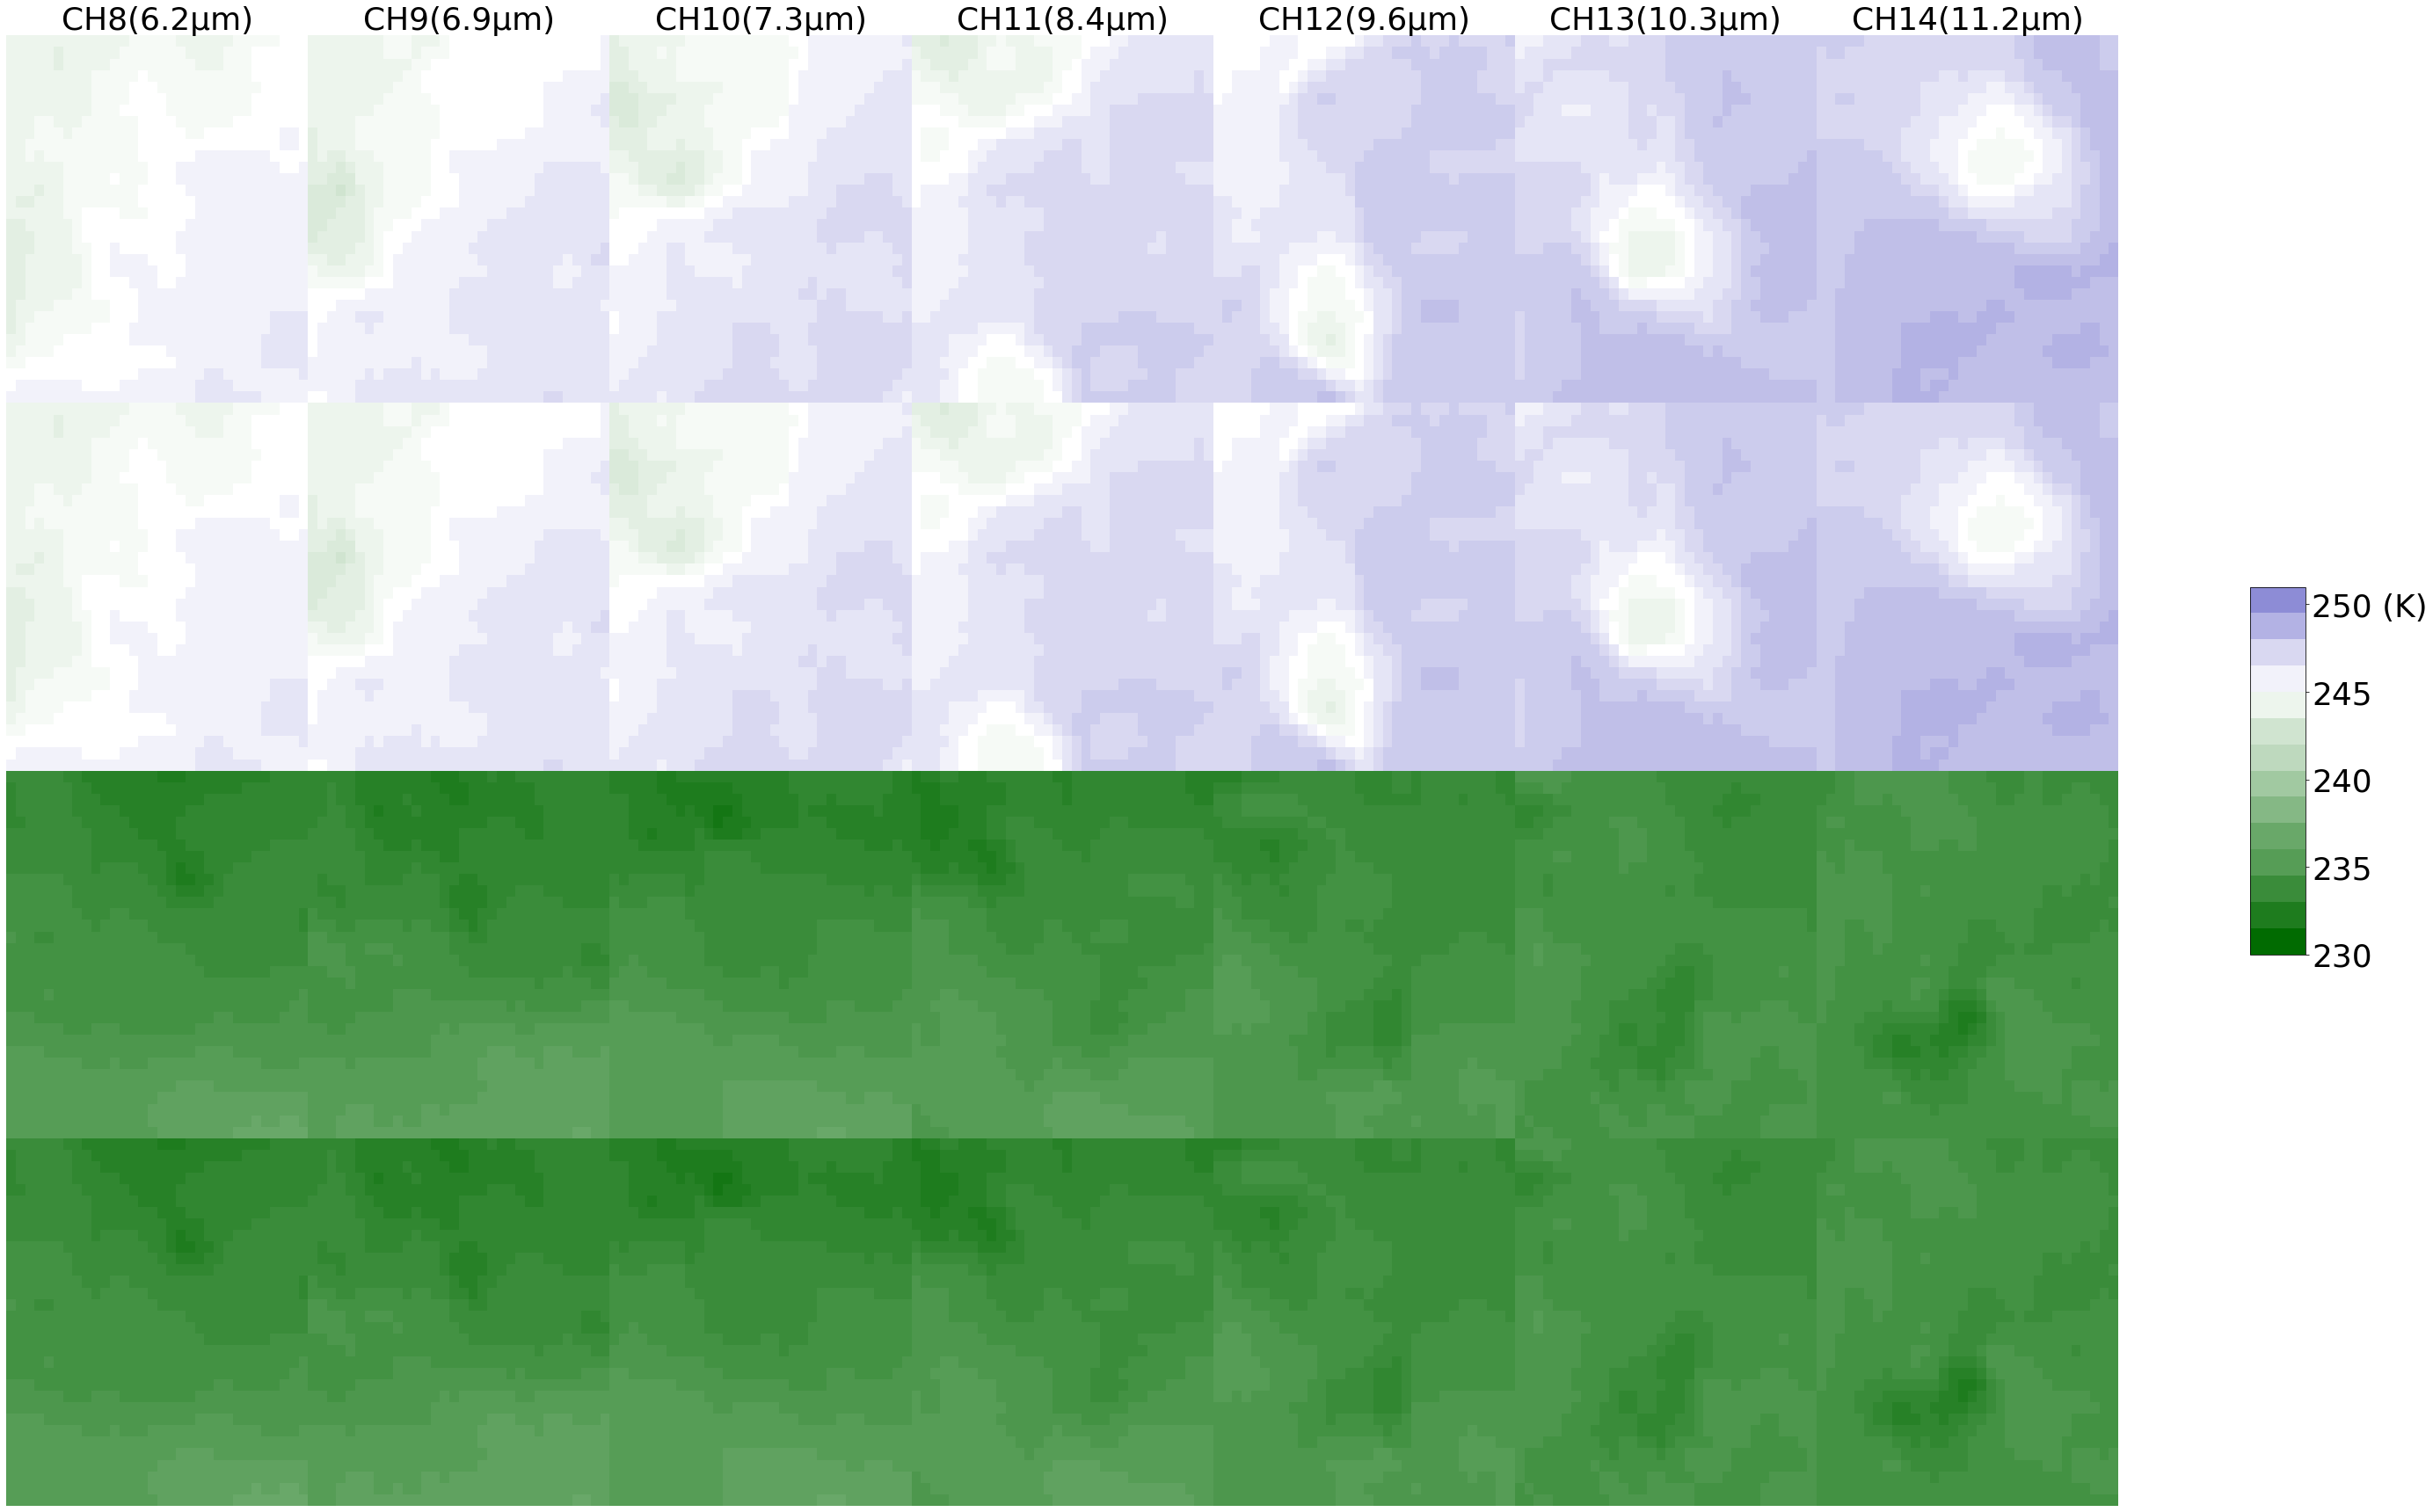

In [81]:
from metpy.plots import colortables
import matplotlib as mpl
#from metpy.plots import add_timestamp
index=test_lead10_all_indices["best_hit_indices"][0]
vmin = [205,210,220,195,201,190,190]
#[205.8, 205.9, 205.8, 185.2, 211.7, 200, 199.2]
#test_images_shuffled[index[0:10],:,:,7:14].min() # set min/max plotting range  
vmax = [300,315,315,365,315,385,385] 
#[300,315,315,365,315,385,385] #[292,310,325,365,315,385,385]
#[256.5, 265.9, 273.7, 306.5, 279.4, 326, 327]
#test_images_shuffled[index[0:10],:,:,7:14].max()
wavelength = [6.2, 6.9, 7.3, 8.4, 9.6, 10.3, 11.2]
row = 4#0
column = 7
#fig, ax = plt.subplots(3, 7, figsize=(42, 18))
#vmin=vmin[j], vmax=vmax[j]
# Use a colortable/colormap available from MetPy
vmin_all = 160
vmax_all = 410
#[210,290] [220,300] [225,305] [230,335]
#[230,249] [238,255] [242,262] [250,306]
WV_min = [210, 215, 220, 225]
WV_max = [290, 300, 305, 335]
#[210,290] [220,300] [225,305] [230,335]
fig, ax = plt.subplots(row,column, figsize=(6*column,6*row))
for i in range(row):
    for j in range(column):
            #all_images[index,:,:,i].plot(ax=ax.ravel()[i], vmin=vmin, vmax=vmax)#index[i] #vmin=vmin[j], vmax=vmax[j]
            #a = ax[i][j].contourf(test_colorbar, vmin=170, vmax=410, cmap=wv_cmap, N=500)#i*7
        wv_norm, wv_cmap = colortables.get_with_range('WVCIMSS_r',WV_min[0],WV_max[0])
        if i == 0 or i == 1:
            a = ax[i][6 - j].pcolormesh(np.squeeze(test_images_shuffled[test_lead10_all_indices["worst_false_alarm_indices"][0][73],:,:,ch[0]-8+j*7]), \
                                      cmap=wv_cmap, vmin=WV_min[0], vmax=WV_max[0])#265
        #if i == 3:
        #    a = ax[i][6 - j].contourf(np.squeeze(test_images_shuffled[test_lead10_all_indices["worst_false_alarm_indices"][0][73],:,:,ch[i]-8+j*7]), vmin=vmin_all, vmax=vmax_all,\
        #                              cmap=wv_cmap, norm=wv_norm, N=500)
        #else:
        else:
            a = ax[i][6 - j].pcolormesh(np.squeeze(test_images_shuffled[test_lead10_all_indices["best_hit_indices"][0][63],:,:,ch[0]-8+j*7]),\
                                      cmap=wv_cmap, vmin=WV_min[0], vmax=WV_max[0])
        #if j == column:
        #ax[i][j].axis('off')
        if i == 0:
            ax[i][j].set_title('CH'+str(j+8)+'('+str(wavelength[j])+'µm)',fontsize=36)
        #if j == 0:
        #ax[i][j].set_ylabel('-'+str((j+1)*10)+'0 min',fontsize=36)
        '''
        if i == 0 and j==0:
              ax[i][j].set_xticks((0, 10.33, 20.66, 31))
              ax[i][j].set_xticklabels(('0', '16', '32', '48 (km)'), fontsize=24)
              ax[i][j].set_yticks((0, 10.33, 20.66, 31))
              ax[i][j].set_yticklabels(('0', '16', '32', '48 (km)'), fontsize=24)
        else:
              ax[i][j].axis('off')
        '''
        ax[i][j].axis('off')
        #cbar = fig.colorbar(a, ax=ax[i][j])#, ticks=range(170, 410, 5))#vmin[j], vmax[j], 5))
        #tick_font_size = 20
        #cbar.ax.tick_params(labelsize=tick_font_size)
        #cbar.set_clim(190,320)
        #cbar.set_ticks(np.arange(210,291,20))
        #cbar.set_ticklabels( ('210', '230','250','270','290')) 
        #cbar.set_ticks(np.arange(190,320,20))
        #cbar.set_ticklabels( ('190', '210', '230','250','270','290','310'))  
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
#cbar_ax = fig.add_axes([0.1, 0.2, 0.8, 0.6])
#fig.colorbar(a, orientation="h", cax=cbar_ax)
cbar = fig.colorbar(a, ax=ax.ravel().tolist(),location="right",cmap = wv_cmap, shrink=0.25,  boundaries=np.arange(230,252.5,1.5), aspect=6.66)#, fontsize=20)
#fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
#cbar.mappable.set_clim(170,410)
tick_font_size = 36
cbar.ax.tick_params(labelsize=tick_font_size)
cbar.set_ticks(np.arange(230,250.5,5))
cbar.set_ticklabels( ('230', '235', '240', '245', '250 (K)')) 

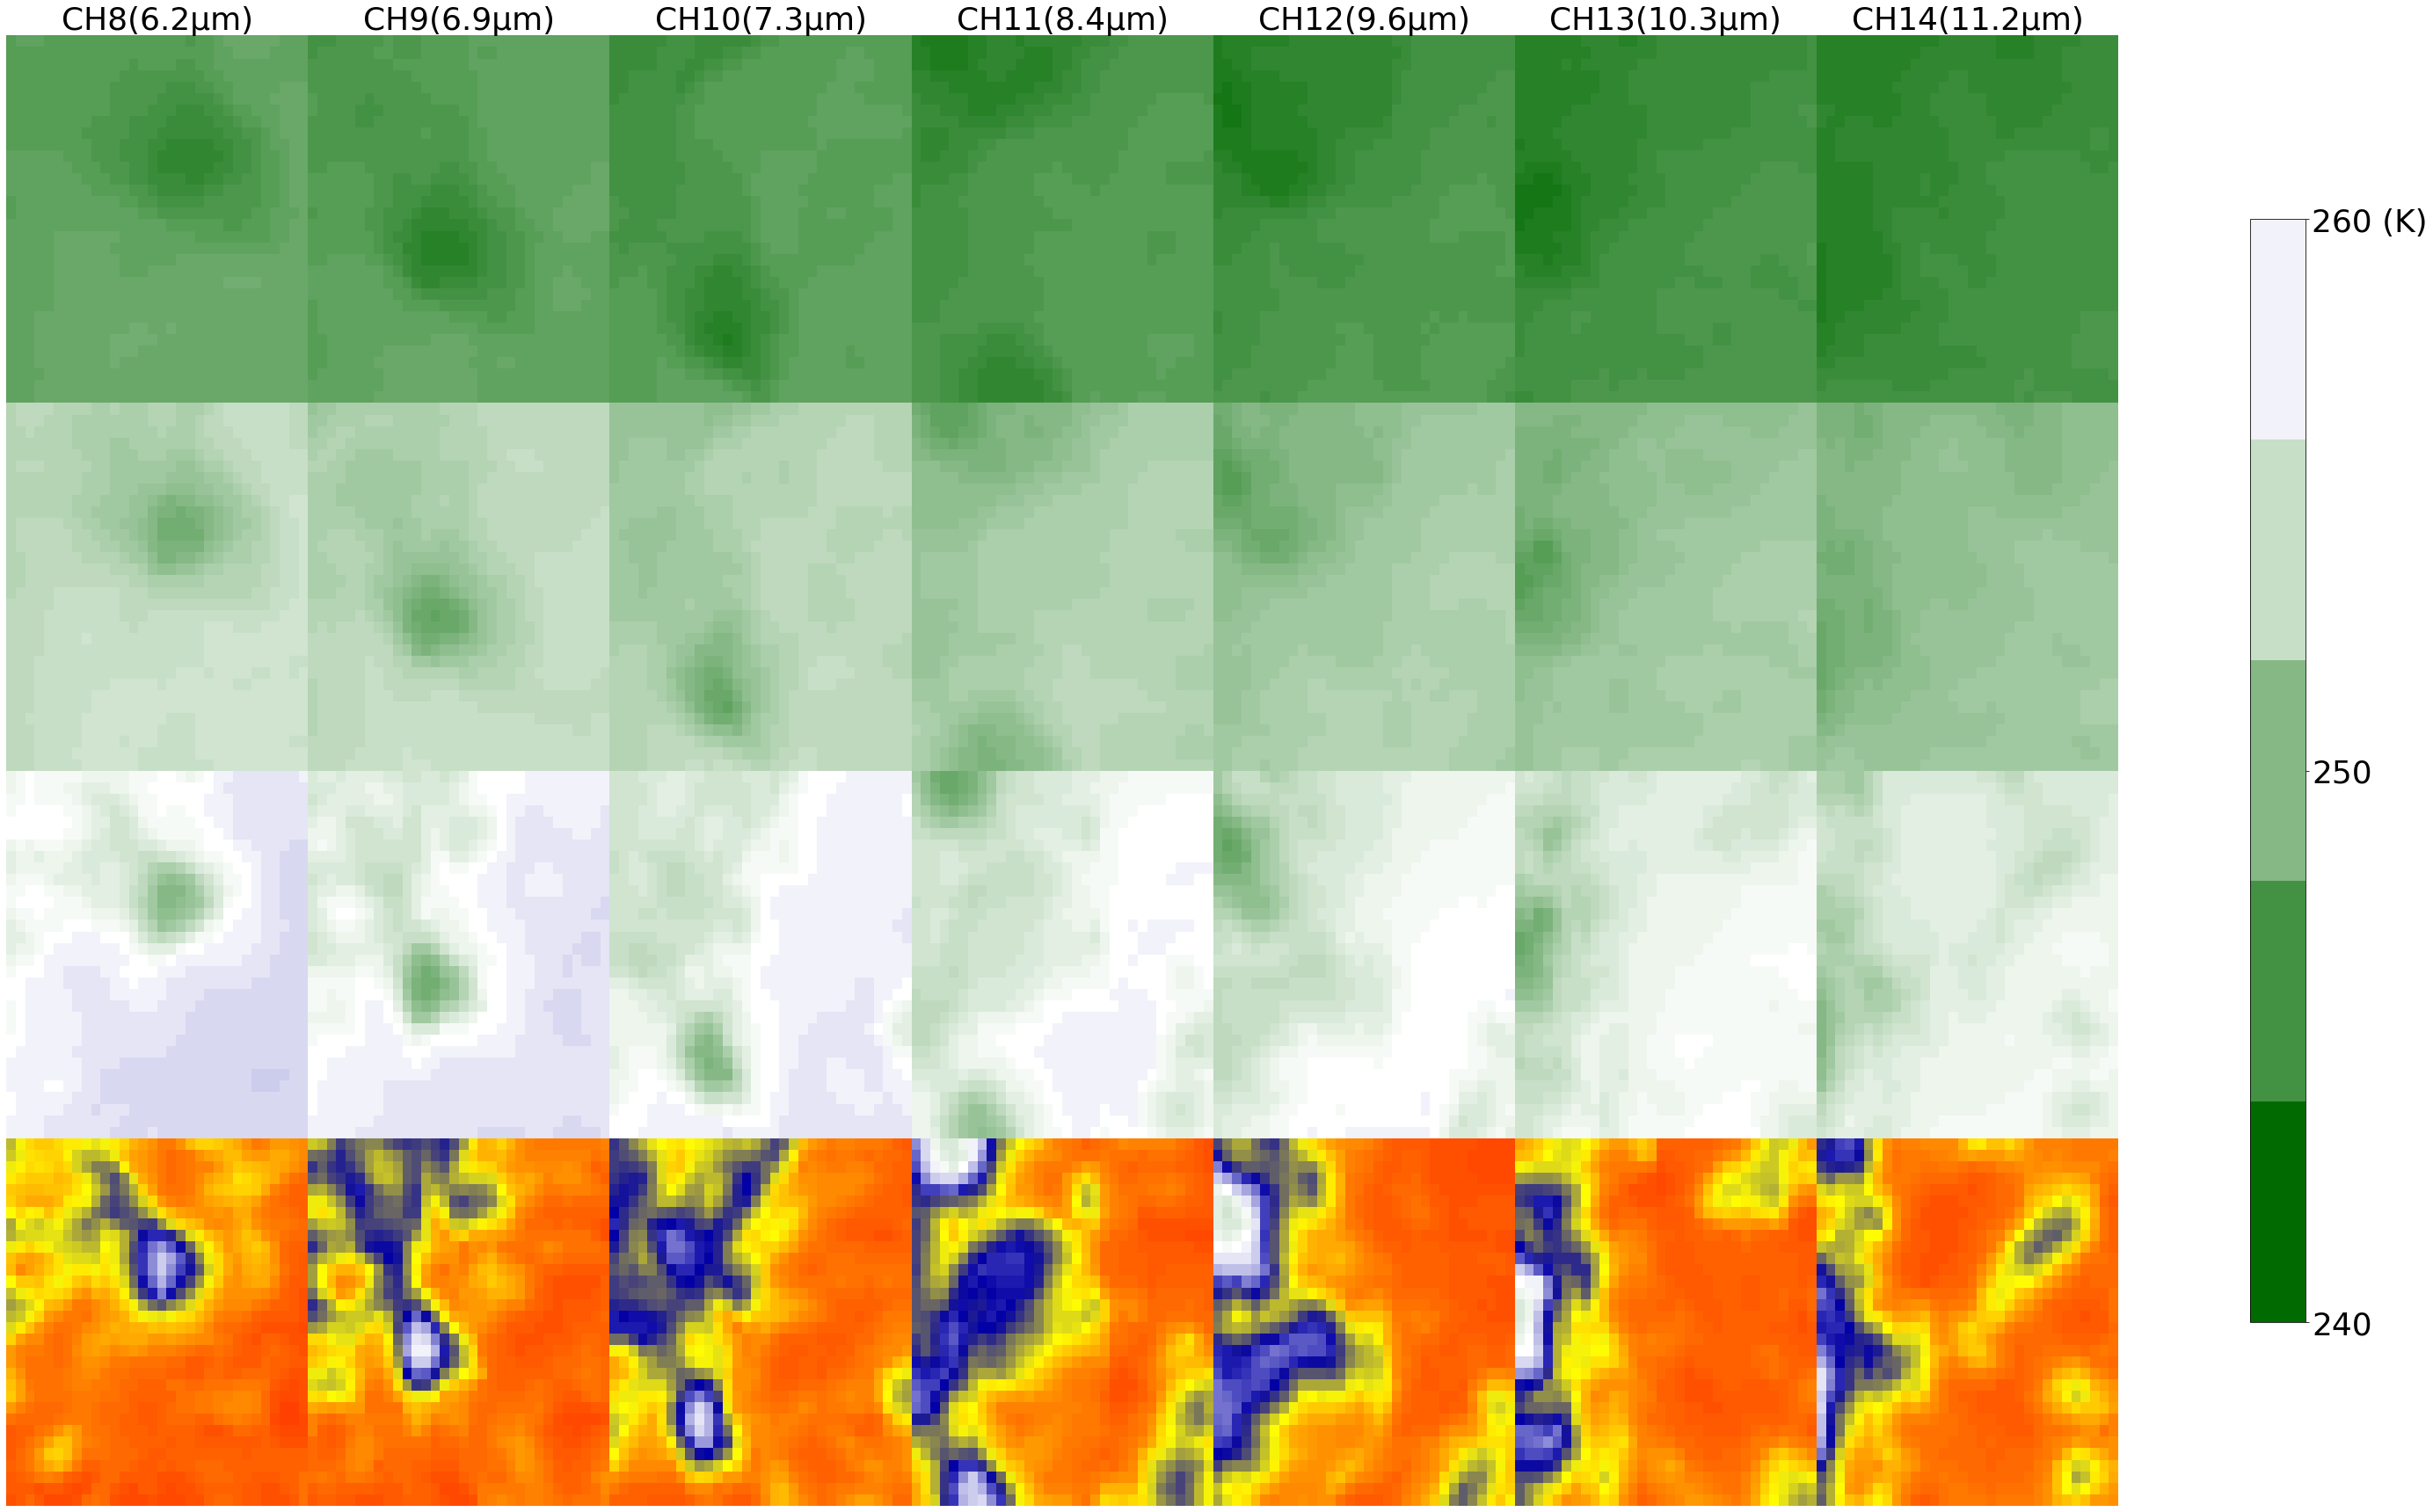

In [ ]:
#matplotlib.rcParams.update({'font.size': 24})
from metpy.plots import colortables
import matplotlib as mpl
#from metpy.plots import add_timestamp
index=test_lead10_all_indices["worst_false_alarm_indices"][0]
vmin = [205,210,220,195,201,190,190]
#[205.8, 205.9, 205.8, 185.2, 211.7, 200, 199.2]
#test_images_shuffled[index[0:10],:,:,7:14].min() # set min/max plotting range  
vmax = [300,315,315,365,315,385,385] 
#[300,315,315,365,315,385,385] #[292,310,325,365,315,385,385]
#[256.5, 265.9, 273.7, 306.5, 279.4, 326, 327]
#test_images_shuffled[index[0:10],:,:,7:14].max()
wavelength = [6.2, 6.9, 7.3, 8.4, 9.6, 10.3, 11.2]
row = 4#0
column = 7
#fig, ax = plt.subplots(3, 7, figsize=(42, 18))
#vmin=vmin[j], vmax=vmax[j]
# Use a colortable/colormap available from MetPy
wv_norm, wv_cmap = colortables.get_with_range('WVCIMSS_r', 220, 265)#265)
#im.set_cmap(wv_cmap)
#im.set_norm(wv_norm)
#ir_norm, ir_cmap = colortables.get_with_range('ir_drgb_r', 190, 265)
fig, ax = plt.subplots(row,column, figsize=(6*column,6*row))
for i in range(row):
    for j in range(column):
        #all_images[index,:,:,i].plot(ax=ax.ravel()[i], vmin=vmin, vmax=vmax)#index[i] #vmin=vmin[j], vmax=vmax[j]
        #a = ax[i][j].pcolormesh(test_colorbar, vmin=170, vmax=410, cmap=wv_cmap)#, N=500)
        a = ax[i][j].pcolormesh(np.squeeze(test_images_shuffled[index[73],:,:,ch[i]-8+j*7]), vmin=220, vmax=305, cmap=wv_cmap)#, N=500)#, shading="flat", edgecolors='None')#378
        #if j == column:
        #ax[i][j].axis('off')
        if i == 0:
            ax[i][j].set_title('CH'+str(j+8)+'('+str(wavelength[j])+'µm)',fontsize=36)
        #if j == 0:
        #ax[i][j].set_ylabel('-'+str((j+1)*10)+'0 min',fontsize=36)
        '''
        if i == 0 and j==0:
              ax[i][j].set_xticks((0, 10.33, 20.66, 31))
              ax[i][j].set_xticklabels(('0', '16', '32', '48 (km)'), fontsize=24)
              ax[i][j].set_yticks((0, 10.33, 20.66, 31))
              ax[i][j].set_yticklabels(('0', '16', '32', '48 (km)'), fontsize=24)
        else:
              ax[i][j].axis('off')
        '''
        ax[i][j].axis('off')
        #cbar = fig.colorbar(a, ax=ax[i][j])#, ticks=range(170, 410, 5))#vmin[j], vmax[j], 5))
        #tick_font_size = 20
        #cbar.ax.tick_params(labelsize=tick_font_size)
        #cbar.set_clim(190,320)
        #cbar.set_ticks(np.arange(210,291,20))
        #cbar.set_ticklabels( ('210', '230','250','270','290')) 
        #cbar.set_ticks(np.arange(190,320,20))
        #cbar.set_ticklabels( ('190', '210', '230','250','270','290','310'))  
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
#cbar_ax = fig.add_axes([0.1, 0.2, 0.8, 0.6])
#fig.colorbar(a, orientation="h", cax=cbar_ax)
cbar = fig.colorbar(a, ax=ax.ravel().tolist(),location="right",cmap = wv_cmap, shrink=0.75,  boundaries=np.arange(240,260.1,0.5))#, fontsize=20)
#fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
#cbar.mappable.set_clim(170,410)
tick_font_size = 36
cbar.ax.tick_params(labelsize=tick_font_size)
cbar.set_ticks(np.arange(240,261,10))
cbar.set_ticklabels( ('240', '250','260 (K)')) 

Text(0.5, 1.05, 'Lead time = 0min')

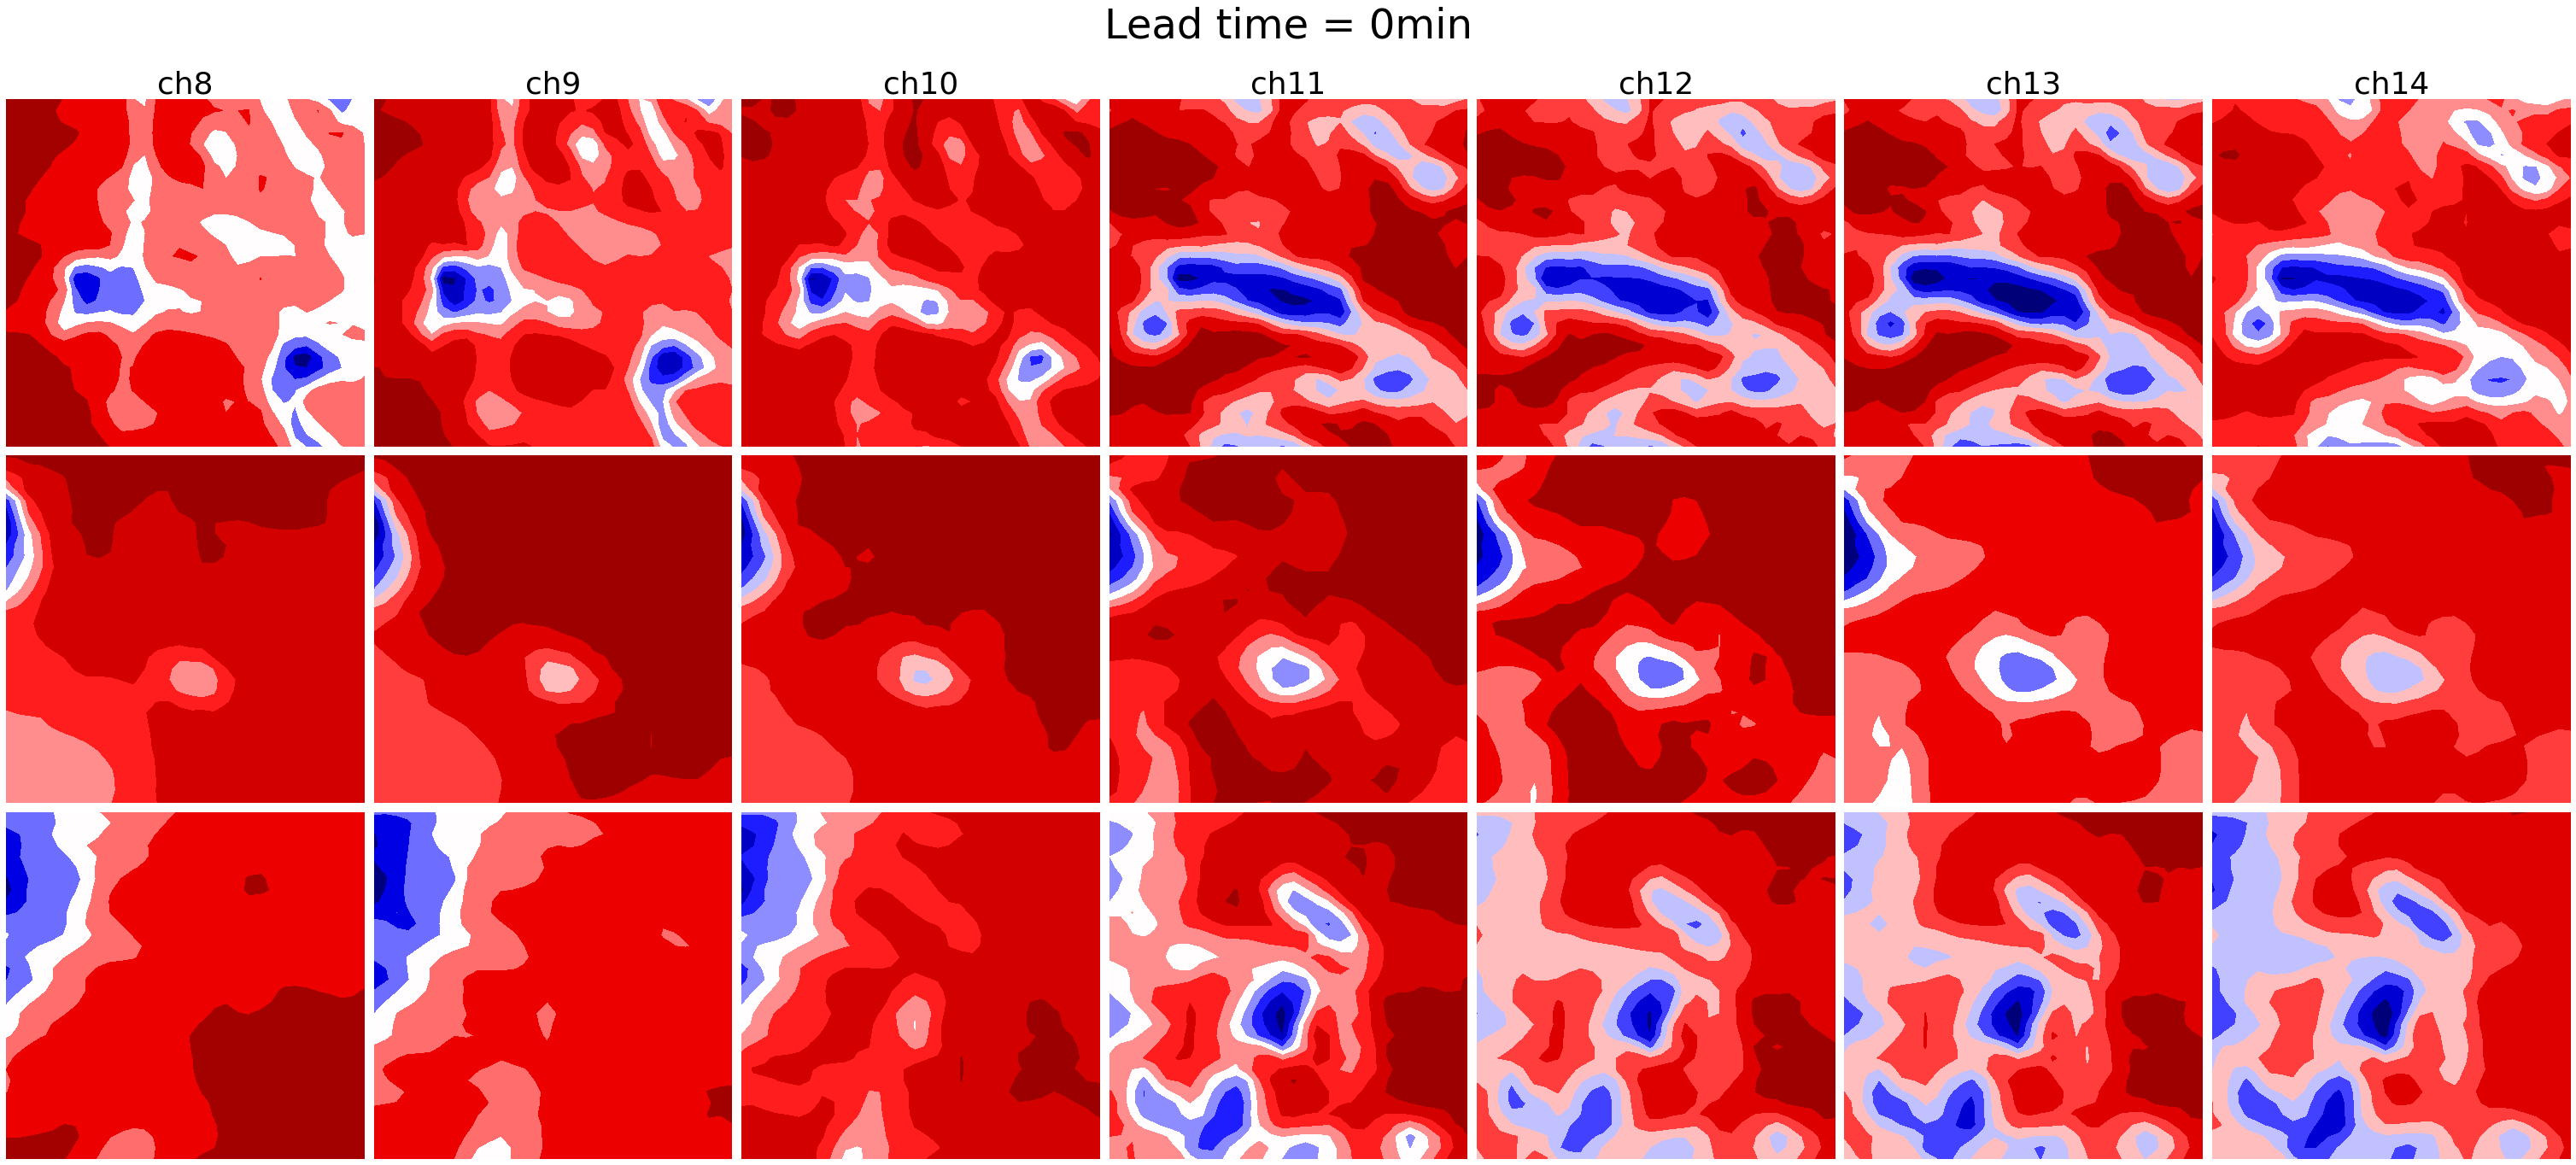

In [64]:
#matplotlib.rcParams.update({'font.size': 24})
%matplotlib inline
index=best_hit_indices
vmin = test_data[index[-10:],:,:,7:14].min() # set min/max plotting range  
vmax = test_data[index[-10:],:,:,7:14].max()

row = 3
column = 7
#fig, ax = plt.subplots(3, 7, figsize=(42, 18))
fig, ax = plt.subplots(row,column, figsize=(6*column,6*row))
for i in range(row):
    for j in range(column):
        #all_images[index,:,:,i].plot(ax=ax.ravel()[i], vmin=vmin, vmax=vmax)
        a = ax[i][j].contourf(test_data[index[-i],:,:,j+7], cmap='seismic', shading="flat", edgecolors='None', N=100)
        ax[i][j].axis('off')
        if i == 0:
            ax[i][j].set_title('ch'+str(j+8),fontsize=36)
plt.tight_layout()
fig.suptitle("Lead time = "+str((6-6)*10)+"min",fontsize=48,y=1.05)

In [74]:
vmin = np.min(test_data[index[-1:],:,:,7:14],axis=(0,1,2))
print(vmin)

[225.71567 231.31772 233.96571 238.48424 233.66711 240.55382 239.56522]


In [84]:
vmin_all = np.min(test_data[index[-10:],:,:,7:14],axis=(0,1,2)) # set min/max plotting range  
vmax_all = np.max(test_data[index[-10:],:,:,7:14],axis=(0,1,2))

In [10]:
vmin_all=[]
vmax_all=[]
index=worst_miss_indices
for i in range(7):
    vmin_all.append(np.min(test_data[index[-10:],:,:,i:49:7]))
    vmax_all.append(np.max(test_data[index[-10:],:,:,i:49:7]))

In [11]:
print(vmin_all)
print(vmax_all)

[210.85463, 211.07652, 211.7337, 213.21815, 223.071, 214.23505, 212.61136]
[244.44756, 254.1285, 261.3694, 298.98798, 272.10495, 304.49982, 300.92383]


In [101]:
a=np.array([0,1,2,3,4,5])
print(a[0:5:2])

[0 2 4]


In [111]:
print(vmin_all)
print(vmax_all)

[213.71498, 214.32565, 217.11517, 219.14194, 222.87907, 223.40672, 221.25464]
[248.35548, 258.18582, 264.59482, 299.4953, 271.0947, 304.28595, 301.8555]


In [50]:
30//5

6

In [46]:
range(len(files))

range(0, 30)

In [124]:
%matplotlib notebook
# Enable interactive plot
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
import matplotlib.ticker as mticker

plt.rcParams['font.size'] = '28'
index=worst_miss_indices

row = 1
column = 7
#fig, ax = plt.subplots(3, 7, figsize=(42, 18))
fig, ax = plt.subplots(row,column, figsize=(6*column,7*row))
fig.suptitle("Lead time = "+str((6-6)*10)+"min",fontsize=48,y=1.05)

def animate(k):
    i=4
    for j in range(column):
        #all_images[index,:,:,i].plot(ax=ax.ravel()[i], vmin=vmin, vmax=vmax)
        GOES_num = k//5
        a = ax[j].contourf(test_data[index[-i],:,:,j+7*(6-GOES_num)], cmap='seismic', 
                           shading="flat", edgecolors='None', N=100)#, vmin=vmin_all[j],
                              #vmax=vmax_all[j], N=100)
        ax[j].axis('off')
        #if i == 0:
        #    ax[i][j].set_title('ch'+str(j+8),fontsize=36)
    plt.tight_layout()
    fig.suptitle("Lead time = "+str((6-GOES_num)*10)+"min",fontsize=60)#,y=1.05)
    #return lines, timetext, #a1, lines[1], lines[2],
    #return line1,


ani = FuncAnimation(fig, animate, frames=range(len(files)),#range(7),
                    interval=400, repeat=True)
from IPython.display import HTML
HTML(ani.to_jshtml())
ani.save("plots/Worst_miss_animation_BN_1st_GOESR.gif", writer='imagemagick')

<IPython.core.display.Javascript object>

In [ ]:
class QuantileTransformer_2D(object):
    def __init__(self, *, n_quantiles=1000, output_distribution="uniform", subsample=int(1e5), random_state=None):
        self.n_quantiles = n_quantiles
        self.output_distribution = output_distribution
        self.random_state = random_state
        self.subsample = subsample
    def fit(self, x, y=None):
        """
        Calculate the values for the min/max transformation.
        """
        rng = check_random_state(self.random_state)
        n_samples = x.shape[0]
        self.n_quantiles_ = max(1, min(self.n_quantiles, n_samples))
        self.references_ = np.linspace(0, 1, self.n_quantiles_, endpoint=True)
        self._dense_fit(X, rng)
        
        variables = np.arange(x.shape[-1])
        self.scale_values = pd.DataFrame(0.0, index=variables, columns=["min", "max"])
        for v in variables:
            self.scale_values.loc[v, "min"] = float(x[:, :, :, v].min())
            self.scale_values.loc[v, "max"] = float(x[:, :, :, v].max())
            self.scale_values.loc[v, "range"] = self.scale_values.loc[v, "max"] - self.scale_values.loc[v, "min"]
    def _dense_fit(self, x):
        n_samples, _, _, n_features = x.shape
        references = self.references_ * 100

        self.quantiles_ = []
        for col in x.T:
            if self.subsample < n_samples:
                subsample_idx = random_state.choice(
                    n_samples, size=self.subsample, replace=False
                )
                col = col.take(subsample_idx, mode="clip")
            self.quantiles_.append(np.nanpercentile(col, references))
        self.quantiles_ = np.transpose(self.quantiles_)
        # Due to floating-point precision error in `np.nanpercentile`,
        # make sure that quantiles are monotonically increasing.
        # Upstream issue in numpy:
        # https://github.com/numpy/numpy/issues/14685
        self.quantiles_ = np.maximum.accumulate(self.quantiles_)
        
    def transform(self, x):
        """
        Apply the min/max scaling transformation.
        """
        if x.shape[-1] != self.scale_values.index.size:
            raise ValueError("Input x does not have the correct number of variables")
        x_new = np.zeros(x.shape, dtype=x.dtype)
        for v in self.scale_values.index:
            x_new[:, :, :, v] = (x[:, :, :, v] - self.scale_values.loc[v, "min"]) \
                / (self.scale_values.loc[v, "range"])
            if self.out_min != 0 or self.out_max != 1:
                x_new[:, :, :, v] = x_new[:, :, :, v] * self.out_range + self.out_min
        return x_new
    def fit_transform(self, x, y=None):
        self.fit(x, y)
        return self.transform(x)

In [22]:
from sklearn.preprocessing import QuantileTransformer
quantile = QuantileTransformer(output_distribution='normal')
test_data_reshape = test_data.reshape(len(test_data),1)
data_trans = quantile.fit_transform(test_data_reshape)

ValueError: cannot reshape array of size 802384896 into shape (13747,1)

In [16]:
%matplotlib notebook
# Enable interactive plot
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
import matplotlib.ticker as mticker

plt.rcParams['font.size'] = '28'
index=worst_miss_indices

row = 1
column = 1 #7
#fig, ax = plt.subplots(3, 7, figsize=(42, 18))
fig, ax = plt.subplots(row,column, figsize=(6*column,7*row))
figure = ax.contourf(-test_data[index[-i],:,:,j+7*(6-0)]+test_data[index[-i],:,:,j+7*(6-0-2)], cmap='seismic', 
                   shading="flat", edgecolors='None', N=100)
#fig.suptitle("Lead time = "+str((6-6)*10)+"min",fontsize=48,y=1.05)
fig.colorbar(figure, ax=ax)
def animate(k):
    i=4
    for j in range(column):
        #all_images[index,:,:,i].plot(ax=ax.ravel()[i], vmin=vmin, vmax=vmax)
        GOES_num = k//5
        figure = ax.contourf(-test_data[index[-i],:,:,j+7*(6-GOES_num)]+test_data[index[-i],:,:,j+7*(6-GOES_num-2)], cmap='seismic', 
                           shading="flat", edgecolors='None', N=100)#, vmin=vmin_all[j],
                           #vmax=vmax_all[j])
        ax.axis('off')
#        fig.colorbar(figure, ax=ax) 
        #if i == 0:
        #    ax[i][j].set_title('ch'+str(j+8),fontsize=36)
    plt.tight_layout()
    fig.suptitle("20-min diff at "+str((6-GOES_num-2)*10)+"min prior",fontsize=24)#,y=1.05)
    #return lines, timetext, #a1, lines[1], lines[2],
    #return line1,


ani = FuncAnimation(fig, animate, frames=range(len(files)-14),#range(7),
                    interval=400, repeat=True)
from IPython.display import HTML
HTML(ani.to_jshtml())
#ani.save("plots/Worst_miss_animation_AN_1st_GOESR_10_min.gif", writer='imagemagick')

<IPython.core.display.Javascript object>

TypeError: bad operand type for unary -: 'str'

In [ ]:
%matplotlib notebook
# Enable interactive plot
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
import matplotlib.ticker as mticker

plt.rcParams['font.size'] = '28'
index=worst_miss_indices

row = 1
column = 7
#fig, ax = plt.subplots(3, 7, figsize=(42, 18))
fig, ax = plt.subplots(row,column, figsize=(6*column,7*row))
fig.suptitle("Lead time = "+str((6-6)*10)+"min",fontsize=48,y=1.05)

def animate(k):
    i=4
    for j in range(column):
        #all_images[index,:,:,i].plot(ax=ax.ravel()[i], vmin=vmin, vmax=vmax)
        GOES_num = k//5
        a = ax[j].contourf(test_data[index[-i],:,:,j+7*(6-GOES_num)], cmap='seismic', 
                           shading="flat", edgecolors='None', N=100, vmin=vmin_all[j],
                           vmax=vmax_all[j])
        ax[j].axis('off')
        #if i == 0:
        #    ax[i][j].set_title('ch'+str(j+8),fontsize=36)
    plt.tight_layout()
    fig.suptitle("Lead time = "+str((6-GOES_num)*10)+"min",fontsize=60)#,y=1.05)
    #return lines, timetext, #a1, lines[1], lines[2],
    #return line1,


ani = FuncAnimation(fig, animate, frames=range(len(files)),#range(7),
                    interval=400, repeat=True)
from IPython.display import HTML
HTML(ani.to_jshtml())

In [ ]:
%matplotlib notebook
# Enable interactive plot
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
import matplotlib.ticker as mticker

plt.rcParams['font.size'] = '28'
index=best_hit_indices

row = 3
column = 7
#fig, ax = plt.subplots(3, 7, figsize=(42, 18))
fig, ax = plt.subplots(row,column, figsize=(6*column,6*row))
fig.suptitle("Lead time = "+str((6-6)*10)+"min",fontsize=48,y=1.05)

def animate(k):
    for i in range(row):
        for j in range(column):
            #all_images[index,:,:,i].plot(ax=ax.ravel()[i], vmin=vmin, vmax=vmax)
            a = ax[i][j].contourf(test_data[index[-i],:,:,j+7*(6-k)], cmap='seismic', 
                                  shading="flat", edgecolors='None', N=100)#, vmin=vmin_all[j],
                                  #vmax=vmax_all[j], N=100)
            ax[i][j].axis('off')
            #if i == 0:
            #    ax[i][j].set_title('ch'+str(j+8),fontsize=36)
    plt.tight_layout()
    fig.suptitle("Lead time = "+str((6-k)*10)+"min",fontsize=60)#,y=1.05)
    #return lines, timetext, #a1, lines[1], lines[2],
    #return line1,


ani = FuncAnimation(fig, animate, frames=range(7),
                    interval=2000, repeat=True)
from IPython.display import HTML
HTML(ani.to_jshtml())
#ani.save("plots/Best_Hits_animation_BN.gif", writer='imagemagick')

([<matplotlib.axis.XTick at 0x2b61ad645d10>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

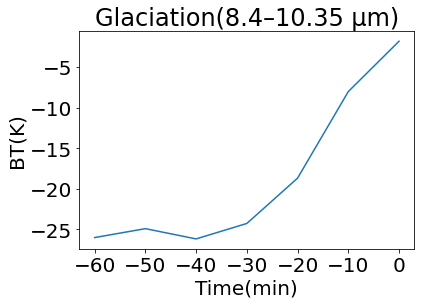

In [38]:
%matplotlib inline
a=np.zeros(7)
plt.rcParams['font.size'] = '20'
for i in range(7):
    a[i] = np.min(np.squeeze(test_images_shuffled[index[99],10:20,10:20,4+i*7]))-np.min(np.squeeze(test_images_shuffled[index[99],10:20,10:20,6+i*7]))
plt.plot(np.arange(-60, 1, 10),a[::-1])
plt.title('Glaciation(8.4–10.35 µm)')
plt.xlabel('Time(min)')
plt.ylabel('BT(K)')
plt.yticks(np.arange(-25,0,5))
plt.xticks(np.arange(-60,1,10))

([<matplotlib.axis.XTick at 0x2b9aa732c650>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

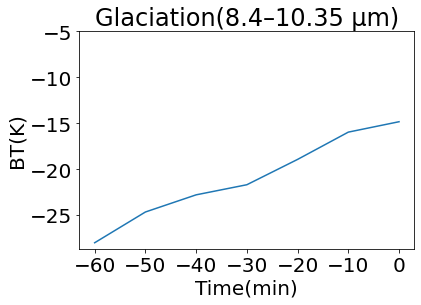

In [151]:
a=np.zeros(7)
plt.rcParams['font.size'] = '20'
for i in range(7):
    a[i] = np.min(np.squeeze(test_images_shuffled[index[10],10:20,10:20,4+i*7]))-np.min(np.squeeze(test_images_shuffled[index[10],10:20,10:20,6+i*7]))
plt.plot(np.arange(-60, 1, 10),a[::-1])
plt.title('Glaciation(8.4–10.35 µm)')
plt.xlabel('Time(min)')
plt.ylabel('BT(K)')
plt.yticks(np.arange(-25,0,5))
plt.xticks(np.arange(-60,1,10))

In [94]:
%matplotlib notebook
# Enable interactive plot
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
import matplotlib.ticker as mticker

wv_norm, wv_cmap = colortables.get_with_range('WVCIMSS_r', 220, 245)#265)
#im.set_cmap(wv_cmap)
#im.set_norm(wv_norm)
#ir_norm, ir_cmap = colortables.get_with_range('ir_drgb_r', 190, 265)
'''
fig, ax = plt.subplots(row,column, figsize=(8*column,6*row))
for i in range(row):
    for j in range(column):
        #all_images[index,:,:,i].plot(ax=ax.ravel()[i], vmin=vmin, vmax=vmax)#index[i] #vmin=vmin[j], vmax=vmax[j]
        #a = ax[i][j].contourf(test_colorbar, vmin=170, vmax=410, cmap=wv_cmap, N=500)#i*7
        a = ax[i][j].contourf(np.squeeze(test_images_shuffled[index[10],:,:,j+i*7]), vmin=170, vmax=410, cmap=wv_cmap, N=500)
'''        
plt.rcParams['font.size'] = '28'
'''
index=best_hit_indices
vmin_all=[]
vmax_all=[]
for i in range(7):
    vmin_all.append(np.min(test_data[index[-10:],:,:,i:49:7]))
    vmax_all.append(np.max(test_data[index[-10:],:,:,i:49:7]))
'''
row = 1
column = 7
#fig, ax = plt.subplots(3, 7, figsize=(42, 18))
fig, ax = plt.subplots(row,column, figsize=(5*column,6*row))
fig.suptitle("Lead time = "+str((6-6)*10)+"min",fontsize=48,y=1.05)
wv_norm, wv_cmap = colortables.get_with_range('WVCIMSS_r', 220, 245)

def animate(k):
    #for i in range(row):
    for j in range(column):
        #all_images[index,:,:,i].plot(ax=ax.ravel()[i], vmin=vmin, vmax=vmax)
        a = ax[j].contourf(np.squeeze(test_images_shuffled[index[10],:,:,j+(6-k)*7]), vmin=170, vmax=410, cmap=wv_cmap)#, N=500)
        '''
        a = ax[i][j].contourf(test_data[index[-i],:,:,j+7*(6-k)], cmap='seismic', 
                              shading="flat", edgecolors='None', vmin=vmin_all[j],
                              vmax=vmax_all[j], N=100)
        '''
        #ax[j].axis('off')
        ax[j].spines['top'].set_visible(True)
        ax[j].spines['right'].set_visible(True)
        ax[j].spines['bottom'].set_visible(True)
        ax[j].spines['left'].set_visible(True)
        ax[j].tick_params(left = False, right = False , labelleft = False ,
                        labelbottom = False, bottom = False)
        if j==0:
          ax[j].set_xticks((0, 10.33, 20.66, 31))
          ax[j].set_xticklabels(('0', '16', '32', '48 (km)'), fontsize=24)
          ax[j].set_yticks((0, 10.33, 20.66, 31))
          ax[j].set_yticklabels(('0', '16', '32', '48 (km)'), fontsize=24)
            #if i == 0:
            #    ax[i][j].set_title('ch'+str(j+8),fontsize=36)
    plt.tight_layout()
    if k < 6:
        fig.suptitle("t = $-$"+str((6-k)*10)+"min [P(ResNet) = "+str(np.floor(Res_target_preds[5-k]*1e3)/1e3)+", P(Logistic) = "+str(np.floor(Log_target_preds[5-k]*1e3)/1e3)+"]",fontsize=60)#,y=1.05)
    else:
        fig.suptitle("t = "+str((6-k)*10)+"min",fontsize=60)#,y=1.05)
    #return lines, timetext, #a1, lines[1], lines[2],
    #return line1,


ani = FuncAnimation(fig, animate, frames=range(7),
                    interval=2000, repeat=True)
from IPython.display import HTML
HTML(ani.to_jshtml())
ani.save("plots/Best_Hits_animation_case2.gif", writer='imagemagick')

<IPython.core.display.Javascript object>

In [57]:
np.floor(10.333*1000)/1000

10.333

In [17]:
import glob
from cartopy import crs as ccrs
from cartopy import feature as cfeature
latN = lat_target_1#42
latS = lat_target_0+0.01#39
lonW = lon_target_1-0.01#-96.0
lonE = lon_target_0#-99.0
cLat = (latN + latS)/2
cLon = (lonW + lonE )/2
colors = {0:'dodgerblue', 1:'red'}#, 2:'red', 3:'black'}

In [366]:
from metpy.plots import colortables
# READ AND PARSE HERE
ctable = ('NWSStormClearReflectivity',-20,0.45)#('NWSStormClearReflectivity', -20, 0.5)
norm, cmap = colortables.get_with_steps(*ctable)           
#cmap = colortables['NWSReflectivity']
print(cmap)

In [110]:
%matplotlib notebook

# Enable interactive plot
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
import matplotlib.ticker as mticker
from metpy.plots import colortables
# READ AND PARSE HERE
ctable = ('NWSStormClearReflectivity',-20,0.5)#('NWSStormClearReflectivity', -20, 0.5)
norm, cmap = colortables.get_with_steps(*ctable)           

plt.rcParams['font.size'] = '28'
#index=worst_miss_indices

row = 1
column = 1
#fig, ax = plt.subplots(3, 7, figsize=(42, 18))
fig,ax = plt.subplots(1,1, figsize=(5*column,6*row))
#fig.suptitle("Lead time = "+str((6-6)*10)+"min",fontsize=48,y=1.05)
#fig.colorbar(figure, ax=ax) 

def animate(i):
    #all_images[index,:,:,i].plot(ax=ax.ravel()[i], vmin=vmin, vmax=vmax)
    plt.gca().clear()
    if i>29:
        i=29
    #files[0:31:5]
    processed_file = nc.Dataset(os.path.join(My_dir,files[i]))
    dbz = processed_file.variables['MergedReflectivityQCComposite'][:]
    figure = ax.contourf(lon_grid[lat_index_1[0][0]:lat_index_0[0][0],lon_index_0[0][0]:lon_index_1[0][0]], 
                    lat_grid[lat_index_1[0][0]:lat_index_0[0][0],lon_index_0[0][0]:lon_index_1[0][0]], 
                    np.flipud(np.fliplr(dbz[lat_index_1[0][0]:lat_index_0[0][0],lon_index_0[0][0]:lon_index_1[0][0]].T)),
                    norm=norm, cmap=cmap,levels=(0, 5, 10, 15, 20,25,30,35,40,45,50))
                    #shading="flat", edgecolors='None', N=100)
            #if i == 0:
            #    ax[i][j].set_title('ch'+str(j+8),fontsize=36)
#    ax.axis('off')
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.tick_params(left = False, right = False , labelleft = False ,
                    labelbottom = False, bottom = False)
    plt.tight_layout()
    #if np.mod(i,5)==0:
    fig.suptitle("t = -"+str(60-(i+1)*2)+"min",fontsize=36)#,y=1.05)
    #else:
    #    fig.suptitle(files[i][:15],fontsize=24)#,y=1.05)
    #return lines, timetext, #a1, lines[1], lines[2],
    #return line1,


ani = FuncAnimation(fig, animate, frames=range(len(files)+5),
                    interval=400, repeat=True, blit=False)
from IPython.display import HTML
HTML(ani.to_jshtml())
ani.save("plots/Best_hits_animation_case1_dbz.gif", writer='imagemagick')

<IPython.core.display.Javascript object>

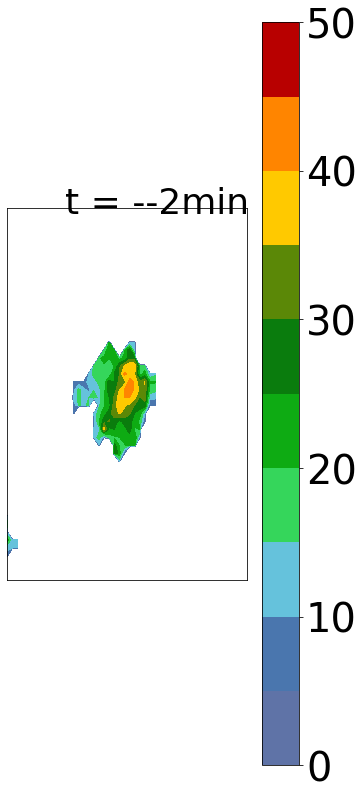

In [87]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
import matplotlib.ticker as mticker
from metpy.plots import colortables
# READ AND PARSE HERE
ctable = ('NWSStormClearReflectivity',-20,0.45)#('NWSStormClearReflectivity', -20, 0.5)
norm, cmap = colortables.get_with_steps(*ctable)           

plt.rcParams['font.size'] = '28'
#index=worst_miss_indices
i=30

row = 1
column = 1
#fig, ax = plt.subplots(3, 7, figsize=(42, 18))
fig,ax = plt.subplots(1,1, figsize=(5*column,6*row))
#fig.suptitle("Lead time = "+str((6-6)*10)+"min",fontsize=48,y=1.05)
#fig.colorbar(figure, ax=ax) 

#files[0:31:5]
processed_file = nc.Dataset(os.path.join(My_dir,files[i]))
dbz = processed_file.variables['MergedReflectivityQCComposite'][:]
figure = ax.contourf( 
                np.flipud(np.fliplr(dbz[lat_index_1[0][0]:lat_index_0[0][0],lon_index_0[0][0]:lon_index_1[0][0]].T)),
                norm=norm, cmap=cmap,levels=(0, 5, 10, 15, 20,25,30,35,40,45,50))
                #shading="flat", edgecolors='None', N=100)
        #if i == 0:
        #    ax[i][j].set_title('ch'+str(j+8),fontsize=36)
#    ax.axis('off')
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)

plt.tight_layout()
#if np.mod(i,5)==0:
fig.suptitle("t = -"+str(60-(i+1)*2)+"min",fontsize=36)#,y=1.05)
cbar = fig.colorbar(figure,location="right",cmap = cmap, shrink=2, extend='both', boundaries=np.arange(0,45,5))#, fontsize=20)
#fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
#cbar.mappable.set_clim(170,410)
tick_font_size = 40
cbar.ax.tick_params(labelsize=tick_font_size)
cbar.set_ticks(np.arange(0,51,10))
#cbar.set_ticklabels( ('230', '250','270','290')) 


In [97]:
len(files)

30

In [44]:
2020-07-23 19:00:16 33.97 -99.78 33.49 -99.3

30

In [71]:
My_dir = '/glade/scratch/fanda/files/MergedReflectivityQCComposite/17/MergedReflectivityQCComposite/00.50'
testfiles = [f for f in listdir(My_dir) if isfile(join(My_dir, f))]
#testfiles.sort
files = []
for i in testfiles:
    if i[9:15]>'101620' and i[9:15]<'111820':
    #if i[9:15]>'184600' and i[9:15]<'194800':
    #if i[9:15]>'143520' and i[9:15]<'153720':
    #if i[9:15]>'065340' and i[9:15]<'075540':
        files.append(i)
files=sorted(files)
print(len(files))
processed_file=nc.Dataset(os.path.join(My_dir,files[0]))
dbz = processed_file.variables['MergedReflectivityQCComposite'][:]
interval = processed_file.LatGridSpacing
lon_grid, lat_grid = np.meshgrid(np.arange(processed_file.Longitude,processed_file.Longitude+interval*np.shape(dbz)[1],interval),
                                 np.arange(processed_file.Latitude,processed_file.Latitude-interval*np.shape(dbz)[0],-interval))

31


In [29]:
print(files[0:31:5])

['20210621-024241.netcdf', '20210621-025241.netcdf', '20210621-030239.netcdf', '20210621-031240.netcdf', '20210621-032241.netcdf', '20210621-033240.netcdf', '20210621-034242.netcdf']


In [72]:
#43.23 -98.14 42.75 -97.66
#19:00:16 33.97 -99.78 33.49 -99.3
#12:44:48 34.28 -98.92 33.8 -98.44
#2020-07-23 18:30:24 43.53 -103.37 43.05 -102.89
#2020-07-23 17:37:04 36.04 -98.38 35.56 -97.9
lat_target_0 = lat_center-0.24#42.75-0.1#34.93#39#34.93 43.23 -98.14 42.75 -97.66
lat_target_1 = lat_center+0.24 #43.23+0.1#35.41#42#35.41+0.01
lon_target_0 = lon_center-0.24#-98.14-0.1#-98.79#-99#-98.79
lon_target_1 = lon_center+0.24#-97.66+0.1#-98.31#-96#-98.31-0.01
lon_1d = np.arange(processed_file.Longitude,processed_file.Longitude+interval*np.shape(dbz)[1],interval)
lat_1d = np.arange(processed_file.Latitude,processed_file.Latitude-interval*np.shape(dbz)[1],-interval)
lat_index_0 = np.where(np.abs(lat_1d-lat_target_0)<0.001)
lat_index_1 = np.where(np.abs(lat_1d-lat_target_1)<0.001)
lon_index_0 = np.where(np.abs(lon_1d-lon_target_0)<0.001)
lon_index_1 = np.where(np.abs(lon_1d-lon_target_1)<0.001)

In [78]:
import datetime
def time_plus_2h(initial_date):
    return str(datetime.datetime.strptime(initial_date,'%Y-%m-%d %H:%M:%S')+datetime.timedelta(hours=2))
i=82
lon_center = lon_0[index[i]]
lat_center = lat_0[index[i]]
print(time_plus_2h(str(datetime.datetime.fromtimestamp(date_0[index[i]]))))
print(lon_0[index[i]])
print(lat_0[index[i]])
My_dir = '/glade/scratch/fanda/files/MergedReflectivityQCComposite/17/MergedReflectivityQCComposite/00.50'
testfiles = [f for f in listdir(My_dir) if isfile(join(My_dir, f))]
#testfiles.sort
files = []
for i in testfiles:
    if i[9:15]>'101620' and i[9:15]<'111820':
    #if i[9:15]>'184600' and i[9:15]<'194800':
    #if i[9:15]>'143520' and i[9:15]<'153720':
    #if i[9:15]>'065340' and i[9:15]<'075540':
        files.append(i)
files=sorted(files)
print(len(files))
processed_file=nc.Dataset(os.path.join(My_dir,files[0]))
dbz = processed_file.variables['MergedReflectivityQCComposite'][:]
interval = processed_file.LatGridSpacing
lon_grid, lat_grid = np.meshgrid(np.arange(processed_file.Longitude,processed_file.Longitude+interval*np.shape(dbz)[1],interval),
                                 np.arange(processed_file.Latitude,processed_file.Latitude-interval*np.shape(dbz)[0],-interval))
lat_target_0 = lat_center-0.24#42.75-0.1#34.93#39#34.93 43.23 -98.14 42.75 -97.66
lat_target_1 = lat_center+0.24 #43.23+0.1#35.41#42#35.41+0.01
lon_target_0 = lon_center-0.24#-98.14-0.1#-98.79#-99#-98.79
lon_target_1 = lon_center+0.24#-97.66+0.1#-98.31#-96#-98.31-0.01
lon_1d = np.arange(processed_file.Longitude,processed_file.Longitude+interval*np.shape(dbz)[1],interval)
lat_1d = np.arange(processed_file.Latitude,processed_file.Latitude-interval*np.shape(dbz)[1],-interval)
lat_index_0 = np.where(np.abs(lat_1d-lat_target_0)<0.001)
lat_index_1 = np.where(np.abs(lat_1d-lat_target_1)<0.001)
lon_index_0 = np.where(np.abs(lon_1d-lon_target_0)<0.001)
lon_index_1 = np.where(np.abs(lon_1d-lon_target_1)<0.001)

2021-06-17 11:17:20
-100.04
44.66
31


In [81]:
error_range = 0
for i in range(100):
    lon_center = lon_0[index[i]]
    lat_center = lat_0[index[i]]
    #print(time_plus_2h(str(datetime.datetime.fromtimestamp(date_0[index[i]]))))
    #print(lon_0[index[i]])
    #print(lat_0[index[i]])
    if lon_center > -91-0.5 or lon_center < -104+0.5 or lat_center > 48-0.5 or lat_center <34+0.5:
        print(i)
        error_range+=1
print(error_range)

0
1
2
3
7
13
14
17
29
32
33
40
47
52
57
58
60
61
65
69
72
85
97
23


In [8]:
import datetime
def time_plus_2h(initial_date):
    return str(datetime.datetime.strptime(initial_date,'%Y-%m-%d %H:%M:%S')+datetime.timedelta(hours=2))
#index = worst_miss_indices
for i in range(10):
    print(index[-i])
    print(i)
    date_time = time_plus_2h(str(datetime.datetime.fromtimestamp(date_0[index[-i]])))
    print(date_time,np.round(lat_0[index[-i]]+0.24,2),np.round(lon_0[index[-i]]-0.24,2),
          np.round(lat_0[index[-i]]-0.24,2),np.round(lon_0[index[-i]]+0.24,2))
    #print("\n")

9080
0
2021-06-17 20:29:52 35.83 -93.05 35.35 -92.57
32701
1
2021-06-16 07:54:40 43.51 -96.78 43.03 -96.3
1275
2
2021-06-21 01:49:52 39.9 -94.78 39.42 -94.3
12554
3
2021-06-16 11:25:52 41.51 -95.32 41.03 -94.84
30519
4
2021-06-10 15:09:52 46.6 -94.74 46.12 -94.26
6291
5
2021-06-20 22:35:44 40.21 -95.39 39.73 -94.91
28262
6
2021-06-10 22:59:12 43.32 -92.46 42.84 -91.98
8884
7
2021-06-10 21:04:00 35.99 -93.06 35.51 -92.58
31519
8
2021-06-01 22:57:04 40.97 -104.17 40.49 -103.69
21406
9
2021-06-27 21:38:08 45.21 -99.58 44.73 -99.1


In [204]:
print((43.23+42.75)/2)
print((-98.14+-97.66)/2)

42.989999999999995
-97.9


In [218]:
datetime.datetime.fromtimestamp(0)

datetime.datetime(1969, 12, 31, 17, 0)

In [15]:
import datetime
def time_plus_2h(initial_date):
    return str(datetime.datetime.strptime(initial_date,'%Y-%m-%d %H:%M:%S')+datetime.timedelta(hours=2))
processed_file = nc.Dataset('/glade/scratch/fanda/files/GOESR_HRRR_PC/test/23_CI.nc_07')
date_1 = processed_file.variables['date'][:]
num = 0
for i in range(len(date_1)):
    date_time = time_plus_2h(str(datetime.datetime.fromtimestamp(date_1[i])))
    if str(date_time)>'2020-07-23 09:00:00' and str(date_time)<'2020-07-23 10:00:00':
        num+=1
        print(processed_file.variables['lat_0'][:][i], processed_file.variables['lon_0'][:][i], date_0[i], str(date_time))
print(num)

42.26 -96.85 1595509600.0 2020-07-23 09:07:12
42.0 -97.82 1595510800.0 2020-07-23 09:26:24
35.05 -93.19 1595510400.0 2020-07-23 09:20:00
42.66 -98.34 1595511000.0 2020-07-23 09:30:40
41.29 -97.29 1595511900.0 2020-07-23 09:45:36
42.74 -99.14 1595512200.0 2020-07-23 09:49:52
43.86 -97.51 1595512700.0 2020-07-23 09:58:24
44.44 -96.81 1595512000.0 2020-07-23 09:47:44
34.79 -93.52 1595510700.0 2020-07-23 09:24:16
42.15 -98.95 1595509200.0 2020-07-23 09:00:48
43.05 -96.97 1595512200.0 2020-07-23 09:49:52
44.09 -98.13 1595510500.0 2020-07-23 09:22:08
34.95 -93.23 1595510100.0 2020-07-23 09:15:44
13


In [223]:
date_time

datetime.datetime(2020, 7, 23, 10, 49, 4, tzinfo=datetime.timezone(datetime.timedelta(seconds=7200)))

In [217]:
str(datetime.datetime.fromtimestamp(1595510800.0))

'2020-07-23 07:26:40'

In [ ]:
best_correct_null_indices

In [16]:
best_correct_null_indices

array([ 8527,  3886,  5123,  5879,  2420,  5584,  1105,  6506, 10266,
        9404,  8366,  3215,   880,  8443,  9860, 12278, 10078,  9252,
        5182,  7046,  3558, 12730,  4125,  3455,  3517,  9674,  2550,
        4459,    98, 11356, 11232,  4772, 11103, 13704, 12815,  8420,
       10907,  5976,  5002,  5535,  7389,   119,  4583,  1097,  4019,
        8796,  3968,  3762,   160,  3227,  1246, 12760,  7797,  8782,
        7851,  7041,  5511,  1238, 11967,  9864, 10413,  5067,  4452,
        6145,  8090, 10443, 11670,  6908,  6003,    50,  6555,  3315,
       11534,  4345, 11059,  3054, 10623, 11834,  9722,  5572,  7713,
       12689,  4850,   464, 11183,  7137,  1149,  4310,  6967,  6447,
        4065,  9583,  1375, 11727,  1719,  4486, 11186, 10436,  2528,
        8313])

In [12]:
# Best hits
pmm_best_hits_matrix_denorm = utils.run_pmm_many_variables(test_data_scaled[best_hit_indices])
# Worst false alarms
pmm_worst_false_alarm_matrix_denorm = utils.run_pmm_many_variables(test_data_scaled[worst_false_alarm_indices])
# Worst misses
pmm_worst_miss_matrix_denorm = utils.run_pmm_many_variables(test_data_scaled[worst_miss_indices])
# Best correst nulls
pmm_best_correct_null_matrix_denorm = utils.run_pmm_many_variables(test_data_scaled[best_correct_null_indices])

best_hits_matrix_norm=test_data_scaled[best_hit_indices]
worst_false_alarm_matrix_norm=test_data_scaled[worst_false_alarm_indices]
worst_miss_matrix_norm=test_data_scaled[worst_miss_indices]
best_correct_null_matrix_norm=test_data_scaled[best_correct_null_indices]

In [60]:
best_correct_null_matrix_norm.shape

(10, 32, 32, 7)

In [ ]:
preds[indices[ind]]

In [53]:
pmm_best_hits_matrix_denorm = utils.run_pmm_many_variables(test_data_scaled[best_hit_indices])
best_hits_matrix_norm=test_data_scaled[best_hit_indices]
best_hits_matrix_norm=test_data_scaled[best_hit_indices]

In [ ]:
print(my_model.layers[-1].name)

In [ ]:
tf.compat.v1.disable_eager_execution()
tf.compat.v1.experimental.output_all_intermediates(True)

In [9]:
def input_times_grad(matrix_norm, pmm_matrix_denorm ):
  saliency_matrix = utils.get_saliency_one_neuron(
      model_object=my_model,
      predictor_matrix=matrix_norm,
      layer_name=my_model.layers[-1].name,
      neuron_indices=np.array([0], dtype=int),
      ideal_activation=1.
  )
  input_times_grad_matrix = (saliency_matrix * matrix_norm)

  input_times_grad_matrix = utils.run_pmm_many_variables(
      field_matrix=input_times_grad_matrix
  )
  input_times_grad_matrix = saliency.smooth_saliency_maps(
      saliency_matrices=[input_times_grad_matrix],
      smoothing_radius_grid_cells=1
  )[0]
  print(np.shape(pmm_matrix_denorm))
  print(np.shape(input_times_grad_matrix))
        
  #plot_storm_xai(pmm_matrix_denorm, input_times_grad_matrix)
  return input_times_grad_matrix

In [19]:
import tensorflow.python.keras.backend as K
gradient_tensors = K.gradients(loss_tensor, input_tensors)

NameError: name 'loss_tensor' is not defined

In [24]:
print(my_model.layers[-1].name)
neuron_indices=np.array([0], dtype=int)
print(neuron_indices)
print(np.shape(best_hits_matrix_norm[0:101,:,:,:]))


activation_output
[0]
(100, 32, 32, 7)


In [35]:
np.shape(best_hits_matrix_norm)

(100, 32, 32, 7)

In [155]:
input_times_grad_matrix = input_times_grad(worst_miss_matrix_norm, pmm_worst_miss_matrix_denorm)#[0:101,:,:,:]

Have computed saliency maps for 0 of 100 examples...
Have computed saliency maps for all 100 examples!
(32, 32, 7)
(32, 32, 7)


In [157]:
import shap
# Plot first 5 samples
#plot_storm_xai_batch(Xplot[0:5], shap_values[0:5].values)
X = worst_miss_matrix_norm
#Xplot = worst_false_alarm_matrix_denorm
# Evaluate 
masker_uniform_0  = shap.maskers.Image(np.zeros_like(X[0]), X[0].shape, partition_scheme=1)
#masker_blur_32x32 = shap.maskers.Image("blur(32, 32)", X[0].shape, partition_scheme=1)
shap_values = explain_multiband(X, masker_uniform_0)
# Plot first 5 samples
#plot_storm_xai_batch(Xplot[0:5], shap_values[0:5].values)

Partition explainer: 101it [03:39,  2.29s/it]                         


In [29]:
best_correct_null_matrix_norm.shape

(100, 32, 32, 7)

In [21]:
shap_values_pmm.shape

(32, 32, 7, 1)

'\n# Best hits\npmm_best_hits_matrix_denorm = utils.run_pmm_many_variables(test_data_scaled[best_hit_indices])\n# Worst false alarms\npmm_worst_false_alarm_matrix_denorm = utils.run_pmm_many_variables(test_data_scaled[worst_false_alarm_indices])\n# Worst misses\npmm_worst_miss_matrix_denorm = utils.run_pmm_many_variables(test_data_scaled[worst_miss_indices])\n# Best correst nulls\npmm_best_correct_null_matrix_denorm = utils.run_pmm_many_variables(test_data_scaled[best_correct_null_indices])\n'

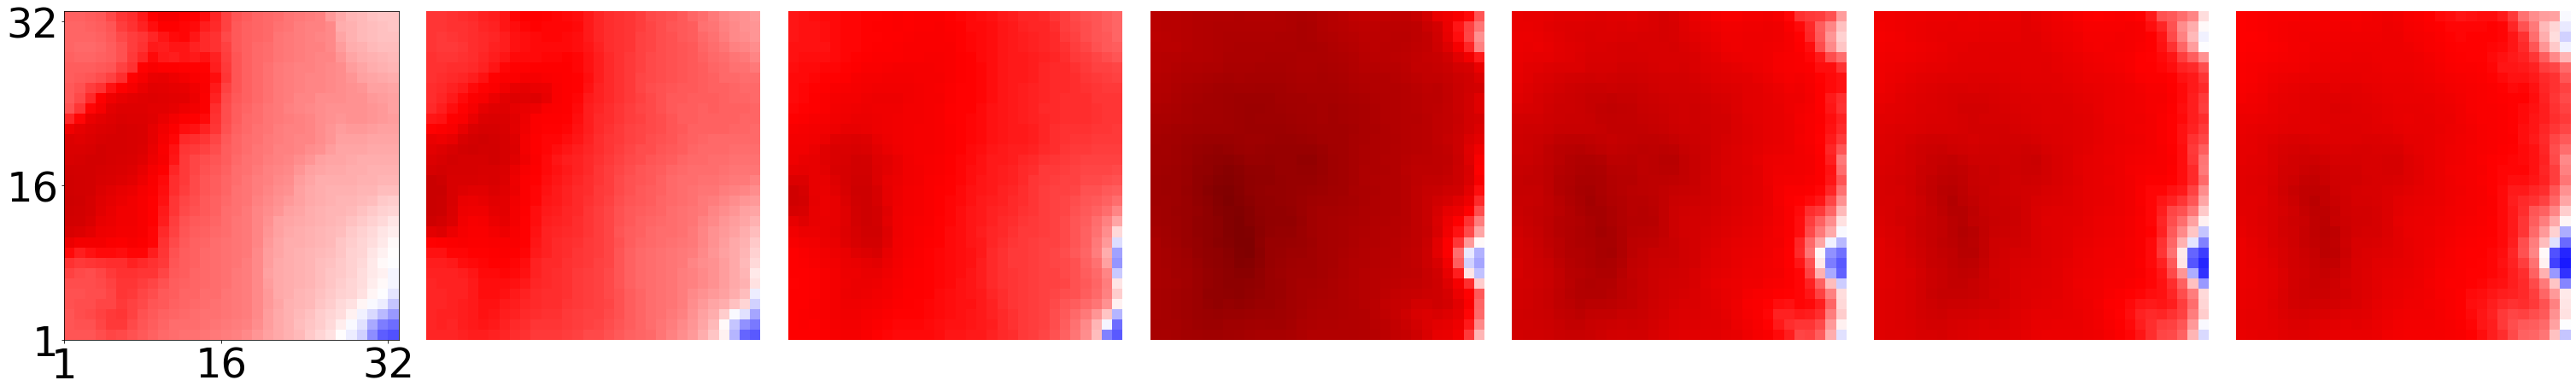

In [54]:
def plot_storm_xai_test(values):
  '''
    values: M-by-N-by-4
    shap_values: M-by-N-by-4
  '''

  from shap.plots import colors
  import matplotlib

  THIS_COLOUR_LIST = [
    np.array([4, 233, 231]), np.array([1, 159, 244]),
    np.array([3, 0, 244]),   np.array([2, 253, 2]),
    np.array([1, 197, 1]),   np.array([0, 142, 0]),
    np.array([253, 248, 2]), np.array([229, 188, 0]),
    np.array([253, 149, 0]), np.array([253, 0, 0]),
    np.array([212, 0, 0]),   np.array([188, 0, 0]),
    np.array([248, 0, 253]), np.array([152, 84, 198])
  ]
  for p in range(len(THIS_COLOUR_LIST)):
    THIS_COLOUR_LIST[p] = THIS_COLOUR_LIST[p].astype(float) / 255

  REFL_COLOUR_MAP_OBJECT = matplotlib.colors.ListedColormap(THIS_COLOUR_LIST)
  REFL_COLOUR_MAP_OBJECT.set_under(np.ones(3))
  THESE_COLOUR_BOUNDS = np.array([
      0.1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70
  ])
  REFL_COLOUR_NORM_OBJECT = matplotlib.colors.BoundaryNorm(
      THESE_COLOUR_BOUNDS, REFL_COLOUR_MAP_OBJECT.N
  )

  fig, ax = plt.subplots(1, 7, figsize=(42, 6.5))#56, 18)

  values = copy.deepcopy(values)
  values = np.squeeze(values)
    
  # Reflectivity
  #ax[0][0].set_title("CH8 BT")
  im = ax[0].pcolormesh((1-values[:,:,0]), 
                      cmap='seismic',
                      norm=None,
                      vmin=0.24,#np.min(1-values[:,:,0]),
                      vmax=1,#np.max(1-values[:,:,0]),
                      shading="flat", edgecolors='None')
  #cax = divider.append_axes('right', size='5%', pad=0.05)
  #im = ax.imshow(data, cmap='bone')
  #fig.colorbar(im, ax=ax[0][0])
  #ax[0][0].axis('off')
  ax[0].set_xticks((0, 15, 31))
  ax[0].set_xticklabels(('1', '16', '32'), fontsize=48)
  ax[0].set_yticks((0, 15, 31))
  ax[0].set_yticklabels(('1', '16', '32'), fontsize=48)
#  ax[0][0].set_xticks([0,16,31])

  # Temperature
  #ax[0][1].set_title("CH9 BT")
  im = ax[1].pcolormesh((1-values[:,:,1]), 
                      cmap='seismic',
                      norm=None,
                      vmin=0.24,#np.min(1-values[:,:,0]),
                      vmax=1,#np.max(1-values[:,:,0]),
                      shading="flat", edgecolors='None') 
  ax[1].set_xticks((0, 15, 31))
  ax[1].set_xticklabels(('1', '16', '32'), fontsize=48)
  ax[1].set_yticks((0, 15, 31))
  ax[1].set_yticklabels(('1', '16', '32'), fontsize=48)
  ax[1].axis('off')

  # Wind barbs
  #image_plotting.plot_wind_2d(values[:,:,2], values[:,:,3], ax[0][1])

  # Wind - u
  #ax[0][2].set_title("CH10 BT")
  im = ax[2].pcolormesh((1-values[:,:,2]), 
                      cmap='seismic',
                      norm=None,
                      vmin=0.21,#np.min(1-values[:,:,0]),
                      vmax=1,#np.max(1-values[:,:,0]),
                      shading="flat", edgecolors='None')  
  ax[2].set_xticks((0, 15, 31))
  ax[2].set_xticklabels(('1', '16', '32'), fontsize=48)
  ax[2].set_yticks((0, 15, 31))
  ax[2].set_yticklabels(('1', '16', '32'), fontsize=48)
  ax[2].axis('off')

  # Wind - v
  #ax[0][3].set_title("CH11 BT")
  im = ax[3].pcolormesh((1-values[:,:,3]), 
                      cmap='seismic',
                      norm=None,
                      vmin=0,
                      vmax=0.9,
                      shading="flat", edgecolors='None')  
  ax[3].set_xticks((0, 15, 31))
  ax[3].set_xticklabels(('1', '16', '32'), fontsize=48)
  ax[3].set_yticks((0, 15, 31))
  ax[3].set_yticklabels(('1', '16', '32'), fontsize=48)
  ax[3].axis('off')

  #ax[0][4].set_title("CH12 BT")
  im = ax[4].pcolormesh((1-values[:,:,4]),
                      cmap='seismic',
                      norm=None,
                      vmin=0,
                      vmax=0.9,
                      shading="flat", edgecolors='None')  
  ax[4].set_xticks((0, 15, 31))
  ax[4].set_xticklabels(('1', '16', '32'), fontsize=48)
  ax[4].set_yticks((0, 15, 31))
  ax[4].set_yticklabels(('1', '16', '32'), fontsize=48)
  ax[4].axis('off')

  #ax[0][5].set_title("CH13 BT")
  im = ax[5].pcolormesh((1-values[:,:,5]), 
                      cmap='seismic',
                      norm=None,
                      vmin=0.1,
                      vmax=1,
                      shading="flat", edgecolors='None')  
  ax[5].set_xticks((0, 15, 31))
  ax[5].set_xticklabels(('1', '16', '32'), fontsize=48)
  ax[5].set_yticks((0, 15, 31))
  ax[5].set_yticklabels(('1', '16', '32'), fontsize=48)
  ax[5].axis('off')

  #ax[0][6].set_title("CH14 BT")
  im = ax[6].pcolormesh((1-values[:,:,6]),
                      cmap='seismic',
                      norm=None,
                      vmin=0.1,
                      vmax=1,
                      shading="flat", edgecolors='None')  
#  cbar = fig.colorbar(im, ax=ax[0][6])
  #cbar.ax.tick_params(labelsize=36)
  ax[6].set_xticks((0, 15, 31))
  ax[6].set_xticklabels(('1', '16', '32'), fontsize=48)
  ax[6].set_yticks((0, 15, 31))
  ax[6].set_yticklabels(('1', '16', '32'), fontsize=48)
  ax[6].axis('off')

  plt.tight_layout()

plot_storm_xai_test(pmm_best_correct_null_matrix_denorm)
'''
# Best hits
pmm_best_hits_matrix_denorm = utils.run_pmm_many_variables(test_data_scaled[best_hit_indices])
# Worst false alarms
pmm_worst_false_alarm_matrix_denorm = utils.run_pmm_many_variables(test_data_scaled[worst_false_alarm_indices])
# Worst misses
pmm_worst_miss_matrix_denorm = utils.run_pmm_many_variables(test_data_scaled[worst_miss_indices])
# Best correst nulls
pmm_best_correct_null_matrix_denorm = utils.run_pmm_many_variables(test_data_scaled[best_correct_null_indices])
'''

In [26]:
for i in range(7):
    print(np.min(pmm_best_hits_matrix_denorm[:,:,i]))
    print(np.max(pmm_best_hits_matrix_denorm[:,:,i]))

0.11637157201766968
0.5526474118232727
0.11353099346160889
0.5567783117294312
0.12153816223144531
0.5836549401283264
0.14934009313583374
0.6935553550720215
0.2115323543548584
0.7544103860855103
0.14848512411117554
0.700276255607605
0.1635226607322693
0.7053325176239014


In [19]:
np.max(pmm_best_hits_matrix_denorm[:,:,0])

0.5526474118232727

0.002682680639815474
0.9158511825470977


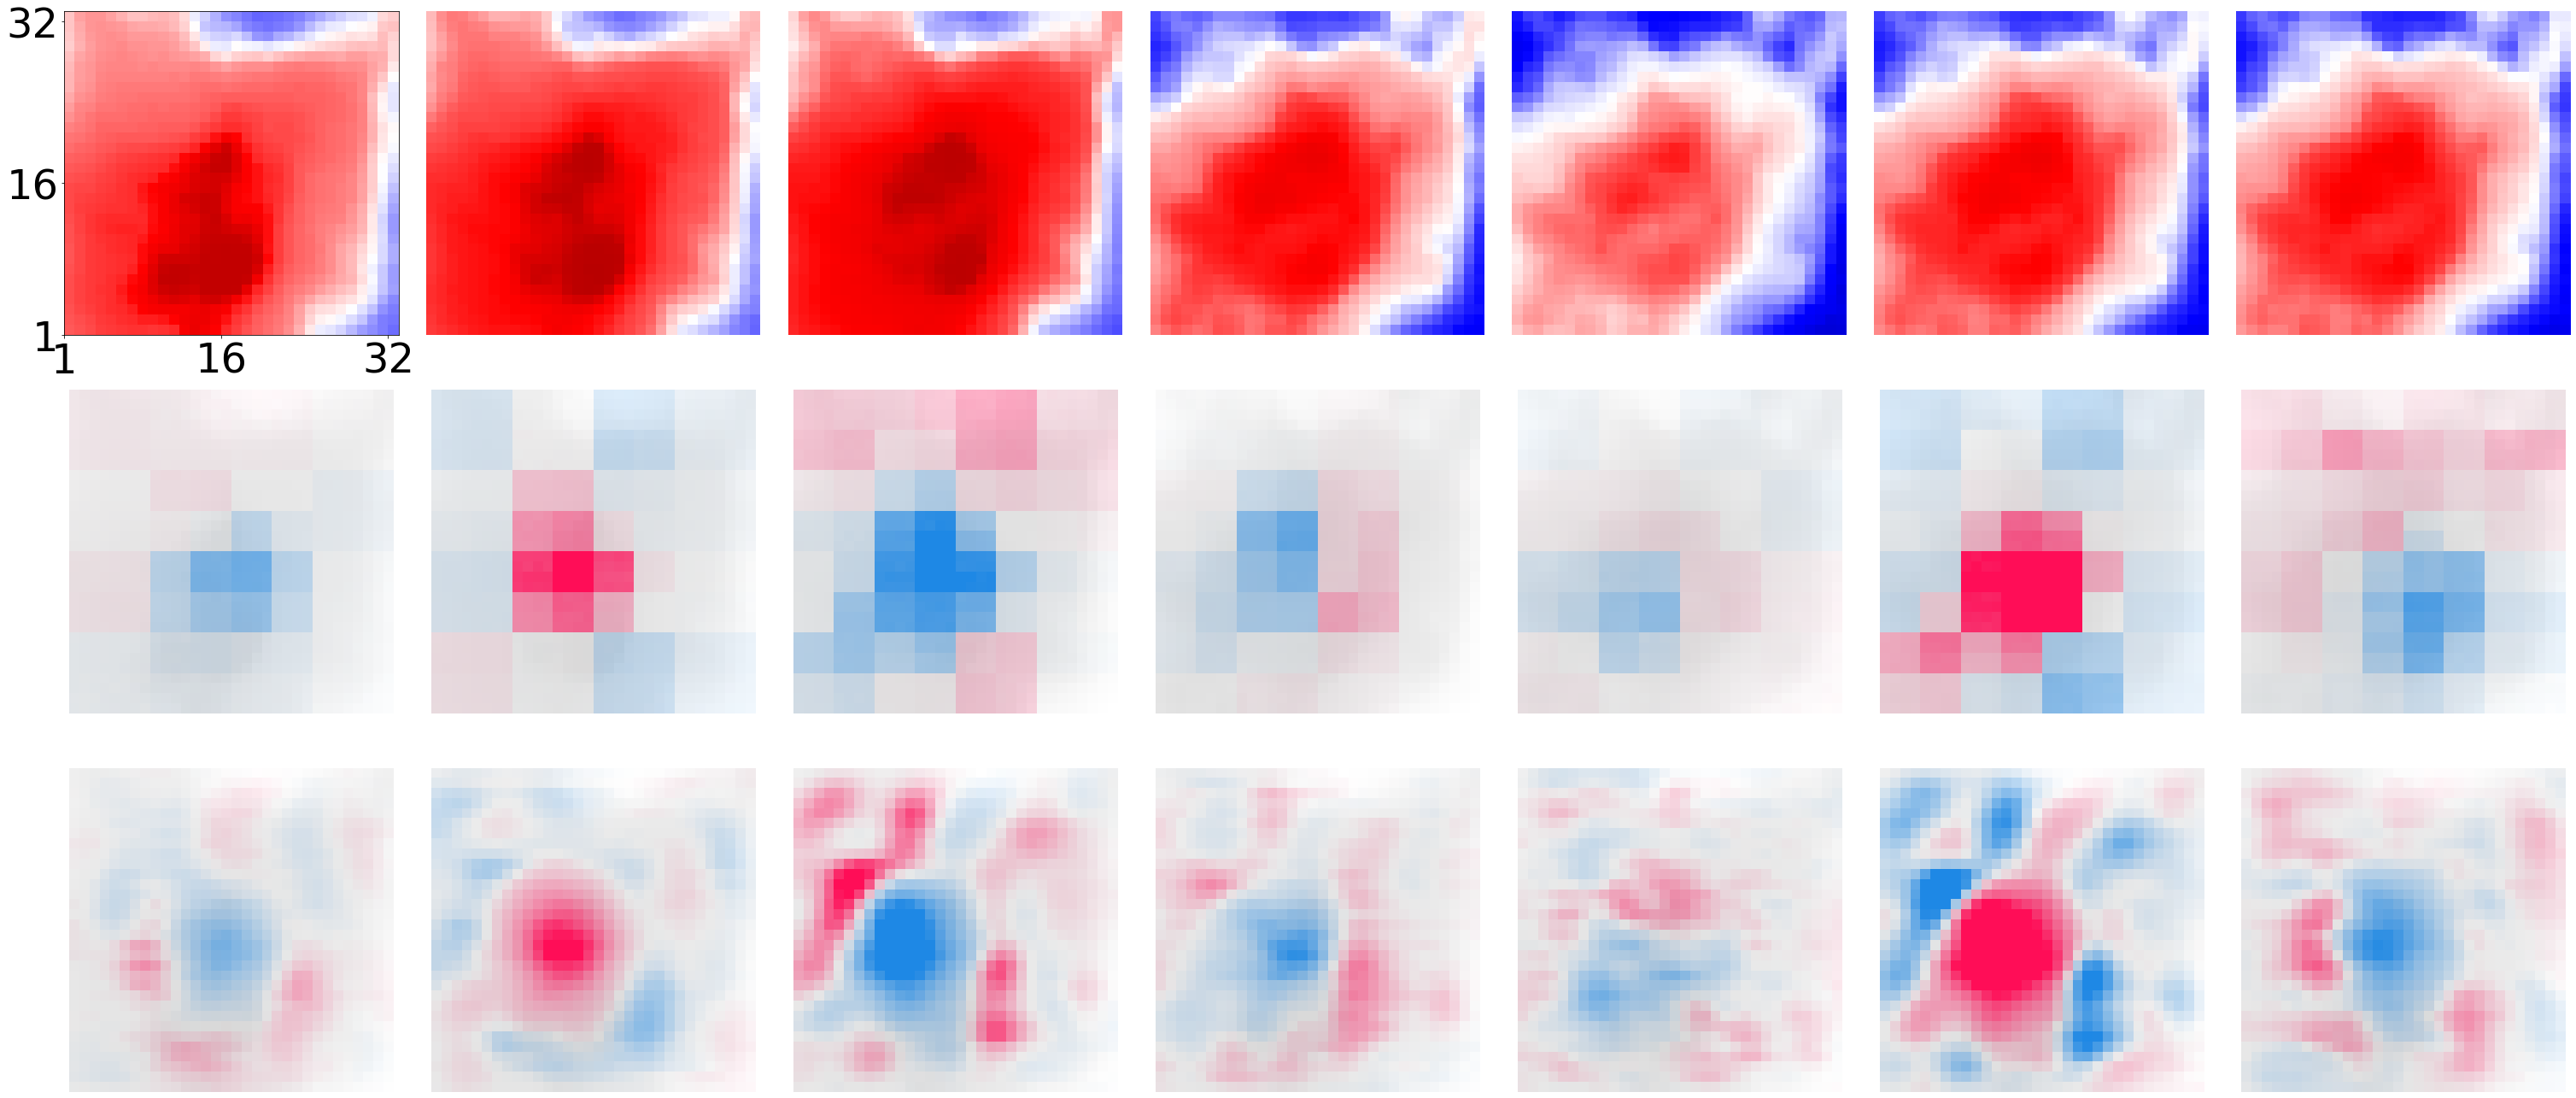

In [160]:
import copy 
shap_values_pmm = utils.run_pmm_many_variables(shap_values.values)
plot_storm_xai(pmm_worst_miss_matrix_denorm,shap_values_pmm[:,:,:,0], input_times_grad_matrix)
plt.savefig('plots/Worst_MS_examples.png')
#plot_storm_xai_batch(np.expand_dims(pmm_best_correct_null_matrix_denorm, axis=0), 
#                      np.expand_dims(shap_values_pmm, axis=0))

In [ ]:
import tensorflow._api.v2.compat.v1 as tf
tf.disable_v2_behavior()
tf.compat.v1.disable_eager_execution()

In [ ]:
#tf.compat.v1.enable_eager_execution()
#tf.compat.v1.experimental.output_all_intermediates(True)
#tf.config.run_functions_eagerly(True)
a=my_model.get_layer(name=my_model.layers[-1].name).output[..., 0] #.output[..., 1]

In [153]:
best_hits_matrix_norm.shape

(100, 32, 32, 7)

In [ ]:
import tensorflow as tf
tf.GradientTape

In [ ]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
tf.compat.v1.experimental.output_all_intermediates(True)

In [ ]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()


In [ ]:
!pip install h5py==2.10.0 --user yy

In [ ]:
print(1.dtype)

In [ ]:
import tensorflow as tf
#tf.compat.v1.disable_eager_execution()
tf.compat.v1.experimental.output_all_intermediates(True)

In [ ]:
import scipy.io as scio
scio.savemat('temp.mat',{'best_hits_matrix_norm':best_hits_matrix_norm, 'pmm_best_hits_matrix_denorm':pmm_best_hits_matrix_denorm})

In [ ]:
import scipy.io as scio
test=scio.loadmat('test.mat')
loss_tensor=test['loss_tensor']
input_tensors=test['input_tensors']


In [ ]:
print(input_tensors)

In [ ]:
#config = tf.compat.v1.ConfigProto
#import keras
#session = keras.backend.get_session()
#init = tf.global_variables_initializer()
#session.run(init)
#my_model = utils.read_dense_net("goes16ci_model_cpu_lead10_allIR.h5")
#my_model.summary()
#import tensorflow._api.v2.compat.v1 as tf
#tf.compat.v1.disable_eager_execution()
#tf.disable_v2_behavior()
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
tf.compat.v1.experimental.output_all_intermediates(True)
import scipy.io as scio
temp=scio.loadmat('temp.mat')
best_hits_matrix_norm=temp['best_hits_matrix_norm']
pmm_best_hits_matrix_denorm=temp['pmm_best_hits_matrix_denorm']
input_times_grad(best_hits_matrix_norm[:,:,:,:], pmm_best_hits_matrix_denorm)

In [ ]:
print(my_model.input)

In [ ]:
tensor_train_images = tf.convert_to_tensor(train_images, dtype=tf.float32)
with tf.GradientTape() as tape:
    tape.watch(tensor_train_images)
    model.evaluate(x=tensor_train_images,y=train_labels, steps=10)
print(tape.gradient(model.total_loss,tensor_train_images))

In [ ]:
import tensorflow.python.keras.backend as K
loss=tf.convert_to_tensor([1], dtype=tf.float32)
var=tf.convert_to_tensor([2], dtype=tf.float32)
with tf.GradientTape() as tape:
    a=1
a=tape.gradient(loss, var)

In [ ]:
print(loss)

In [ ]:
best_hits_matrix_norm[0].shape

In [ ]:
with tf.GradientTape() as tape:
         print('ok')

In [ ]:
pmm_best_hits_matrix_denorm.shape

In [ ]:
!pip install tensorflow==2.4.0 --user

In [ ]:
# Example regressed metrics
#cm = POD_score(test_label, binary_preds)
print('RMSE: {}'.format(np.round(root_mean_squared_error(test_label, preds),3)))
print('R squared: {}'.format(np.round(r2_corr(test_label, preds),3)))
print('Hellenger Distance: {}'.format(np.round(hellinger_distance(test_label, preds),3)))
POD, POFD, FAR, SR, CSI = scores(test_label, binary_preds)
print('POD: {}, POFD: {}, FAR: {}, SR: {}, CSI:{}'.format(POD, POFD, FAR, SR, CSI))
# Example classified metrics
print('Heidke Skill Score: {}'.format(np.round(heidke_skill_score(test_label, binary_preds),3)))
print('Pierce Skill Score: {}'.format(np.round(peirce_skill_score(test_label, binary_preds),3)))
print('Brier Score: {}'.format(np.round(brier_score(test_label, binary_preds),3)))
print('Brier Skill Score: {}'.format(np.round(brier_skill_score(test_label, binary_preds),3)))
print('Accuracy score: {}'.format(np.round(accuracy_score(test_label, binary_preds),3)))
print('AUC: {}'.format(np.round(auc_score(test_label, preds),3)))

In [ ]:
ch = np.arange(8,15)
print(ch)
import shap
import numpy as np

# select a set of background examples to take an expectation over
background = x_train[np.random.choice(x_train.shape[0], 100, replace=False)]

# explain predictions of the model on three images
e = shap.DeepExplainer(model, background)
# ...or pass tensors directly
# e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)
shap_values = e.shap_values(x_test[1:5])

In [ ]:
print(np.shape(test_data_scaled))

In [ ]:
import shap

# since we have two inputs we pass a list of inputs to the explainer
explainer = shap.GradientExplainer(my_model, [test_data_scaled, test_data_scaled])

# we explain the model's predictions on the first three samples of the test set
shap_values = explainer.shap_values([test_data_scaled[3,:,:,:]])
# plot the feature attributions
#shap.image_plot(shap_values, -test_data_scaled[100:105,:,:,:])

In [ ]:
!pip install tf-explain --user

In [ ]:
import shap
shap_values = shap.DeepExplainer(my_model).shap_values(test_data_scaled)
shap.summary_plot(shap_values, test_data_scaled, plot_type="bar")

In [ ]:
!pip install tensorflow==2.6.0 --user

In [ ]:
from tf_explain.callbacks.activations_visualization import ActivationsVisualizationCallback
callbacks = [
    ActivationsVisualizationCallback(
        validation_data=(test_data_scaled, test_label),
        layers_name=["activation_1"],
        output_dir='.',
    ),
]

my_model.fit(test_data_scaled, test_label, batch_size=1024, epochs=2, callbacks=callbacks)


In [ ]:
def plot_storm_array(predictor_matrix, labels, contour=False):
    """Plots each channel of a storm-centered raster loaded from NetCDF file.
    M = number of rows in each storm-centered grid
    N = number of columns in each storm-centered grid
    C = number of channels (predictor variables)
    
    :param predictor_matrix: M-by-N-by-C numpy array of predictor values.
    :param labels: C-length list of feature names to label each output. 
  """

    fig, ax = plt.subplots(1, len(labels), figsize=(15, 3))
    for i in range(len(labels)):

        # Contour plot
        if contour:
          a=ax[i].contourf(predictor_matrix[:,:,i])
          if i == 0:
            b=a
        # Image plot
        else:
          ax[i].imshow(predictor_matrix[:,:,i])
          ax[i].invert_yaxis()

        ax[i].set_title(labels[i])
        ax[i].axis('off')
    fig.colorbar(a, orientation='vertical')
print("Sample storm image:")
feature_names=['CH8','CH9','CH10','CH11','CH12','CH13','CH14',]
print(test_label[10])
plot_storm_array(test_data_scaled[10,:,:,:], labels=feature_names, contour=True)

In [ ]:
if os.path.isdir('course_repository'):
    shutil.rmtree('course_repository')
!git clone https://github.com/thunderhoser/ai2es_xai_course course_repository

In [ ]:
!pip install dill --user

In [ ]:
sys.path.append('/storage/home/dxf424/work/script/course_repository/')
from ai2es_xai_course.plotting import image_plotting, feature_map_plotting
from ai2es_xai_course.utils import utils, image_utils, image_normalization, \
    image_thresholding, cnn, saliency

In [ ]:
import pythran
!cd course_repository; python setup.py install --user

In [ ]:
!pip install pythran --user

In [ ]:
print(image_utils.PREDICTOR_MATRIX_KEY)

In [ ]:
data = test_data_scaled
predictor_matrix_denorm = data[image_utils.PREDICTOR_MATRIX_KEY]
predictor_names = data[image_utils.PREDICTOR_NAMES_KEY]
predictor_matrix_norm = image_normalization.normalize_data(
    predictor_matrix=copy.deepcopy(predictor_matrix_denorm),
    predictor_names=predictor_names, normalization_dict=image_normalization_dict
)

# Predict the first 5
preds = my_model.predict(predictor_matrix_norm[0][0:5,:])
print(preds)

In [ ]:
from tf_explain.core.grad_cam import GradCAM
explainer = GradCAM()
grid = explainer.explain((test_data_scaled[1:3,:,:,:],None), my_model, class_index=1)  # 281 is the tabby cat index in ImageNet

explainer.save(grid, ".", "grad_cam.png")

In [ ]:
import xgboost
import shap

# train an XGBoost model
X, y = shap.datasets.boston()
model = xgboost.XGBRegressor().fit(X, y)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer(X)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

In [ ]:
test_data_scaled[1:5].shape

In [ ]:
import shap
import numpy as np

# select a set of background examples to take an expectation over
background = test_data_scaled[np.random.choice(test_data_scaled.shape[0], 100, replace=False)]

# explain predictions of the model on four images
e = shap.DeepExplainer(my_model, background)
# ...or pass tensors directly
# e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)
shap_values = e.shap_values(test_data_scaled[1:5])

# plot the feature attributions
shap.image_plot(shap_values, -test_data_scaled[1:5])

In [ ]:
!pip install xgboost --user

In [ ]:
explainer = GradCAM()
grid = explainer.explain(data, model, class_index=281)  # 281 is the tabby cat index in ImageNet

explainer.save(grid, ".", "grad_cam.png")

In [ ]:
from tf_explain.callbacks.vanilla_gradients import VanillaGradientsCallback

model = [...]

callbacks = [
    VanillaGradientsCallback(
        validation_data=(test_data_scaled, test_label),
        class_index=0,
        output_dir='.',
    ),
]

my_model.fit(test_data_scaled, test_label, batch_size=1024, epochs=2, callbacks=callbacks)

In [ ]:
GOES-only(lead_time=10):POD: 0.8597816960537363, POFD: 0.587152516904583, FAR: 0.43284408751038495, SR: 0.567155912489615, CSI:0.5191381495564005

In [122]:
  print(np.shape(shap_values_pmm))
  abs_vals = np.abs(shap_values.sum(-1))
  max_val = np.nanpercentile(abs_vals, 99.9)

(32, 32, 7, 1)


In [159]:
import matplotlib

def input_times_grad(matrix_norm, pmm_matrix_denorm ):
  saliency_matrix = utils.get_saliency_one_neuron(
      model_object=my_model,
      predictor_matrix=matrix_norm,
      layer_name=my_model.layers[-1].name,
      neuron_indices=np.array([0], dtype=int),
      ideal_activation=1.
  )
  input_times_grad_matrix = (saliency_matrix * matrix_norm)

  input_times_grad_matrix = utils.run_pmm_many_variables(
      field_matrix=input_times_grad_matrix
  )
  input_times_grad_matrix = saliency.smooth_saliency_maps(
      saliency_matrices=[input_times_grad_matrix],
      smoothing_radius_grid_cells=1
  )[0]
  print(np.shape(pmm_matrix_denorm))
  print(np.shape(input_times_grad_matrix))
        
  #plot_storm_xai(pmm_matrix_denorm, input_times_grad_matrix)
  return input_times_grad_matrix

def plot_storm_xai(values, shap_values, input_times_grad_matrix):
  '''
    values: M-by-N-by-4
    shap_values: M-by-N-by-4
  '''

  from shap.plots import colors
  import matplotlib

  THIS_COLOUR_LIST = [
    np.array([4, 233, 231]), np.array([1, 159, 244]),
    np.array([3, 0, 244]),   np.array([2, 253, 2]),
    np.array([1, 197, 1]),   np.array([0, 142, 0]),
    np.array([253, 248, 2]), np.array([229, 188, 0]),
    np.array([253, 149, 0]), np.array([253, 0, 0]),
    np.array([212, 0, 0]),   np.array([188, 0, 0]),
    np.array([248, 0, 253]), np.array([152, 84, 198])
  ]
  for p in range(len(THIS_COLOUR_LIST)):
    THIS_COLOUR_LIST[p] = THIS_COLOUR_LIST[p].astype(float) / 255

  REFL_COLOUR_MAP_OBJECT = matplotlib.colors.ListedColormap(THIS_COLOUR_LIST)
  REFL_COLOUR_MAP_OBJECT.set_under(np.ones(3))
  THESE_COLOUR_BOUNDS = np.array([
      0.1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70
  ])
  REFL_COLOUR_NORM_OBJECT = matplotlib.colors.BoundaryNorm(
      THESE_COLOUR_BOUNDS, REFL_COLOUR_MAP_OBJECT.N
  )

  fig, ax = plt.subplots(3, 7, figsize=(42, 18))#56, 18)

  values = copy.deepcopy(values)
  values = np.squeeze(values)
  shap_values = copy.deepcopy(shap_values)
  # shap_values = np.abs(shap_values)
  shap_values = np.squeeze(shap_values)

  abs_vals = np.abs(shap_values.sum(-1))
  max_val = np.nanpercentile(abs_vals, 99.9)
  print(max_val)
  input_times_grad_matrix = copy.deepcopy(input_times_grad_matrix)
  input_times_grad_matrix = np.squeeze(input_times_grad_matrix)
  abs_vals_gi = np.abs(input_times_grad_matrix.sum(-1))
  max_val_gi = np.nanpercentile(abs_vals_gi, 99.9)
  print(max_val_gi)
    
  # Reflectivity
  #ax[0][0].set_title("CH8 BT")
  im = ax[0][0].pcolormesh((1-values[:,:,0]), 
                      cmap='seismic',
                      norm=None,
                      vmin=0,
                      vmax=1,
                      shading="flat", edgecolors='None')
  #cax = divider.append_axes('right', size='5%', pad=0.05)
  #im = ax.imshow(data, cmap='bone')
  #fig.colorbar(im, ax=ax[0][0])
  #ax[0][0].axis('off')
  ax[0][0].set_xticks((0, 15, 31))
  ax[0][0].set_xticklabels(('1', '16', '32'), fontsize=48)
  ax[0][0].set_yticks((0, 15, 31))
  ax[0][0].set_yticklabels(('1', '16', '32'), fontsize=48)
#  ax[0][0].set_xticks([0,16,31])
  ax[1][0].imshow(values[:,:,0], cmap="gray", alpha=0.15)
  ax[1][0].imshow(shap_values[:,:,0], cmap=colors.red_transparent_blue, vmin=-max_val, vmax=max_val)
  ax[1][0].invert_yaxis()
  ax[1][0].axis('off')
  ax[2][0].imshow(values[:,:,0], cmap="gray", alpha=0.15)
  ax[2][0].imshow(input_times_grad_matrix[:,:,0], cmap=colors.red_transparent_blue, vmin=-max_val_gi, vmax=max_val_gi)  
  ax[2][0].invert_yaxis()
  ax[2][0].axis('off')

  # Temperature
  #ax[0][1].set_title("CH9 BT")
  im = ax[0][1].pcolormesh((1-values[:,:,1]), 
                      cmap='seismic',
                      norm=None,
                      vmin=0,
                      vmax=1,
                      shading="flat", edgecolors='None') 
  ax[0][1].set_xticks((0, 15, 31))
  ax[0][1].set_xticklabels(('1', '16', '32'), fontsize=48)
  ax[0][1].set_yticks((0, 15, 31))
  ax[0][1].set_yticklabels(('1', '16', '32'), fontsize=48)
  ax[0][1].axis('off')
  ax[1][1].imshow(values[:,:,1], cmap="gray", alpha=0.15)
  ax[1][1].imshow(shap_values[:,:,1], cmap=colors.red_transparent_blue, vmin=-max_val, vmax=max_val)
  ax[1][1].invert_yaxis()
  ax[1][1].axis('off')
  ax[2][1].imshow(values[:,:,0], cmap="gray", alpha=0.15)
  ax[2][1].imshow(input_times_grad_matrix[:,:,1], cmap=colors.red_transparent_blue, vmin=-max_val_gi, vmax=max_val_gi) 
  ax[2][1].invert_yaxis()
  ax[2][1].axis('off')

  # Wind barbs
  #image_plotting.plot_wind_2d(values[:,:,2], values[:,:,3], ax[0][1])

  # Wind - u
  #ax[0][2].set_title("CH10 BT")
  im = ax[0][2].pcolormesh((1-values[:,:,2]), 
                      cmap='seismic',
                      norm=None,
                      vmin=0,
                      vmax=1,
                      shading="flat", edgecolors='None')  
  ax[0][2].set_xticks((0, 15, 31))
  ax[0][2].set_xticklabels(('1', '16', '32'), fontsize=48)
  ax[0][2].set_yticks((0, 15, 31))
  ax[0][2].set_yticklabels(('1', '16', '32'), fontsize=48)
  ax[0][2].axis('off')
  ax[1][2].imshow(values[:,:,2], cmap="gray", alpha=0.15)
  ax[1][2].imshow(shap_values[:,:,2], cmap=colors.red_transparent_blue, vmin=-max_val, vmax=max_val)
  ax[1][2].invert_yaxis()
  ax[1][2].axis('off')
  ax[2][2].imshow(values[:,:,0], cmap="gray", alpha=0.15)
  ax[2][2].imshow(input_times_grad_matrix[:,:,2], cmap=colors.red_transparent_blue, vmin=-max_val_gi, vmax=max_val_gi)   
  ax[2][2].invert_yaxis()
  ax[2][2].axis('off')

  # Wind - v
  #ax[0][3].set_title("CH11 BT")
  im = ax[0][3].pcolormesh((1-values[:,:,3]), 
                      cmap='seismic',
                      norm=None,
                      vmin=0,
                      vmax=1,
                      shading="flat", edgecolors='None')  
  ax[0][3].set_xticks((0, 15, 31))
  ax[0][3].set_xticklabels(('1', '16', '32'), fontsize=48)
  ax[0][3].set_yticks((0, 15, 31))
  ax[0][3].set_yticklabels(('1', '16', '32'), fontsize=48)
  ax[0][3].axis('off')
  ax[1][3].imshow(values[:,:,3], cmap="gray", alpha=0.15)
  ax[1][3].imshow(shap_values[:,:,3], cmap=colors.red_transparent_blue, vmin=-max_val, vmax=max_val)
  ax[1][3].invert_yaxis()
  ax[1][3].axis('off')
  ax[2][3].imshow(values[:,:,0], cmap="gray", alpha=0.15)
  ax[2][3].imshow(input_times_grad_matrix[:,:,3], cmap=colors.red_transparent_blue, vmin=-max_val_gi, vmax=max_val_gi)   
  ax[2][3].invert_yaxis()
  ax[2][3].axis('off')

  #ax[0][4].set_title("CH12 BT")
  im = ax[0][4].pcolormesh((1-values[:,:,4]),
                      cmap='seismic',
                      norm=None,
                      vmin=0,
                      vmax=1,
                      shading="flat", edgecolors='None')  
  ax[0][4].set_xticks((0, 15, 31))
  ax[0][4].set_xticklabels(('1', '16', '32'), fontsize=48)
  ax[0][4].set_yticks((0, 15, 31))
  ax[0][4].set_yticklabels(('1', '16', '32'), fontsize=48)
  ax[0][4].axis('off')
  ax[1][4].imshow(values[:,:,4], cmap="gray", alpha=0.15)
  ax[1][4].imshow(shap_values[:,:,4], cmap=colors.red_transparent_blue, vmin=-max_val, vmax=max_val)
  ax[1][4].invert_yaxis()
  ax[1][4].axis('off')
  ax[2][4].imshow(values[:,:,0], cmap="gray", alpha=0.15)
  ax[2][4].imshow(input_times_grad_matrix[:,:,4], cmap=colors.red_transparent_blue, vmin=-max_val_gi, vmax=max_val_gi)   
  ax[2][4].invert_yaxis()
  ax[2][4].axis('off')

  #ax[0][5].set_title("CH13 BT")
  im = ax[0][5].pcolormesh((1-values[:,:,5]), 
                      cmap='seismic',
                      norm=None,
                      vmin=0,
                      vmax=1,
                      shading="flat", edgecolors='None')  
  ax[0][5].set_xticks((0, 15, 31))
  ax[0][5].set_xticklabels(('1', '16', '32'), fontsize=48)
  ax[0][5].set_yticks((0, 15, 31))
  ax[0][5].set_yticklabels(('1', '16', '32'), fontsize=48)
  ax[0][5].axis('off')
  ax[1][5].imshow(values[:,:,5], cmap="gray", alpha=0.15)
  ax[1][5].imshow(shap_values[:,:,5], cmap=colors.red_transparent_blue, vmin=-max_val, vmax=max_val)
  ax[1][5].invert_yaxis()
  ax[1][5].axis('off')
  ax[2][5].imshow(values[:,:,0], cmap="gray", alpha=0.15)
  ax[2][5].imshow(input_times_grad_matrix[:,:,5], cmap=colors.red_transparent_blue, vmin=-max_val_gi, vmax=max_val_gi)   
  ax[2][5].invert_yaxis()
  ax[2][5].axis('off')

  #ax[0][6].set_title("CH14 BT")
  im = ax[0][6].pcolormesh((1-values[:,:,6]),
                      cmap='seismic',
                      norm=None,
                      vmin=0,
                      vmax=1,
                      shading="flat", edgecolors='None')  
#  cbar = fig.colorbar(im, ax=ax[0][6])
  #cbar.ax.tick_params(labelsize=36)
  ax[0][6].set_xticks((0, 15, 31))
  ax[0][6].set_xticklabels(('1', '16', '32'), fontsize=48)
  ax[0][6].set_yticks((0, 15, 31))
  ax[0][6].set_yticklabels(('1', '16', '32'), fontsize=48)
  ax[0][6].axis('off')
  ax[1][6].imshow(values[:,:,6], cmap="gray", alpha=0.15)
  im = ax[1][6].imshow(shap_values[:,:,6], cmap=colors.red_transparent_blue, vmin=-max_val, vmax=max_val)
  ax[1][6].invert_yaxis()
  #cbar = fig.colorbar(im, ax=ax[1][6])
  #cbar.ax.tick_params(labelsize=36)
  ax[1][6].axis('off')
  ax[2][6].imshow(values[:,:,0], cmap="gray", alpha=0.15)
  im = ax[2][6].imshow(input_times_grad_matrix[:,:,6], cmap=colors.red_transparent_blue, vmin=-max_val_gi, vmax=max_val_gi) 
  #cbar = fig.colorbar(im, ax=ax[2][6])
  #cbar.ax.tick_params(labelsize=36)
  ax[2][6].invert_yaxis()
  ax[2][6].axis('off')

  plt.tight_layout()

def plot_storm_xai_batch(values, shap_values):
  n = values.shape[0]
  for i in range(n):
    v = values[i,:]
    s = shap_values[i]
    plot_storm_xai(v, s)

In [147]:
import matplotlib

def input_times_grad(matrix_norm, pmm_matrix_denorm ):
  print('ok')
  saliency_matrix = utils.get_saliency_one_neuron(
      model_object=my_model,
      predictor_matrix=matrix_norm,
      layer_name=my_model.layers[-1].name,
      neuron_indices=np.array([0], dtype=int),
      ideal_activation=1.
  )
  input_times_grad_matrix = (saliency_matrix * matrix_norm)

  input_times_grad_matrix = utils.run_pmm_many_variables(
      field_matrix=input_times_grad_matrix
  )
  input_times_grad_matrix = saliency.smooth_saliency_maps(
      saliency_matrices=[input_times_grad_matrix],
      smoothing_radius_grid_cells=1
  )[0]

  plot_storm_xai(pmm_matrix_denorm, input_times_grad_matrix)

def plot_storm_xai(values, shap_values, input_times_grad_matrix):
  '''
    values: M-by-N-by-4
    shap_values: M-by-N-by-4
  '''

  from shap.plots import colors
  import matplotlib

  THIS_COLOUR_LIST = [
    np.array([4, 233, 231]), np.array([1, 159, 244]),
    np.array([3, 0, 244]),   np.array([2, 253, 2]),
    np.array([1, 197, 1]),   np.array([0, 142, 0]),
    np.array([253, 248, 2]), np.array([229, 188, 0]),
    np.array([253, 149, 0]), np.array([253, 0, 0]),
    np.array([212, 0, 0]),   np.array([188, 0, 0]),
    np.array([248, 0, 253]), np.array([152, 84, 198])
  ]
  for p in range(len(THIS_COLOUR_LIST)):
    THIS_COLOUR_LIST[p] = THIS_COLOUR_LIST[p].astype(float) / 255

  REFL_COLOUR_MAP_OBJECT = matplotlib.colors.ListedColormap(THIS_COLOUR_LIST)
  REFL_COLOUR_MAP_OBJECT.set_under(np.ones(3))
  THESE_COLOUR_BOUNDS = np.array([
      0.1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70
  ])
  REFL_COLOUR_NORM_OBJECT = matplotlib.colors.BoundaryNorm(
      THESE_COLOUR_BOUNDS, REFL_COLOUR_MAP_OBJECT.N
  )

  fig, ax = plt.subplots(3, 7, figsize=(42, 18))#56, 18)

  values = copy.deepcopy(values)
  values = np.squeeze(values)
  shap_values = copy.deepcopy(shap_values)
  # shap_values = np.abs(shap_values)
  shap_values = np.squeeze(shap_values)

  abs_vals = np.abs(shap_values.sum(-1))
  max_val = np.nanpercentile(abs_vals, 99.9)
  
  input_times_grad_matrix = copy.deepcopy(input_times_grad_matrix)
  input_times_grad_matrix = np.squeeze(input_times_grad_matrix)
  abs_vals_gi = np.abs(input_times_grad_matrix.sum(-1))
  max_val_gi = np.nanpercentile(abs_vals_gi, 99.9)

  # Reflectivity
  #ax[0][0].set_title("CH8 BT")
  im = ax[0][0].pcolormesh((1-values[:,:,0])*df.loc[0,"range"]+df.loc[0,"min"], 
                      cmap='seismic',
                      norm=None,
                      vmin=df.loc[0,"min"],
                      vmax=df.loc[0,"max"],
                      shading="flat", edgecolors='None')
  cbar = fig.colorbar(im, ax=ax[0][0])
  cbar.ax.tick_params(labelsize=36)
  #cax = divider.append_axes('right', size='5%', pad=0.05)
  #im = ax.imshow(data, cmap='bone')
  #fig.colorbar(im, ax=ax[0][0])
  ax[0][0].axis('off')
  ax[1][0].imshow(values[:,:,0], cmap="gray", alpha=0.15)
  ax[1][0].imshow(shap_values[:,:,0], cmap=colors.red_transparent_blue, vmin=-max_val, vmax=max_val)
  ax[1][0].invert_yaxis()
  ax[1][0].axis('off')
  ax[2][0].imshow(values[:,:,0], cmap="gray", alpha=0.15)
  ax[2][0].imshow(input_times_grad_matrix[:,:,0], cmap=colors.red_transparent_blue, vmin=-max_val_gi, vmax=max_val_gi)  
  ax[2][0].invert_yaxis()
  ax[2][0].axis('off')

  # Temperature
  #ax[0][1].set_title("CH9 BT")
  im = ax[0][1].pcolormesh((1-values[:,:,1])*df.loc[1,"range"]+df.loc[1,"min"], 
                      cmap='seismic',
                      norm=None,
                      vmin=df.loc[1,"min"],
                      vmax=df.loc[1,"max"],
                      shading="flat", edgecolors='None') 
  cbar = fig.colorbar(im, ax=ax[0][1])
  cbar.ax.tick_params(labelsize=36)
  ax[0][1].axis('off')
  ax[1][1].imshow(values[:,:,1], cmap="gray", alpha=0.15)
  ax[1][1].imshow(shap_values[:,:,1], cmap=colors.red_transparent_blue, vmin=-max_val, vmax=max_val)
  ax[1][1].invert_yaxis()
  ax[1][1].axis('off')
  ax[2][1].imshow(values[:,:,0], cmap="gray", alpha=0.15)
  ax[2][1].imshow(input_times_grad_matrix[:,:,1], cmap=colors.red_transparent_blue, vmin=-max_val_gi, vmax=max_val_gi) 
  ax[2][1].invert_yaxis()
  ax[2][1].axis('off')

  # Wind barbs
  #image_plotting.plot_wind_2d(values[:,:,2], values[:,:,3], ax[0][1])

  # Wind - u
  #ax[0][2].set_title("CH10 BT")
  im = ax[0][2].pcolormesh((1-values[:,:,2])*df.loc[2,"range"]+df.loc[2,"min"], 
                      cmap='seismic',
                      norm=None,
                      vmin=df.loc[2,"min"],
                      vmax=df.loc[2,"max"],
                      shading="flat", edgecolors='None')  
  cbar = fig.colorbar(im, ax=ax[0][2])
  cbar.ax.tick_params(labelsize=36)
  ax[0][2].axis('off')
  ax[1][2].imshow(values[:,:,2], cmap="gray", alpha=0.15)
  ax[1][2].imshow(shap_values[:,:,2], cmap=colors.red_transparent_blue, vmin=-max_val, vmax=max_val)
  ax[1][2].invert_yaxis()
  ax[1][2].axis('off')
  ax[2][2].imshow(values[:,:,0], cmap="gray", alpha=0.15)
  ax[2][2].imshow(input_times_grad_matrix[:,:,2], cmap=colors.red_transparent_blue, vmin=-max_val_gi, vmax=max_val_gi)   
  ax[2][2].invert_yaxis()
  ax[2][2].axis('off')

  # Wind - v
  #ax[0][3].set_title("CH11 BT")
  im = ax[0][3].pcolormesh((1-values[:,:,3])*df.loc[3,"range"]+df.loc[3,"min"], 
                      cmap='seismic',
                      norm=None,
                      vmin=df.loc[3,"min"],
                      vmax=df.loc[3,"max"],
                      shading="flat", edgecolors='None')  
  cbar = fig.colorbar(im, ax=ax[0][3])
  cbar.ax.tick_params(labelsize=36)
  ax[0][3].axis('off')
  ax[1][3].imshow(values[:,:,3], cmap="gray", alpha=0.15)
  ax[1][3].imshow(shap_values[:,:,3], cmap=colors.red_transparent_blue, vmin=-max_val, vmax=max_val)
  ax[1][3].invert_yaxis()
  ax[1][3].axis('off')
  ax[2][3].imshow(values[:,:,0], cmap="gray", alpha=0.15)
  ax[2][3].imshow(input_times_grad_matrix[:,:,3], cmap=colors.red_transparent_blue, vmin=-max_val_gi, vmax=max_val_gi)   
  ax[2][3].invert_yaxis()
  ax[2][3].axis('off')

  #ax[0][4].set_title("CH12 BT")
  im = ax[0][4].pcolormesh((1-values[:,:,4])*df.loc[4,"range"]+df.loc[4,"min"],
                      cmap='seismic',
                      norm=None,
                      vmin=df.loc[4,"min"],
                      vmax=df.loc[4,"max"],
                      shading="flat", edgecolors='None')  
  cbar = fig.colorbar(im, ax=ax[0][4])
  cbar.ax.tick_params(labelsize=36)
  ax[0][4].axis('off')
  ax[1][4].imshow(values[:,:,4], cmap="gray", alpha=0.15)
  ax[1][4].imshow(shap_values[:,:,4], cmap=colors.red_transparent_blue, vmin=-max_val, vmax=max_val)
  ax[1][4].invert_yaxis()
  ax[1][4].axis('off')
  ax[2][4].imshow(values[:,:,0], cmap="gray", alpha=0.15)
  ax[2][4].imshow(input_times_grad_matrix[:,:,4], cmap=colors.red_transparent_blue, vmin=-max_val_gi, vmax=max_val_gi)   
  ax[2][4].invert_yaxis()
  ax[2][4].axis('off')

  #ax[0][5].set_title("CH13 BT")
  im = ax[0][5].pcolormesh((1-values[:,:,5])*df.loc[5,"range"]+df.loc[5,"min"], 
                      cmap='seismic',
                      norm=None,
                      vmin=df.loc[5,"min"],
                      vmax=df.loc[5,"max"],
                      shading="flat", edgecolors='None')  
  cbar = fig.colorbar(im, ax=ax[0][5])
  cbar.ax.tick_params(labelsize=36)
  ax[0][5].axis('off')
  ax[1][5].imshow(values[:,:,5], cmap="gray", alpha=0.15)
  ax[1][5].imshow(shap_values[:,:,5], cmap=colors.red_transparent_blue, vmin=-max_val, vmax=max_val)
  ax[1][5].invert_yaxis()
  ax[1][5].axis('off')
  ax[2][5].imshow(values[:,:,0], cmap="gray", alpha=0.15)
  ax[2][5].imshow(input_times_grad_matrix[:,:,5], cmap=colors.red_transparent_blue, vmin=-max_val_gi, vmax=max_val_gi)   
  ax[2][5].invert_yaxis()
  ax[2][5].axis('off')

  #ax[0][6].set_title("CH14 BT")
  im = ax[0][6].pcolormesh((1-values[:,:,6])*df.loc[6,"range"]+df.loc[6,"min"],
                      cmap='seismic',
                      norm=None,
                      vmin=df.loc[6,"min"],
                      vmax=df.loc[6,"max"],
                      shading="flat", edgecolors='None')  
  cbar = fig.colorbar(im, ax=ax[0][6])
  cbar.ax.tick_params(labelsize=36)
  ax[0][6].axis('off')
  ax[1][6].imshow(values[:,:,6], cmap="gray", alpha=0.15)
  im = ax[1][6].imshow(shap_values[:,:,6], cmap=colors.red_transparent_blue, vmin=-max_val, vmax=max_val)
  ax[1][6].invert_yaxis()
  #cbar = fig.colorbar(im, ax=ax[1][6])
  #cbar.ax.tick_params(labelsize=36)
  ax[1][6].axis('off')
  ax[2][6].imshow(values[:,:,0], cmap="gray", alpha=0.15)
  ax[2][6].imshow(input_times_grad_matrix[:,:,6], cmap=colors.red_transparent_blue, vmin=-max_val_gi, vmax=max_val_gi) 
  #cbar = fig.colorbar(im, ax=ax[2][6])
  #cbar.ax.tick_params(labelsize=36)
  ax[2][6].invert_yaxis()
  ax[2][6].axis('off')

  plt.tight_layout()

def plot_storm_xai_batch(values, shap_values):
  n = values.shape[0]
  for i in range(n):
    v = values[i,:]
    s = shap_values[i]
    plot_storm_xai(v, s)

In [6]:
#def main():
seed_everything(4835)
My_dir = '/glade/scratch/fanda/files/GOESR_HRRR_PC/'#GOESR_HRRR_PC/'
test_dir = My_dir+'longer_test/'
onlyfiles = [f for f in listdir(My_dir) if isfile(join(My_dir, f))]
testfiles = [f for f in listdir(test_dir) if isfile(join(test_dir, f))]

config_file = open('/glade/work/fanda/optimization/benchmark_config_default.yml',"r")
config = yaml.load(config_file, Loader=yaml.Loader)
print(config["dtype"])
# load data serial
logging.info("Split training and validation data")
train = []
label = []
test = []
test_label = []
lat_1 = []
lon_1 = []
date_1 = []
Type_1 = []
benchmark_data = dict()
# load data serial
benchmark_data["config"] = config
for file in onlyfiles:
    processed_file = nc.Dataset(os.path.join(My_dir,file))
    #if np.sum(np.isnan(processed_file.variables['predictor']))==0:
    train.append(processed_file.variables['predictor'])
    label.append(processed_file.variables['label'])
all_images = np.concatenate(train).astype(config["dtype"])
all_labels = np.concatenate(label).astype(config["dtype"])
all_images = np.moveaxis(all_images,1,-1)
delete_row =[]
for i in range(len(all_labels)):
    if np.sum(np.isnan(all_images[i,:,:,:]))>0:
        delete_row.append(i)
all_images = np.delete(all_images, delete_row, 0)
all_labels = np.delete(all_labels, delete_row, 0)
delete_row =[]
for file in testfiles:
    processed_file = nc.Dataset(os.path.join(test_dir,file))
    #if np.sum(np.isnan(processed_file.variables['predictor']))==0:
    test.append(processed_file.variables['predictor'])
    test_label.append(processed_file.variables['label'])
    lat_1.append(processed_file.variables['lat_0'])
    lon_1.append(processed_file.variables['lon_0'])
    date_1.append(processed_file.variables['date'])
    Type_1.append(processed_file.variables['Type'])
test_images = np.concatenate(test).astype(config["dtype"])
test_labels = np.concatenate(test_label).astype(config["dtype"])
lat_0 = np.concatenate(lat_1).astype(config["dtype"])
lon_0 = np.concatenate(lon_1).astype(config["dtype"])
date_0 = np.concatenate(date_1).astype(config["dtype"])
Type_0 = np.concatenate(Type_1).astype(config["dtype"])
test_images = np.moveaxis(test_images,1,-1)
for i in range(len(test_labels)):
    if np.sum(np.isnan(test_images[i,:,:,:]))>0:
        delete_row.append(i)
test_images = np.delete(test_images, delete_row, 0)
test_labels = np.delete(test_labels, delete_row, 0)
lat_0= np.delete(lat_0, delete_row, 0)
lon_0= np.delete(lon_0, delete_row, 0)
date_0= np.delete(date_0, delete_row, 0)
Type_0= np.delete(Type_0, delete_row, 0)
print(np.shape(all_images))
print(np.shape(test_images))
num = np.shape(all_images)[0]
shuffler = np.random.permutation(len(all_images))
images_shuffled = all_images[shuffler]
labels_shuffled = all_labels[shuffler]
shuffler2 = np.random.permutation(len(test_images))
test_images_shuffled = test_images[shuffler2]
test_labels_shuffled = test_labels[shuffler2]
lat_0 = lat_0[shuffler2]
lon_0 = lon_0[shuffler2]
date_0 = date_0[shuffler2]
Type_0 = Type_0[shuffler2]
#config_file = open('/glade/work/fanda/optimization/benchmark_config_default.yml',"r")
#config = yaml.load(config_file, Loader=yaml.Loader)
train_val_split = 40000#25000
num_ch = np.arange(7,14)#28,35)
train_data = images_shuffled[:train_val_split,:,:,num_ch].astype(config["dtype"])
train_label = labels_shuffled[:train_val_split].astype(config["dtype"])
val_data = images_shuffled[train_val_split:,:,:,num_ch].astype(config["dtype"])
val_label = labels_shuffled[train_val_split:].astype(config["dtype"])
test_data = test_images_shuffled[:,:,:,:].astype(config["dtype"])
#test_data = test_images_shuffled[:,:,:,num_ch].astype(config["dtype"])
test_label = test_labels_shuffled[:].astype(config["dtype"])
#print("ALL DATA=", all_data)

#rotate 90/180/270/360 degree
'''
for i in range(len(train_data)):
    train_data[i,:,:,:]=tf.image.rot90(train_data[i,:,:,:], k=np.random.randint(0,4))
for i in range(len(test_data)):
    test_data[i,:,:,:]=tf.image.rot90(test_data[i,:,:,:], k=np.random.randint(0,4))
'''
scaler = MinMaxScaler2D()
train_data_scaled = 1.0 - scaler.fit_transform(train_data) #1.0 - train_data#1.0 - scaler.fit_transform(train_data)
val_data_scaled = 1.0 - scaler.transform(val_data) #1.0 -val_data#1.0 - scaler.transform(val_data)
test_data_scaled = 1.0 - scaler.transform(test_data[:,:,:,num_ch])
print(np.shape(train_data))
print(np.shape(test_data))

float32
(56647, 32, 32, 57)
(6130, 32, 32, 141)
(40000, 32, 32, 7)
(6130, 32, 32, 141)


In [4]:
print(np.shape(test_data))

(13747, 32, 32, 57)


In [7]:
test_data_scaled=test_data
for i in range(19):
    test_data_scaled[:,:,:,np.arange(i*7,(i+1)*7)]=1.0 - scaler.transform(test_data[:,:,:,np.arange(i*7,(i+1)*7)])

In [205]:
shuffler2

array([ 8417,  7913, 11449, ...,  1679,  7752, 11533])

In [105]:
scaler.scale_values.loc[0,"min"]

min         max       range
0  196.240356  256.515930   60.275574
1  192.958588  266.010223   73.051636
2  193.739899  273.079498   79.339600
3  191.657227  319.518921  127.861694
4  214.358093  281.906372   67.548279
5  191.948639  325.856934  133.908295
6  191.283997  326.021210  134.737213

In [99]:
scaler.scale_values.to_pickle("minmax_value.h5")

In [101]:
df = pd.read_pickle("minmax_value.h5")

In [104]:
df.loc[0,"min"]

196.2403564453125

In [166]:
binary_preds
preds
test_labels

(3781,)

In [176]:
import glob
from cartopy import crs as ccrs
from cartopy import feature as cfeature
latN = 49.0
latS = 33.0
lonW = -90.0
lonE = -105.0
cLat = (latN + latS)/2
cLon = (lonW + lonE )/2
colors = {0:'dodgerblue', 1:'red'}#, 2:'red', 3:'black'}

In [184]:
preds

array([0.9867133 , 0.66981226, 0.83119214, ..., 0.76482046, 0.8129695 ,
       0.81609416], dtype=float32)

Text(0.5, 1.0, 'CI/no-CI observations, Great Plain 6/27-6/30/2020')

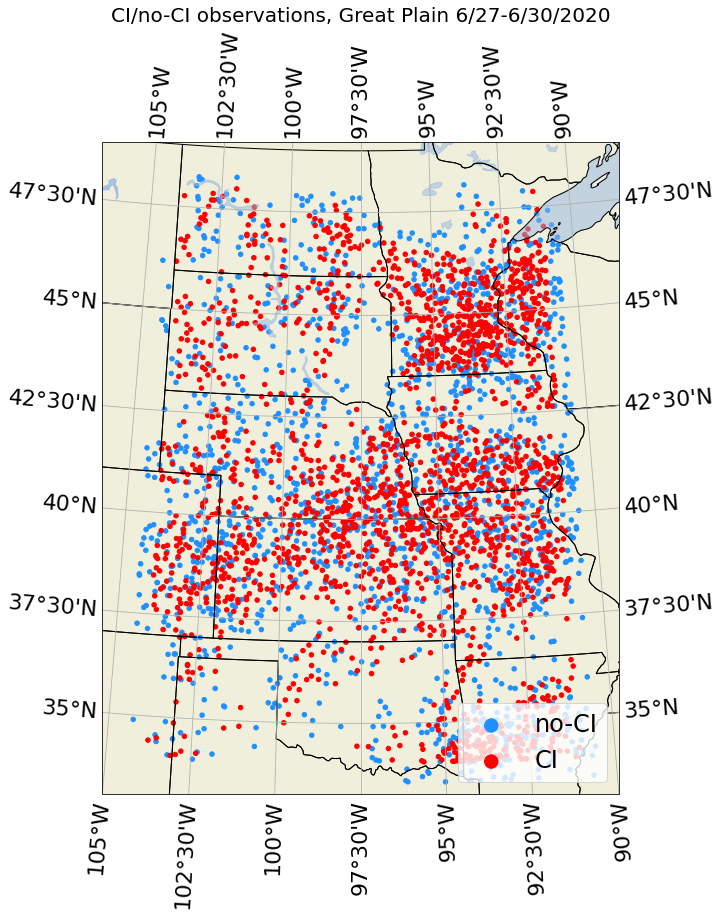

In [182]:
proj = ccrs.LambertConformal(central_longitude=cLon, central_latitude=cLat)
res = '50m'  # Coarsest and quickest to display; other options are '10m' (slowest) and '50m'.
fig = plt.figure(figsize=(18, 12))
ax = plt.subplot(1, 1, 1, projection=proj)
ax.set_extent([lonW, lonE, latS, latN])
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax.add_feature(cfeature.LAND.with_scale(res))
ax.add_feature(cfeature.OCEAN.with_scale(res))
ax.add_feature(cfeature.COASTLINE.with_scale(res))
ax.add_feature(cfeature.LAKES.with_scale(res), alpha=0.5)
ax.add_feature(cfeature.STATES.with_scale(res))

for i in range(2):
    color=pd.DataFrame()
    color['color'] = test_label[test_label==i]
    ax.scatter(lon_0[test_label == i]-360,
               lat_0[test_label == i],
               c=color['color'].map(colors),
               s=20, transform=ccrs.PlateCarree())

plt.legend(colors.values(), labels=["no-CI", "CI"], fontsize=24, markerscale=3, loc="lower right")
plt.title("CI/no-CI observations, Great Plain 6/27-6/30/2020", fontsize=20)

In [78]:
proj = ccrs.LambertConformal(central_longitude=cLon, central_latitude=cLat)
res = '50m'  # Coarsest and quickest to display; other options are '10m' (slowest) and '50m'.
fig = plt.figure(figsize=(18, 12))
ax = plt.subplot(1, 1, 1, projection=proj)
ax.set_extent([lonW, lonE, latS, latN])
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax.add_feature(cfeature.LAND.with_scale(res))
ax.add_feature(cfeature.OCEAN.with_scale(res))
ax.add_feature(cfeature.COASTLINE.with_scale(res))
ax.add_feature(cfeature.LAKES.with_scale(res), alpha=0.5)
ax.add_feature(cfeature.STATES.with_scale(res))
'''
for i in range(2):
    color=pd.DataFrame()
    color['color'] = test_label[test_label==i]
    ax.scatter(lon_0[test_label == i]-360,
               lat_0[test_label == i],
               c=color['color'].map(colors),
               s=20, transform=ccrs.PlateCarree())
'''
im = ax.scatter(lon_0-360, lat_0, c=preds, s=50, marker="s", cmap='Greens',transform=ccrs.PlateCarree())
plt.colorbar(im,ax=ax)
    
plt.legend(colors.values(), labels=["no-CI", "CI"], fontsize=24, markerscale=3, loc="lower right")
plt.title("CI/no-CI observations, Great Plain 6/27-6/30/2020", fontsize=20)

NameError: name 'ccrs' is not defined

In [65]:
import glob
from cartopy import crs as ccrs
from cartopy import feature as cfeature
latN = 36.0
latS = 33.0
lonW = -95.0
lonE = -98.0
cLat = (latN + latS)/2
cLon = (lonW + lonE )/2
colors = {0:'red', 1:'black'} #{0:'dodgerblue', 1:'red'}#, 2:'red', 3:'black'}

In [56]:
from datetime import datetime,timedelta
date_time=[]
for i in range(len(date_0)):
    date_time.append(datetime.fromtimestamp(date_0[i]))

In [57]:
date_start = datetime(2020, 7, 22, 3, 0)

date_end = datetime(2020, 7, 22, 4, 0)

index = []
for i in range(len(date_time)):
    if(date_time[i]>date_start and date_time[i]<date_end):
        index.append(i)

In [233]:
l

Text(0.5, 1.0, 'CI/no-CI observations, Great Plain 6/27-6/30/2020')

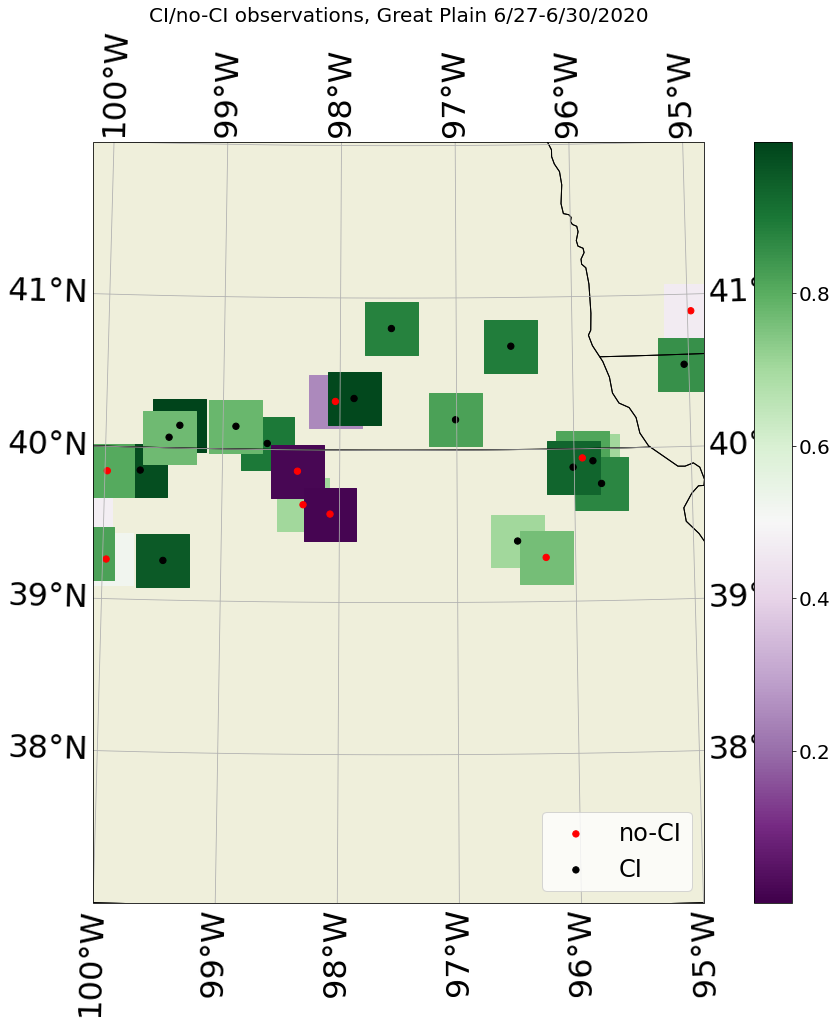

In [ ]:

%matplotlib inline
plt.rcParams['font.size'] = '32'
proj = ccrs.LambertConformal(central_longitude=cLon, central_latitude=cLat)
res = '50m'  # Coarsest and quickest to display; other options are '10m' (slowest) and '50m'.
fig = plt.figure(figsize=(18, 14))
ax = plt.subplot(1, 1, 1, projection=proj)
ax.set_extent([lonW, lonE, latS, latN])
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax.add_feature(cfeature.LAND.with_scale(res))
ax.add_feature(cfeature.OCEAN.with_scale(res))
ax.add_feature(cfeature.COASTLINE.with_scale(res))
ax.add_feature(cfeature.LAKES.with_scale(res), alpha=0.5)
ax.add_feature(cfeature.STATES.with_scale(res))

l = []
im = ax.scatter(lon_0[index]-360, lat_0[index], c=preds[index], s=2800, marker="s", cmap='PRGn',transform=ccrs.PlateCarree(),label='_nolegend_')
plt.colorbar(im,ax=ax)
for i in range(2):
    color=pd.DataFrame()
    selected_label=test_label[index]
    index_2 = selected_label==i
    color['color'] = selected_label[index_2]
    l.append(ax.scatter(lon_0[index][index_2]-360,
               lat_0[index][index_2],
               c=color['color'].map(colors),
               s=40, transform=ccrs.PlateCarree()))

plt.legend((l[0],l[1]),colors.values(), labels=["no-CI", "CI"], fontsize=24, markerscale=1, loc="lower right")
plt.title("CI/no-CI observations, Great Plain 6/27-6/30/2020", fontsize=20)

In [338]:
np.array((lon_0[index]-360, lat_0[index])).T.shape

(61, 2)

In [325]:
np.hstack(1,2)

TypeError: _vhstack_dispatcher() takes 1 positional argument but 2 were given

In [153]:
import glob
from cartopy import crs as ccrs
from cartopy import feature as cfeature
latN = 36.5
latS = 33.0
lonW = -95.0
lonE = -98.0
cLat = (latN + latS)/2
cLon = (lonW + lonE )/2
colors = {0:'red', 1:'blue'} 

In [120]:
color['color'].map(colors)

0    blue
1    blue
2    blue
3    blue
4     red
5    blue
6    blue
7     red
Name: color, dtype: object

In [133]:
selected_label==selected_preds 

masked_array(data=[False,  True,  True, False,  True,  True,  True,  True,
                   False,  True,  True, False,  True, False,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                   False,  True,  True,  True, False,  True,  True,  True,
                    True,  True,  True,  True,  True, False,  True],
             mask=False,
       fill_value=True)

In [134]:
selected_label[selected_label==selected_preds ]

masked_array(data=[1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 0.,
                   0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1.,
                   1., 1., 0.],
             mask=False,
       fill_value=1e+20,
            dtype=float32)

In [154]:
%matplotlib notebook
# Enable interactive plot
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter

plt.rcParams['font.size'] = '28'
proj = ccrs.LambertConformal(central_longitude=cLon, central_latitude=cLat)
res = '50m'  # Coarsest and quickest to display; other options are '10m' (slowest) and '50m'.
fig = plt.figure(figsize=(10, 15))
ax = plt.subplot(1, 1, 1, projection=proj)
ax.set_extent([lonW, lonE, latS, latN])
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.xlocator = mticker.FixedLocator([-98, -97, -96, -95])
gl.ylocator = mticker.FixedLocator([34, 35, 36])
ax.add_feature(cfeature.LAND.with_scale(res))
ax.add_feature(cfeature.OCEAN.with_scale(res))
ax.add_feature(cfeature.COASTLINE.with_scale(res))
ax.add_feature(cfeature.LAKES.with_scale(res), alpha=0.5)
ax.add_feature(cfeature.STATES.with_scale(res))
lines = []
a1 = ax.scatter(lon_0[index]-360, lat_0[index], c=-preds[index]*np.log(preds[index]), s=4500, marker="s", cmap='Greys',transform=ccrs.PlateCarree(),label='_nolegend_')
lines.append(a1)
#
for i in range(2):
    color=pd.DataFrame()
    selected_label=test_label[index]
    selected_preds=binary_preds[index]
    if i == 0:
        index_2 = selected_label==selected_preds 
        color['color'] = np.ones(np.sum(index_2))
    else:
        index_2 = selected_label==(1-selected_preds)
        color['color'] = np.zeros(np.sum(index_2))
    #color['color'] = selected_label[index_2]
    a = ax.scatter(lon_0[index][index_2]-360,
               lat_0[index][index_2],
               c=color['color'].map(colors),
               s=350, transform=ccrs.PlateCarree(), edgecolors='k')
    lines.append(a)
plt.colorbar(lines[0],ax=ax,fraction=0.0518, pad=0.2)
plt.legend((lines[1],lines[2]),colors.values(), labels=["Correct", "Incorrect"], fontsize=24, markerscale=1, loc="lower right")
timetext = plt.title("CI/no-CI observations, Great Plain 7/27-7/30/2020", fontsize=32)


def animate(i, lon_0, lat_0, preds, lines):
    date_start = datetime(2020, 7, 28, 18, 40)+timedelta(minutes=20*i)
    date_end = datetime(2020, 7, 28, 18, 40)+timedelta(minutes=20*(i+1))
    index = []
    for i in range(len(date_time)):
        if(date_time[i]>date_start and date_time[i]<date_end):
            index.append(i)
    '''
    lines.append(ax.scatter(lon_0[index]-360, lat_0[index], c=preds[index], s=2800, marker="s", cmap='PRGn',transform=ccrs.PlateCarree(),label='_nolegend_'))
    plt.colorbar(lines[0],ax=ax)
    for i in range(2):
        color=pd.DataFrame()
        selected_label=test_label[index]
        index_2 = selected_label==i
        color['color'] = selected_label[index_2]
        lines.append(ax.scatter(lon_0[index][index_2]-360,
                   lat_0[index][index_2],
                   c=color['color'].map(colors),
                   s=40, transform=ccrs.PlateCarree()))
    plt.legend((lines[1],lines[2]),colors.values(), labels=["no-CI", "CI"], fontsize=24, markerscale=1, loc="lower right")
    plt.title("CI/no-CI observations, Great Plain 6/27-6/30/2020", fontsize=20)
    '''
    lines[0].set_offsets(np.array((lon_0[index]-360, lat_0[index])).T)
    lines[0].set_array(-preds[index]*np.log(preds[index]))
    
    for i in range(2):
        color=pd.DataFrame()
        selected_label=test_label[index]
        selected_preds=binary_preds[index]
        if i == 0:
            index_2 = selected_label==selected_preds        
        else:
            index_2 = selected_label==(1-selected_preds)
        color['color'] = selected_label[index_2]
        #lines[i+1].set_array(color['color'].map(colors))#,
        lines[i+1].set_offsets(np.array((lon_0[index][index_2]-360, lat_0[index][index_2])).T)
                   #c=color['color'].map(colors),
                   #s=40, transform=ccrs.PlateCarree()))
    timetext.set_text(str(date_start)[5:]+" — "+str(date_end)[-8:])
    return lines, timetext, #a1, lines[1], lines[2],
    #return line1,


ani = FuncAnimation(fig, animate, frames=range(8),
                    interval=2000, fargs=(lon_0, lat_0, preds, lines), repeat=False)
from IPython.display import HTML
HTML(ani.to_jshtml())
#f = "animation.mp4" 
#writervideo = FFMpegWriter(fps=60) 

ani.save("plots/Uncertainty_animation.gif", writer='imagemagick')
#ani.save('test.gif')
#plt.show()
#plt.close()

<IPython.core.display.Javascript object>

In [145]:
import glob
from cartopy import crs as ccrs
from cartopy import feature as cfeature
latN = 36.5
latS = 33.0
lonW = -95.0
lonE = -98.0
cLat = (latN + latS)/2
cLon = (lonW + lonE )/2
colors = {0:'white', 1:'black'} 

In [146]:
import matplotlib.pyplot as plt
import matplotlib.colors as pycolors
import numpy as np

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = pycolors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('Greens')
new_cmap = truncate_colormap(cmap, 0, 0.8)

In [122]:
color['color'].map(colors)

0     red
1     red
2     red
3     red
4     red
5     red
6     red
7     red
8     red
9     red
10    red
11    red
12    red
13    red
14    red
15    red
16    red
17    red
18    red
19    red
20    red
21    red
Name: color, dtype: object

In [147]:
%matplotlib notebook
# Enable interactive plot
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
import matplotlib.ticker as mticker

plt.rcParams['font.size'] = '28'
proj = ccrs.LambertConformal(central_longitude=cLon, central_latitude=cLat)
res = '50m'  # Coarsest and quickest to display; other options are '10m' (slowest) and '50m'.
fig = plt.figure(figsize=(10, 15))
ax = plt.subplot(1, 1, 1, projection=proj)
ax.set_extent([lonW, lonE, latS, latN])
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.xlocator = mticker.FixedLocator([-98, -97, -96, -95])
gl.ylocator = mticker.FixedLocator([34, 35, 36])
ax.add_feature(cfeature.LAND.with_scale(res))
ax.add_feature(cfeature.OCEAN.with_scale(res))
ax.add_feature(cfeature.COASTLINE.with_scale(res))
ax.add_feature(cfeature.LAKES.with_scale(res), alpha=0.5)
ax.add_feature(cfeature.STATES.with_scale(res))
lines = []
a1 = ax.scatter(lon_0[index]-360, lat_0[index], c=preds[index], s=4500, marker="s", cmap=new_cmap,transform=ccrs.PlateCarree(),label='_nolegend_')
lines.append(a1)
#
for i in range(2):
    color=pd.DataFrame()
    selected_label=test_label[index]
    index_2 = selected_label==i
    color['color'] = selected_label[index_2]
    a = ax.scatter(lon_0[index][index_2]-360,
               lat_0[index][index_2],
               c=color['color'].map(colors), edgecolors='k',
               s=350, transform=ccrs.PlateCarree())
    lines.append(a)
plt.colorbar(lines[0],ax=ax,fraction=0.0518, pad=0.2)
plt.legend((lines[1],lines[2]),colors.values(), labels=["no-CI", "CI"], fontsize=24, markerscale=1, loc="lower right")
timetext = plt.title("CI/no-CI observations, Great Plain 6/27-6/30/2020", fontsize=32)


def animate(i, lon_0, lat_0, preds, lines):
    date_start = datetime(2020, 7, 28, 18, 40)+timedelta(minutes=20*i)
    date_end = datetime(2020, 7, 28, 18, 40)+timedelta(minutes=20*(i+1))
    index = []
    for i in range(len(date_time)):
        if(date_time[i]>date_start and date_time[i]<date_end):
            index.append(i)
    '''
    lines.append(ax.scatter(lon_0[index]-360, lat_0[index], c=preds[index], s=2800, marker="s", cmap='PRGn',transform=ccrs.PlateCarree(),label='_nolegend_'))
    plt.colorbar(lines[0],ax=ax)
    for i in range(2):
        color=pd.DataFrame()
        selected_label=test_label[index]
        index_2 = selected_label==i
        color['color'] = selected_label[index_2]
        lines.append(ax.scatter(lon_0[index][index_2]-360,
                   lat_0[index][index_2],
                   c=color['color'].map(colors),
                   s=40, transform=ccrs.PlateCarree()))
    plt.legend((lines[1],lines[2]),colors.values(), labels=["no-CI", "CI"], fontsize=24, markerscale=1, loc="lower right")
    plt.title("CI/no-CI observations, Great Plain 6/27-6/30/2020", fontsize=20)
    '''
    lines[0].set_offsets(np.array((lon_0[index]-360, lat_0[index])).T)
    lines[0].set_array(preds[index])
    
    for i in range(2):
        color=pd.DataFrame()
        selected_label=test_label[index]
        index_2 = selected_label==i
        color['color'] = selected_label[index_2]
        #lines[i+1].set_array(color['color'].map(colors))#,
        lines[i+1].set_offsets(np.array((lon_0[index][index_2]-360, lat_0[index][index_2])).T)
                   #c=color['color'].map(colors),
                   #s=40, transform=ccrs.PlateCarree()))
    timetext.set_text(str(date_start)[5:]+" — "+str(date_end)[-8:])
    return lines, timetext, #a1, lines[1], lines[2],
    #return line1,


ani = FuncAnimation(fig, animate, frames=range(8),
                    interval=2000, fargs=(lon_0, lat_0, preds, lines), repeat=True)
from IPython.display import HTML
HTML(ani.to_jshtml())
#ani.save("plots/Performance_animation.gif", writer='imagemagick')

<IPython.core.display.Javascript object>

In [151]:
    i = 1
    date_start = datetime(2020, 7, 28, 18, 40)+timedelta(minutes=20*i)
    date_end = datetime(2020, 7, 28, 18, 40)+timedelta(minutes=20*(i+1))
    index = []
    for i in range(len(date_time)):
        if(date_time[i]>date_start and date_time[i]<date_end):
            index.append(i)
    for i in range(2):
        color=pd.DataFrame()
        selected_label=test_label[index]
        index_2 = selected_label==i
        color['color'] = selected_label[index_2]
        print(np.array((lon_0[index][index_2], lat_0[index][index_2])).T)
        print(preds[index][index_2])

[[ -97.01   38.02]
 [-103.78   38.93]
 [-104.47   43.42]
 [ -94.11   37.29]
 [ -97.61   35.86]
 [ -97.97   38.02]
 [-102.47   44.17]
 [-104.13   39.71]
 [ -97.39   35.82]
 [ -96.43   36.3 ]
 [ -95.07   37.77]
 [ -98.65   34.83]
 [-100.49   44.14]
 [ -98.65   35.31]
 [ -99.25   36.63]]
[3.6738902e-02 3.5272956e-06 7.7791341e-02 5.6578975e-02 7.1378022e-01
 1.4334278e-01 3.1157397e-02 3.0715019e-01 5.5106634e-01 1.5606333e-02
 4.6328819e-01 5.9752469e-03 4.6846010e-03 7.1673002e-03 7.1942598e-02]
[[ -94.59   37.29]
 [ -98.77   36.15]
 [ -91.47   43.16]
 [-102.95   43.69]
 [ -98.09   36.34]
 [ -97.49   38.02]
 [-103.99   43.9 ]
 [-103.9    43.82]
 [ -96.91   35.82]
 [-103.51   44.2 ]
 [ -95.34   38.44]
 [ -99.13   35.31]
 [ -92.97   37.68]
 [-103.65   40.19]]
[0.8525863  0.99547416 0.9992034  0.93070865 0.95269024 0.9260094
 0.8854356  0.85927474 0.6411229  0.79916304 0.93605775 0.989031
 0.97400767 0.6777331 ]


In [274]:
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np

t = np.linspace(0,2*np.pi)
x = np.sin(t)

fig, ax = plt.subplots()
ax.axis([0,2*np.pi,-1,1])
l, = ax.plot([],[])

def animate(i):
    l.set_data(t[:i], x[:i])

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(t))

from IPython.display import HTML
HTML(ani.to_jshtml())

<IPython.core.display.Javascript object>